# ***Project on leveraging accelerometer data to detect instances of heavy drinking***

# Foundations of Data Analytics Project 2

The Initial step performed to start with this project is understanding the data. To perform this case study 13 different subject's behaviour was analyzed under the influence of alcohol. This is achieved through obtainting the accelerometer values which provide the information about the movements of the person during the study and along with it the TAC data was collected using ankle bracelets and was collected at 30 minute intervals.

In [177]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive/')
# Set working directory
%cd /content/drive/MyDrive/FDA_Project_2/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/FDA_Project_2


In [178]:
# Include Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

It was understood that we had to merge the accelerometer values with corresponding TAC readings for all the subjects. For the purpose of preprocessing of the data, we had to convert the measurment of time in accelerometer data into seconds to have uniform data as in the TAC measurments. Additionally, the accelerometer data is collected at frequenc of 40Hz and the TAC data at every second, it is also made sure that this is uniform throughout the dataframe. Below is the raw data file and followed by preprocessing steps performed.

In [179]:
# Read accelerometer data and Display FDA Project 2 data
df_accelerometerdata = pd.read_csv('all_accelerometer_data_pids_13.csv')
df_accelerometerdata

time     pid         x         y         z
0                     0  JB3156  0.000000  0.000000  0.000000
1                     0  CC6740  0.000000  0.000000  0.000000
2         1493733882409  SA0297  0.075800  0.027300 -0.010200
3         1493733882455  SA0297 -0.035900  0.079400  0.003700
4         1493733882500  SA0297 -0.242700 -0.086100 -0.016300
...                 ...     ...       ...       ...       ...
14057562  1493829248196  CC6740 -0.133956  0.124726 -0.010736
14057563  1493829248220  CC6740 -0.100764  0.180872  0.046449
14057564  1493829248245  CC6740 -0.131853  0.195934  0.181088
14057565  1493829248270  CC6740 -0.149704  0.194482  0.202393
14057566  1493829248294  CC6740 -0.107288  0.153548  0.168595

[14057567 rows x 5 columns]

In [180]:
# Define a lambda function to convert milliseconds to seconds
milliseconds_to_seconds = lambda x: x // 1000

# Apply the lambda function to the entire column
df_accelerometerdata['timestamp'] = df_accelerometerdata['time'].apply(milliseconds_to_seconds)

In [181]:
#Dividing the accelerometer values by 40 to match the frequency of data with corresponding TAC value frequency
df_accelerometerdata['x']=df_accelerometerdata['x']/40
df_accelerometerdata['y']=df_accelerometerdata['y']/40
df_accelerometerdata['z']=df_accelerometerdata['z']/40

In [182]:
#Updated values of accelerometer data after dividing the data by 40
df_accelerometerdata

time     pid         x         y         z   timestamp
0                     0  JB3156  0.000000  0.000000  0.000000           0
1                     0  CC6740  0.000000  0.000000  0.000000           0
2         1493733882409  SA0297  0.001895  0.000683 -0.000255  1493733882
3         1493733882455  SA0297 -0.000898  0.001985  0.000092  1493733882
4         1493733882500  SA0297 -0.006067 -0.002152 -0.000407  1493733882
...                 ...     ...       ...       ...       ...         ...
14057562  1493829248196  CC6740 -0.003349  0.003118 -0.000268  1493829248
14057563  1493829248220  CC6740 -0.002519  0.004522  0.001161  1493829248
14057564  1493829248245  CC6740 -0.003296  0.004898  0.004527  1493829248
14057565  1493829248270  CC6740 -0.003743  0.004862  0.005060  1493829248
14057566  1493829248294  CC6740 -0.002682  0.003839  0.004215  1493829248

[14057567 rows x 6 columns]

The data for all the 13 subjects are loaded to perform further processing with the accelerometer values.

In [183]:
#filtering accelerometer dataframe with respect to different pid data
def filter_by_id(df_accelerometerdata, id):
    return df_accelerometerdata[df_accelerometerdata['pid'] == id]

#list of all PIDs
pids = ['BK7610', 'BU4707', 'CC6740', 'DC6359', 'DK3500', 'HV0618', 'JB3156', 'JR8022', 'MC7070', 'MJ8002', 'PC6771', 'SA0297', 'SF3079']

# A dictionary to store filtered DataFrames
pid_filtered_dfs = {}

# Looping through each PID and filter the DataFrame
for id in pids:
    pid_filtered_dfs[id] = filter_by_id(df_accelerometerdata, id)


In [184]:
#reading all the TAC value files for each of the different pids
def read_multiple_csv_files():
    pid_file_names = ["BK7610_clean_TAC.csv", "BU4707_clean_TAC.csv", "CC6740_clean_TAC.csv", "DC6359_clean_TAC.csv", "DK3500_clean_TAC.csv",
                  "HV0618_clean_TAC.csv", "JB3156_clean_TAC.csv", "JR8022_clean_TAC.csv", "MC7070_clean_TAC.csv", "MJ8002_clean_TAC.csv",
                  "PC6771_clean_TAC.csv", "SA0297_clean_TAC.csv", "SF3079_clean_TAC.csv"]

    dataframes = {}

    for file_name in pid_file_names:
        try:
            dataframes[file_name] = pd.read_csv(file_name)
            print(f"File '{file_name}' read successfully.")
        except FileNotFoundError:
            print(f"File '{file_name}' not found.")
        except Exception as e:
            print(f"Error reading file '{file_name}': {e}")

    return dataframes




In [185]:
# storing the read TAC value files into a dataframe
TAC_data = read_multiple_csv_files()

File 'BK7610_clean_TAC.csv' read successfully.
File 'BU4707_clean_TAC.csv' read successfully.
File 'CC6740_clean_TAC.csv' read successfully.
File 'DC6359_clean_TAC.csv' read successfully.
File 'DK3500_clean_TAC.csv' read successfully.
File 'HV0618_clean_TAC.csv' read successfully.
File 'JB3156_clean_TAC.csv' read successfully.
File 'JR8022_clean_TAC.csv' read successfully.
File 'MC7070_clean_TAC.csv' read successfully.
File 'MJ8002_clean_TAC.csv' read successfully.
File 'PC6771_clean_TAC.csv' read successfully.
File 'SA0297_clean_TAC.csv' read successfully.
File 'SF3079_clean_TAC.csv' read successfully.


Following below are the 13 people's accelerometer and TAC readings observed which are merged together after preprocessing as mentione above. It was also made sure that the timestamp's of each PID correlated exactly at the time accelerometer values were noted.

In [186]:
# merging 1st pid with respective accelerometer data for further comparision : PID BK7610
merged_BK7610_df= pd.merge(pid_filtered_dfs['BK7610'], TAC_data["BK7610_clean_TAC.csv"], on='timestamp', how='inner')
merged_BK7610_df

time     pid         x         y         z   timestamp  \
0    1493737046023  BK7610  0.003525 -0.006715 -0.003430  1493737046   
1    1493737046063  BK7610  0.004285 -0.006805 -0.003020  1493737046   
2    1493737046073  BK7610  0.008320 -0.003383 -0.006370  1493737046   
3    1493737046101  BK7610  0.007055 -0.000937 -0.007040  1493737046   
4    1493737046134  BK7610  0.004618  0.004533 -0.006700  1493737046   
..             ...     ...       ...       ...       ...         ...   
669  1493767186893  BK7610 -0.000182  0.000550 -0.000415  1493767186   
670  1493767186919  BK7610 -0.000477  0.000178 -0.000722  1493767186   
671  1493767186943  BK7610 -0.000225 -0.000172 -0.000470  1493767186   
672  1493767186969  BK7610  0.000120 -0.000160 -0.000410  1493767186   
673  1493767186993  BK7610  0.000030 -0.000483 -0.000330  1493767186   

     TAC_Reading  
0       0.065357  
1       0.065357  
2       0.065357  
3       0.065357  
4       0.065357  
..           ...  
669     0.148265  
670     0.148265  
671     0.148265  
672     0.148265  
673     0.148265  

[674 rows x 7 columns]

In [187]:
#merging 2nd pid with respective accelerometer data for further comparision : PID BU4707
merged_BU4707_df= pd.merge(pid_filtered_dfs['BU4707'], TAC_data["BU4707_clean_TAC.csv"], on='timestamp', how='inner')
merged_BU4707_df

time     pid         x         y         z   timestamp  \
0    1493744843003  BU4707 -0.001370 -0.000220 -0.000680  1493744843   
1    1493744843028  BU4707 -0.001715 -0.000558 -0.000302  1493744843   
2    1493744843053  BU4707 -0.002145 -0.000972  0.000190  1493744843   
3    1493744843078  BU4707 -0.003310 -0.001475  0.000125  1493744843   
4    1493744843103  BU4707 -0.002168 -0.001607 -0.000640  1493744843   
..             ...     ...       ...       ...       ...         ...   
232  1493754265899  BU4707 -0.002775  0.001482 -0.000190  1493754265   
233  1493754265924  BU4707 -0.000865  0.001453  0.001070  1493754265   
234  1493754265949  BU4707 -0.000428  0.000720  0.001383  1493754265   
235  1493754265974  BU4707 -0.000885 -0.000155  0.001487  1493754265   
236  1493754265999  BU4707 -0.000520 -0.000635  0.001345  1493754265   

     TAC_Reading  
0       0.089122  
1       0.089122  
2       0.089122  
3       0.089122  
4       0.089122  
..           ...  
232     0.046559  
233     0.046559  
234     0.046559  
235     0.046559  
236     0.046559  

[237 rows x 7 columns]

In [188]:
# merging 3rd pid with respective accelerometer data for further comparision : PID CC6740
merged_CC6740_df= pd.merge(pid_filtered_dfs['CC6740'], TAC_data["CC6740_clean_TAC.csv"], on='timestamp', how='inner')
merged_CC6740_df

time     pid         x         y         z   timestamp  \
0    1493741188015  CC6740 -0.117403 -0.400993  0.157894  1493741188   
1    1493741188039  CC6740 -0.208558 -0.157030 -0.233853  1493741188   
2    1493741188065  CC6740 -0.174819 -0.032962 -0.216642  1493741188   
3    1493741188089  CC6740 -0.163901  0.040801 -0.082378  1493741188   
4    1493741188217  CC6740 -0.183804  0.053546  0.073597  1493741188   
..             ...     ...       ...       ...       ...         ...   
826  1493809750876  CC6740  0.000322 -0.000343  0.015105  1493809750   
827  1493809750902  CC6740 -0.000161  0.000600  0.014147  1493809750   
828  1493809750924  CC6740  0.000310  0.000124  0.014147  1493809750   
829  1493809750953  CC6740  0.000314  0.000133  0.011753  1493809750   
830  1493809750974  CC6740 -0.000624  0.000140  0.013189  1493809750   

     TAC_Reading  
0        0.04187  
1        0.04187  
2        0.04187  
3        0.04187  
4        0.04187  
..           ...  
826      0.00504  
827      0.00504  
828      0.00504  
829      0.00504  
830      0.00504  

[831 rows x 7 columns]

In [189]:
# merging 4th pid with respective accelerometer data for further comparision : PID DC6359
merged_DC6359_df= pd.merge(pid_filtered_dfs['DC6359'], TAC_data["DC6359_clean_TAC.csv"], on='timestamp', how='inner')
merged_DC6359_df

time     pid         x         y         z   timestamp  \
0    1493748079007  DC6359  0.000202 -0.000158 -0.000265  1493748079   
1    1493748079039  DC6359  0.000172 -0.000273 -0.000230  1493748079   
2    1493748079059  DC6359 -0.000030 -0.000010  0.000190  1493748079   
3    1493748079097  DC6359 -0.000245  0.000302 -0.000162  1493748079   
4    1493748079118  DC6359 -0.000258  0.000745  0.000310  1493748079   
..             ...     ...       ...       ...       ...         ...   
299  1493768340869  DC6359 -0.000438 -0.000562  0.001833  1493768340   
300  1493768340902  DC6359 -0.000263 -0.000585 -0.000055  1493768340   
301  1493768340924  DC6359 -0.000208 -0.001190 -0.000565  1493768340   
302  1493768340953  DC6359 -0.001200 -0.000715 -0.001553  1493768340   
303  1493768340974  DC6359 -0.002383 -0.000228 -0.001937  1493768340   

     TAC_Reading  
0       0.122072  
1       0.122072  
2       0.122072  
3       0.122072  
4       0.122072  
..           ...  
299     0.068986  
300     0.068986  
301     0.068986  
302     0.068986  
303     0.068986  

[304 rows x 7 columns]

In [190]:
# merging 5th pid with respective accelerometer data for further comparision : PID DK3500
merged_DK3500_df= pd.merge(pid_filtered_dfs['DK3500'], TAC_data["DK3500_clean_TAC.csv"], on='timestamp', how='inner')
merged_DK3500_df

time     pid         x         y         z   timestamp  \
0    1493745545015  DK3500 -0.000373 -0.002302  0.000915  1493745545   
1    1493745545040  DK3500 -0.000475 -0.002527  0.000385  1493745545   
2    1493745545065  DK3500 -0.000835 -0.003020 -0.000360  1493745545   
3    1493745545089  DK3500 -0.000915 -0.002535 -0.000945  1493745545   
4    1493745545116  DK3500 -0.000315 -0.001427 -0.001153  1493745545   
..             ...     ...       ...       ...       ...         ...   
632  1493804161897  DK3500  0.000000  0.000022  0.000145  1493804161   
633  1493804161923  DK3500  0.000020 -0.000000  0.000135  1493804161   
634  1493804161948  DK3500 -0.000005  0.000015  0.000140  1493804161   
635  1493804161973  DK3500 -0.000017  0.000005  0.000148  1493804161   
636  1493804161998  DK3500  0.000007  0.000022  0.000120  1493804161   

     TAC_Reading  
0       0.003018  
1       0.003018  
2       0.003018  
3       0.003018  
4       0.003018  
..           ...  
632     0.011943  
633     0.011943  
634     0.011943  
635     0.011943  
636     0.011943  

[637 rows x 7 columns]

In [191]:
# merging 6th pid with respective accelerometer data for further comparision : PID HV0618
merged_HV0618_df= pd.merge(pid_filtered_dfs['HV0618'], TAC_data["HV0618_clean_TAC.csv"], on='timestamp', how='inner')
merged_HV0618_df

time     pid         x         y         z   timestamp  \
0    1493742180006  HV0618  0.012998  0.011213  0.013477  1493742180   
1    1493742180031  HV0618  0.014022  0.017280  0.014575  1493742180   
2    1493742180056  HV0618  0.010618  0.008115  0.010148  1493742180   
3    1493742180081  HV0618  0.007018 -0.004128  0.004593  1493742180   
4    1493742180105  HV0618  0.006515 -0.005533  0.003272  1493742180   
..             ...     ...       ...       ...       ...         ...   
595  1493805699881  HV0618 -0.000032  0.000000  0.000158  1493805699   
596  1493805699905  HV0618 -0.000025 -0.000003  0.000188  1493805699   
597  1493805699932  HV0618 -0.000028 -0.000015  0.000153  1493805699   
598  1493805699957  HV0618 -0.000032  0.000005  0.000178  1493805699   
599  1493805699982  HV0618 -0.000032  0.000000  0.000162  1493805699   

     TAC_Reading  
0       0.040862  
1       0.040862  
2       0.040862  
3       0.040862  
4       0.040862  
..           ...  
595     0.006193  
596     0.006193  
597     0.006193  
598     0.006193  
599     0.006193  

[600 rows x 7 columns]

In [192]:
# merging 7th pid with respective accelerometer data for further comparision : PID JB3156
merged_JB3156_df= pd.merge(pid_filtered_dfs['JB3156'], TAC_data["JB3156_clean_TAC.csv"], on='timestamp', how='inner')
merged_JB3156_df

time     pid         x         y         z   timestamp  \
0    1493740607011  JB3156  0.045732  0.258530  0.272476  1493740607   
1    1493740607031  JB3156  0.049533  0.232566  0.254238  1493740607   
2    1493740607051  JB3156  0.029844  0.172051  0.200073  1493740607   
3    1493740607071  JB3156  0.027198  0.088284  0.256134  1493740607   
4    1493740607091  JB3156 -0.002310  0.099449  0.333674  1493740607   
..             ...     ...       ...       ...       ...         ...   
715  1493782978259  JB3156  0.001369 -0.001883 -0.006533  1493782978   
716  1493782978278  JB3156  0.001611 -0.001736 -0.007071  1493782978   
717  1493782978300  JB3156  0.000952 -0.001347 -0.005994  1493782978   
718  1493782978319  JB3156  0.001162 -0.001646 -0.006652  1493782978   
719  1493782978353  JB3156 -0.000215 -0.000928 -0.005934  1493782978   

     TAC_Reading  
0       0.035549  
1       0.035549  
2       0.035549  
3       0.035549  
4       0.035549  
..           ...  
715     0.038097  
716     0.038097  
717     0.038097  
718     0.038097  
719     0.038097  

[720 rows x 7 columns]

In [193]:
# merging 8th pid with respective accelerometer data for further comparision : PID JR8022
merged_JR8022_df= pd.merge(pid_filtered_dfs['JR8022'], TAC_data["JR8022_clean_TAC.csv"], on='timestamp', how='inner')
merged_JR8022_df

time     pid         x         y         z   timestamp  \
0    1493739745021  JR8022  0.000010 -0.000005 -0.000142  1493739745   
1    1493739745024  JR8022 -0.000010  0.000010 -0.000058  1493739745   
2    1493739745059  JR8022 -0.000020  0.000005 -0.000075  1493739745   
3    1493739745081  JR8022  0.000020 -0.000058 -0.000103  1493739745   
4    1493739745097  JR8022 -0.000028 -0.000005 -0.000090  1493739745   
..             ...     ...       ...       ...       ...         ...   
114  1493758144873  JR8022  0.000118 -0.000220  0.000215  1493758144   
115  1493758144899  JR8022  0.000405 -0.000178 -0.000287  1493758144   
116  1493758144929  JR8022  0.000532 -0.000010 -0.000513  1493758144   
117  1493758144949  JR8022  0.000215  0.000105 -0.000407  1493758144   
118  1493758144975  JR8022 -0.000103  0.000103 -0.000170  1493758144   

     TAC_Reading  
0       0.088046  
1       0.088046  
2       0.088046  
3       0.088046  
4       0.088046  
..           ...  
114     0.176895  
115     0.176895  
116     0.176895  
117     0.176895  
118     0.176895  

[119 rows x 7 columns]

In [194]:
# merging 9th pid with respective accelerometer data for further comparision : PID MC7070
merged_MC7070_df= pd.merge(pid_filtered_dfs['MC7070'], TAC_data["MC7070_clean_TAC.csv"], on='timestamp', how='inner')
merged_MC7070_df

time     pid         x         y         z   timestamp  \
0    1493746471011  MC7070  0.000032 -0.000020  0.000188  1493746471   
1    1493746471037  MC7070 -0.000017  0.000035  0.000172  1493746471   
2    1493746471061  MC7070 -0.000017  0.000005  0.000175  1493746471   
3    1493746471087  MC7070  0.000013 -0.000017  0.000185  1493746471   
4    1493746471111  MC7070 -0.000052 -0.000005  0.000180  1493746471   
..             ...     ...       ...       ...       ...         ...   
186  1493781487881  MC7070 -0.000282  0.000210  0.000260  1493781487   
187  1493781487902  MC7070 -0.000263  0.000235  0.000237  1493781487   
188  1493781487929  MC7070 -0.000155  0.000115  0.000140  1493781487   
189  1493781487953  MC7070 -0.000045 -0.000028  0.000038  1493781487   
190  1493781487980  MC7070 -0.000095  0.000112  0.000280  1493781487   

     TAC_Reading  
0       0.091933  
1       0.091933  
2       0.091933  
3       0.091933  
4       0.091933  
..           ...  
186     0.142696  
187     0.142696  
188     0.142696  
189     0.142696  
190     0.142696  

[191 rows x 7 columns]

In [195]:
# merging 10th pid with respective accelerometer data for further comparision : PID MJ8002
merged_MJ8002_df= pd.merge(pid_filtered_dfs['MJ8002'], TAC_data["MJ8002_clean_TAC.csv"], on='timestamp', how='inner')
merged_MJ8002_df

time     pid         x         y         z   timestamp  \
0    1493745149021  MJ8002  0.000028  0.000090 -0.000017  1493745149   
1    1493745149046  MJ8002 -0.000020 -0.000022 -0.000005  1493745149   
2    1493745149070  MJ8002 -0.000013 -0.000048 -0.000050  1493745149   
3    1493745149096  MJ8002  0.000025  0.000015  0.000003  1493745149   
4    1493745149121  MJ8002 -0.000015 -0.000087 -0.000022  1493745149   
..             ...     ...       ...       ...       ...         ...   
315  1493783820887  MJ8002  0.000038 -0.000073 -0.000140  1493783820   
316  1493783820912  MJ8002  0.000058 -0.000025 -0.000125  1493783820   
317  1493783820937  MJ8002  0.000042  0.000003 -0.000120  1493783820   
318  1493783820961  MJ8002  0.000040 -0.000050 -0.000097  1493783820   
319  1493783820987  MJ8002  0.000005 -0.000045 -0.000097  1493783820   

     TAC_Reading  
0       0.066343  
1       0.066343  
2       0.066343  
3       0.066343  
4       0.066343  
..           ...  
315     0.040976  
316     0.040976  
317     0.040976  
318     0.040976  
319     0.040976  

[320 rows x 7 columns]

In [196]:
# merging 11th pid with respective accelerometer data for further comparision : PID PC6771
merged_PC6771_df= pd.merge(pid_filtered_dfs['PC6771'], TAC_data["PC6771_clean_TAC.csv"], on='timestamp', how='inner')
merged_PC6771_df

time     pid         x         y         z   timestamp  \
0    1493736543001  PC6771 -0.000030 -0.000020  0.000090  1493736543   
1    1493736543025  PC6771 -0.000003 -0.000025  0.000107  1493736543   
2    1493736543053  PC6771  0.000050 -0.000005  0.000065  1493736543   
3    1493736543077  PC6771 -0.000015 -0.000015  0.000100  1493736543   
4    1493736543101  PC6771  0.000063 -0.000015  0.000080  1493736543   
..             ...     ...       ...       ...       ...         ...   
757  1493803980884  PC6771  0.000132 -0.000070  0.000660  1493803980   
758  1493803980909  PC6771 -0.000050 -0.000028  0.000515  1493803980   
759  1493803980934  PC6771  0.000105 -0.000052  0.000475  1493803980   
760  1493803980959  PC6771  0.000125 -0.000052  0.000700  1493803980   
761  1493803980984  PC6771 -0.000042 -0.000055 -0.000170  1493803980   

     TAC_Reading  
0       0.069712  
1       0.069712  
2       0.069712  
3       0.069712  
4       0.069712  
..           ...  
757    -0.004448  
758    -0.004448  
759    -0.004448  
760    -0.004448  
761    -0.004448  

[762 rows x 7 columns]

In [197]:
# merging 12th pid with respective accelerometer data for further comparision : PID SA0297
merged_SA0297_df= pd.merge(pid_filtered_dfs['SA0297'], TAC_data["SA0297_clean_TAC.csv"], on='timestamp', how='inner')
merged_SA0297_df

time     pid         x         y         z   timestamp  \
0    1493734448017  SA0297  0.003280  0.001080  0.000085  1493734448   
1    1493734448062  SA0297  0.006835  0.002992  0.002420  1493734448   
2    1493734448107  SA0297  0.003785  0.004715  0.000937  1493734448   
3    1493734448156  SA0297 -0.002285  0.001240  0.001335  1493734448   
4    1493734448197  SA0297 -0.019838 -0.012960  0.009917  1493734448   
..             ...     ...       ...       ...       ...         ...   
391  1493806094780  SA0297 -0.000030  0.000015 -0.000145  1493806094   
392  1493806094825  SA0297 -0.000063 -0.000015 -0.000140  1493806094   
393  1493806094871  SA0297 -0.000030  0.000005 -0.000107  1493806094   
394  1493806094915  SA0297 -0.000030 -0.000017 -0.000100  1493806094   
395  1493806094960  SA0297 -0.000000 -0.000017 -0.000150  1493806094   

     TAC_Reading  
0       0.032672  
1       0.032672  
2       0.032672  
3       0.032672  
4       0.032672  
..           ...  
391    -0.021275  
392    -0.021275  
393    -0.021275  
394    -0.021275  
395    -0.021275  

[396 rows x 7 columns]

In [198]:
# merging 13th pid with respective accelerometer data for further comparision : PID SF3079
merged_SF3079_df= pd.merge(pid_filtered_dfs['SF3079'], TAC_data["SF3079_clean_TAC.csv"], on='timestamp', how='inner')
merged_SF3079_df

time     pid         x         y         z   timestamp  \
0    1493741116016  SF3079 -0.000010 -0.000060 -0.000065  1493741116   
1    1493741116033  SF3079 -0.000017 -0.000020 -0.000045  1493741116   
2    1493741116064  SF3079 -0.000003 -0.000013  0.000005  1493741116   
3    1493741116091  SF3079  0.000032 -0.000015 -0.000110  1493741116   
4    1493741116121  SF3079  0.000013  0.000000 -0.000017  1493741116   
..             ...     ...       ...       ...       ...         ...   
351  1493781346865  SF3079  0.002970  0.001140 -0.001200  1493781346   
352  1493781346909  SF3079  0.003355 -0.001485  0.004555  1493781346   
353  1493781346925  SF3079  0.003390 -0.002193  0.004575  1493781346   
354  1493781346944  SF3079  0.002792 -0.002055  0.002293  1493781346   
355  1493781346974  SF3079  0.001378 -0.002270  0.000380  1493781346   

     TAC_Reading  
0       0.171436  
1       0.171436  
2       0.171436  
3       0.171436  
4       0.171436  
..           ...  
351     0.159026  
352     0.159026  
353     0.159026  
354     0.159026  
355     0.159026  

[356 rows x 7 columns]

The values of accelerometer data for each axis x, y, and z are plotted against time along with the corresponding TAC Readings graph. Here at certain time stamps we can observe that there is a lot of movement of a person and a certain intervals the movement is null. The graph of the TAC Reading shows a more clear idea of how the person's movement followed while he was intoxicated.

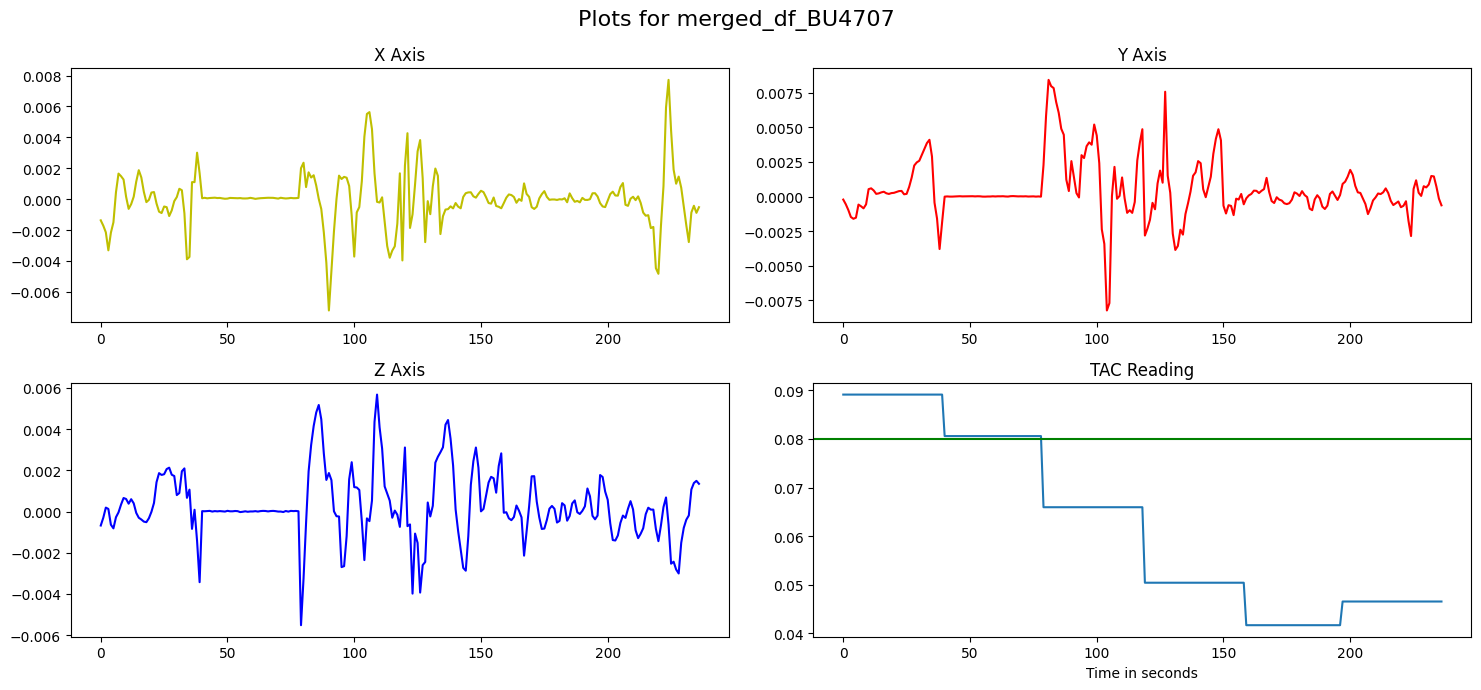

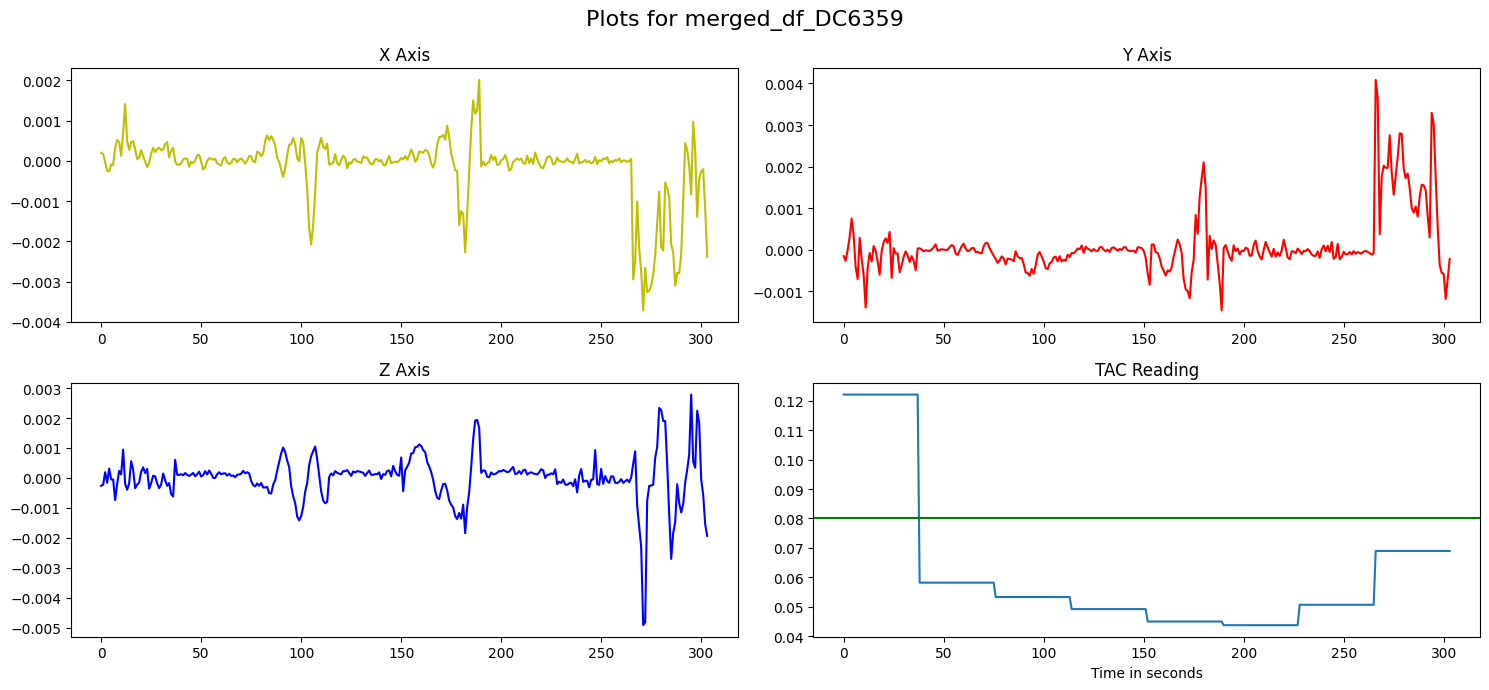

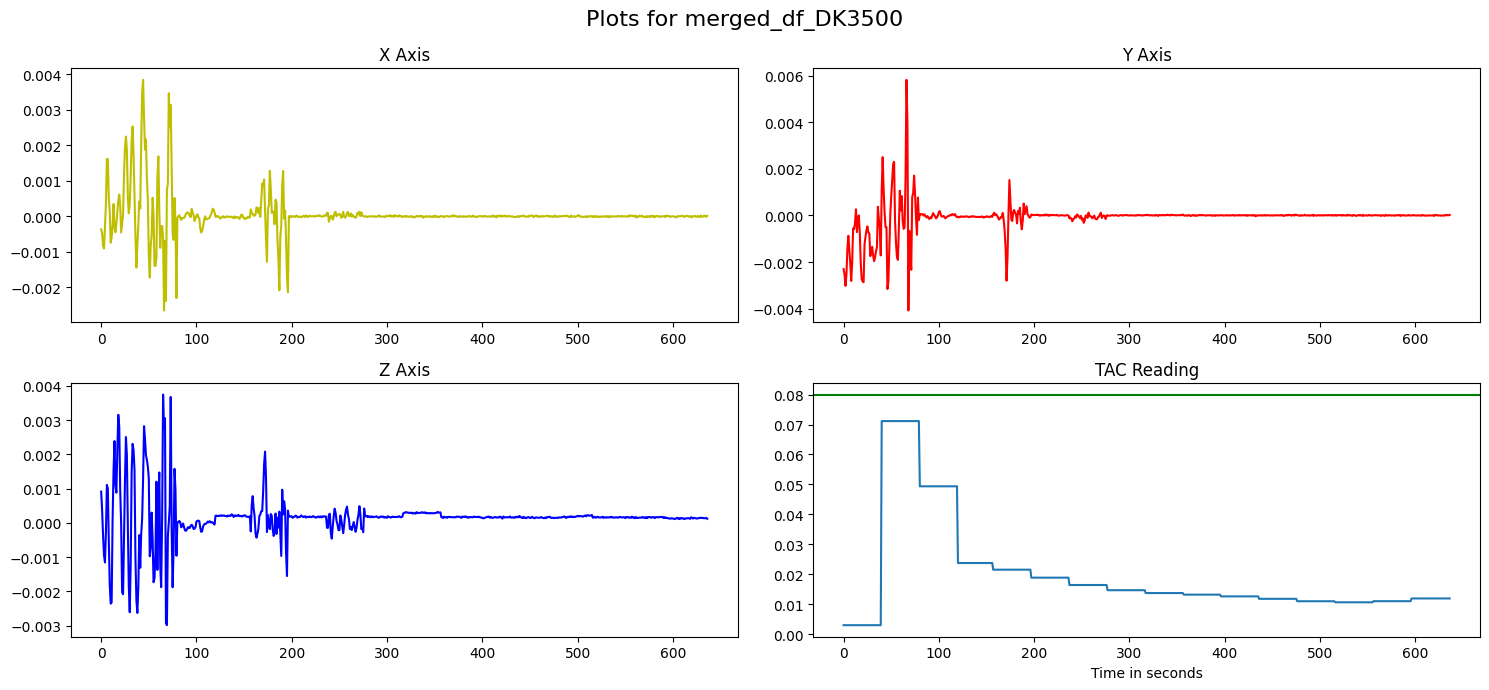

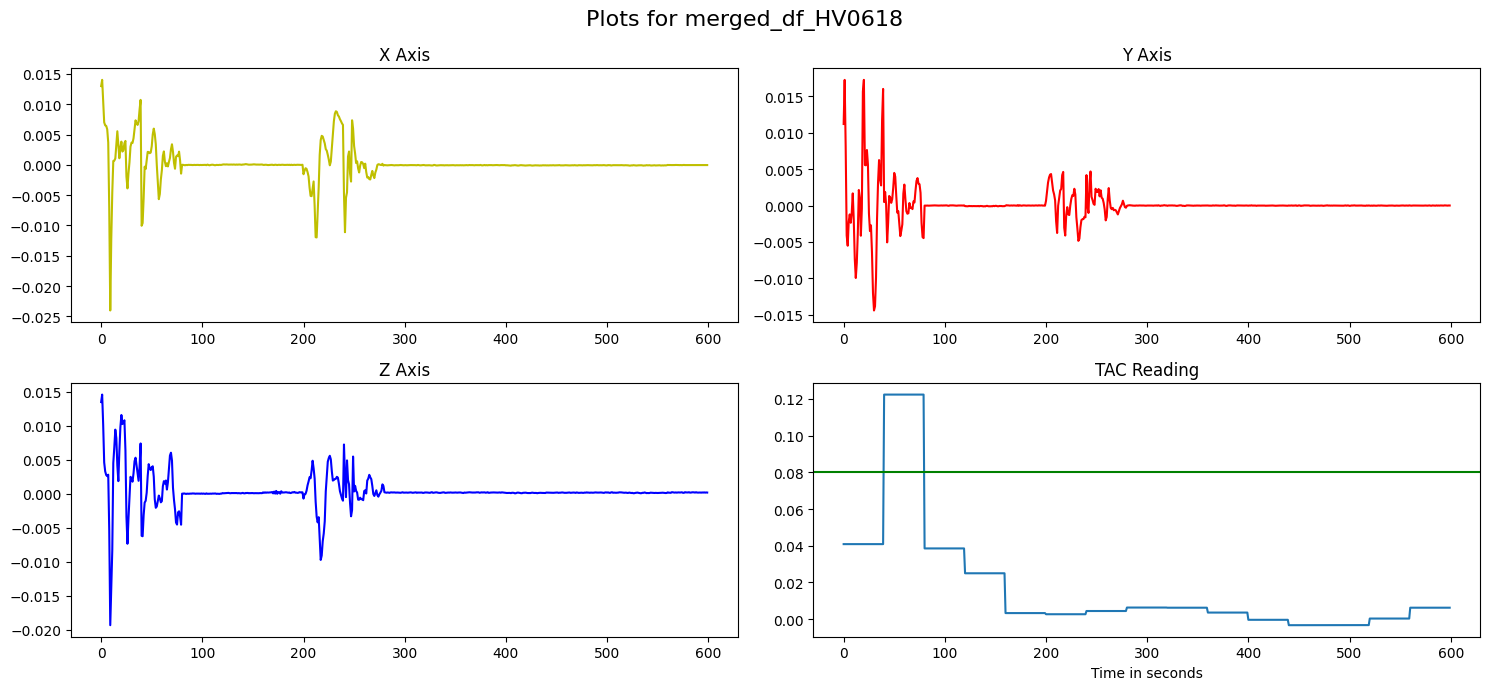

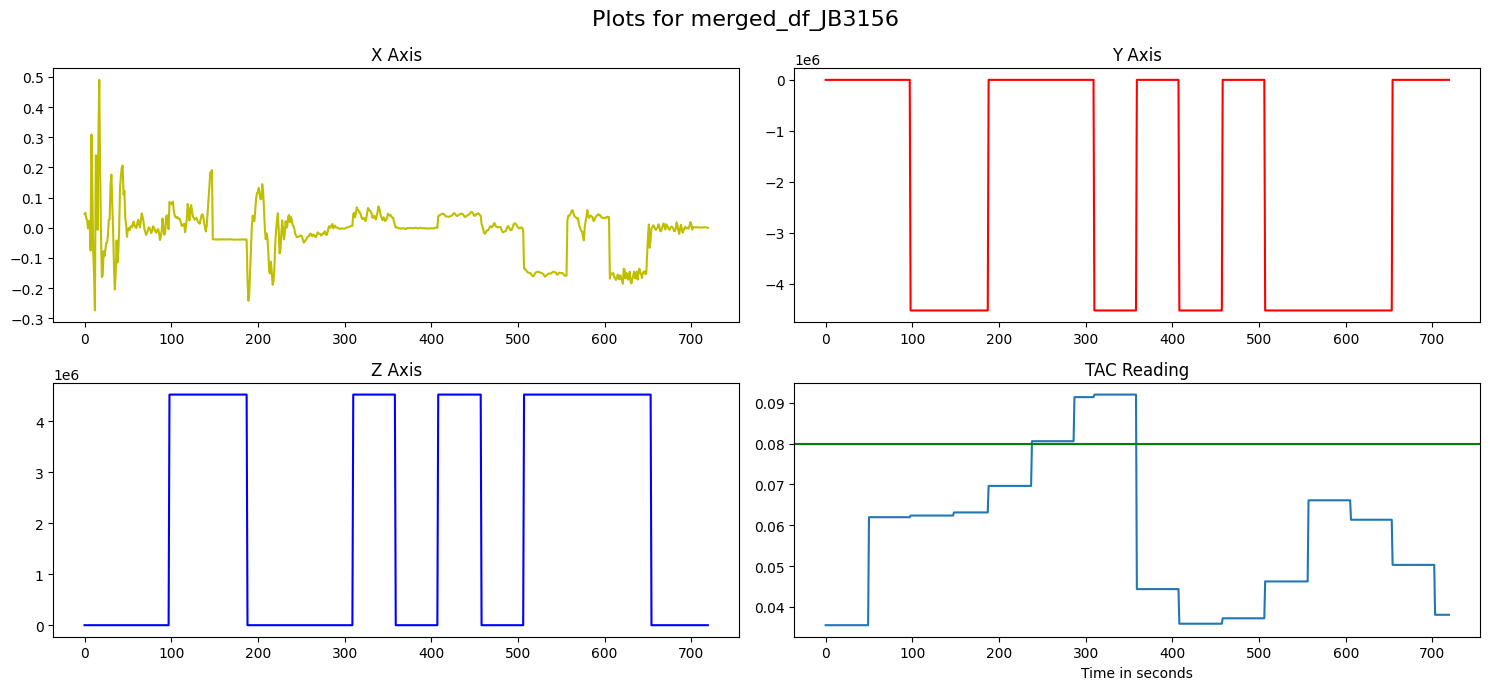

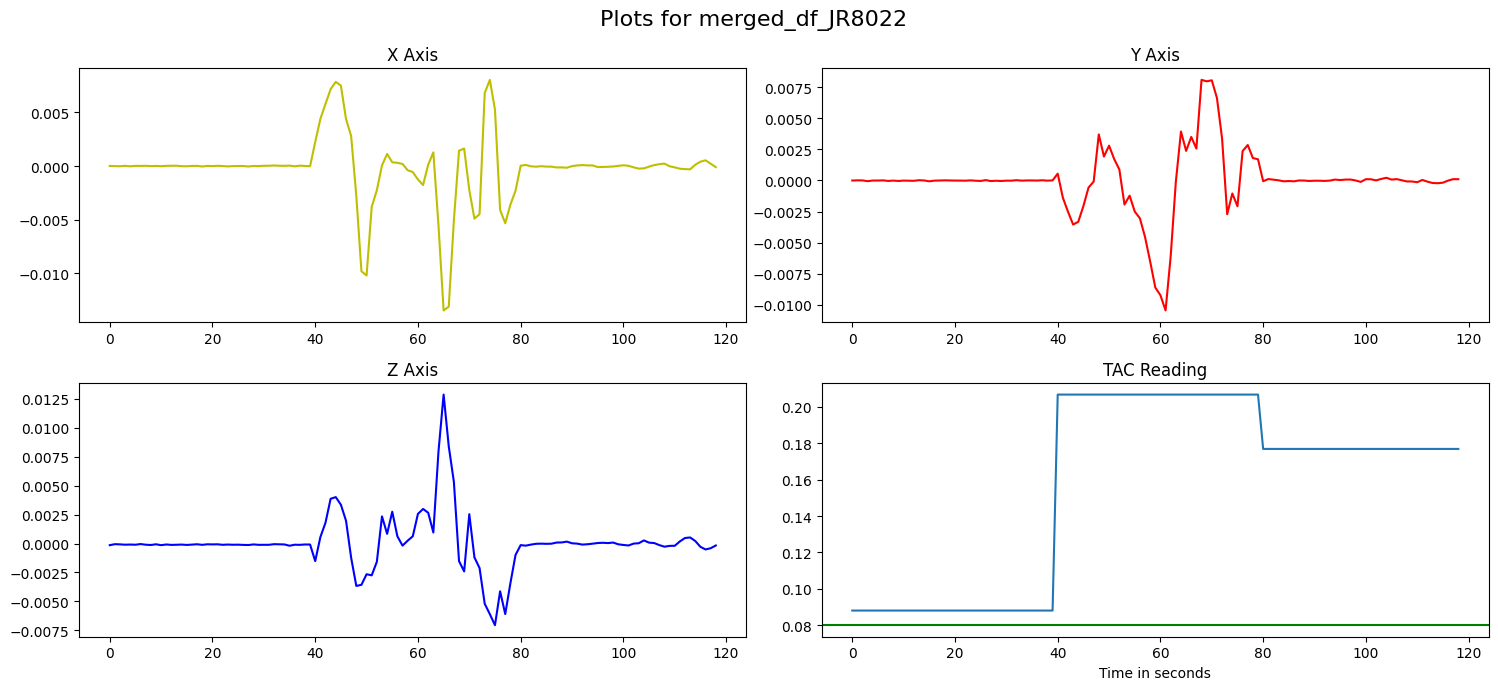

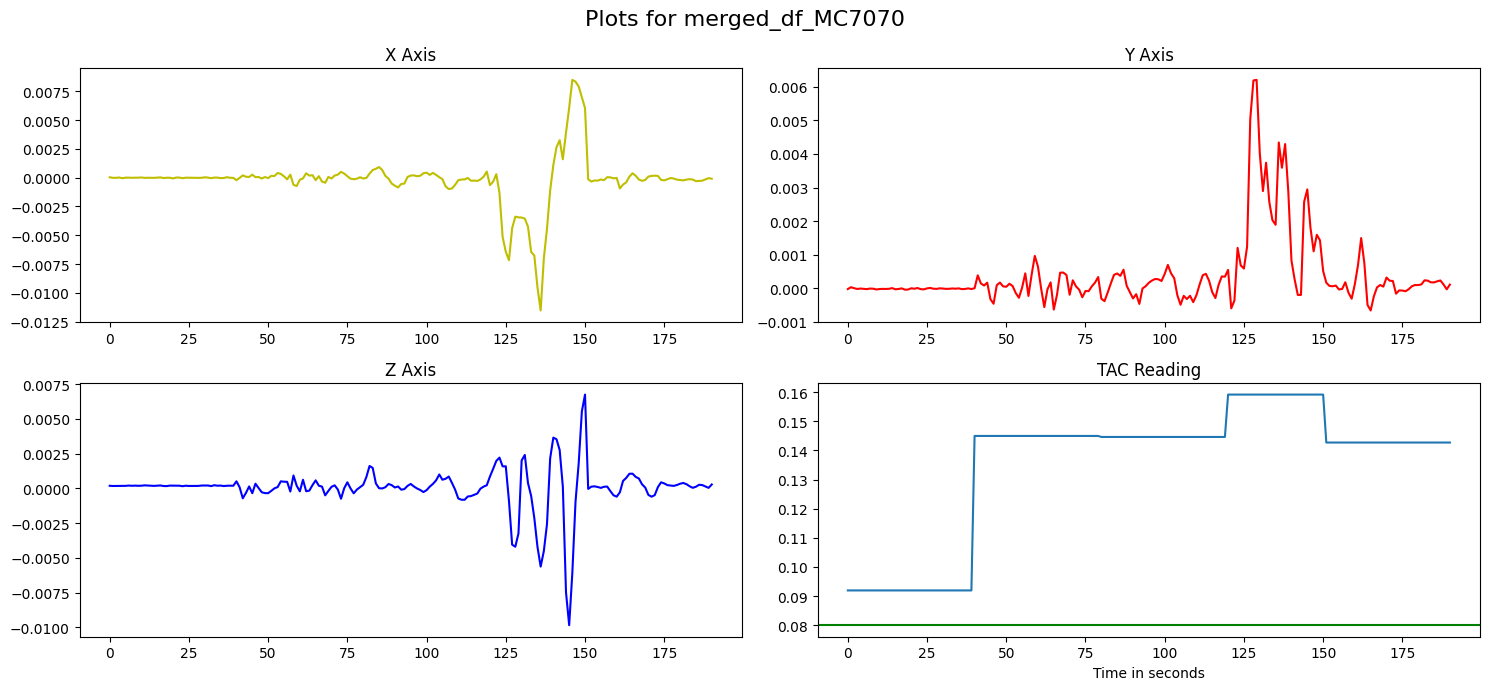

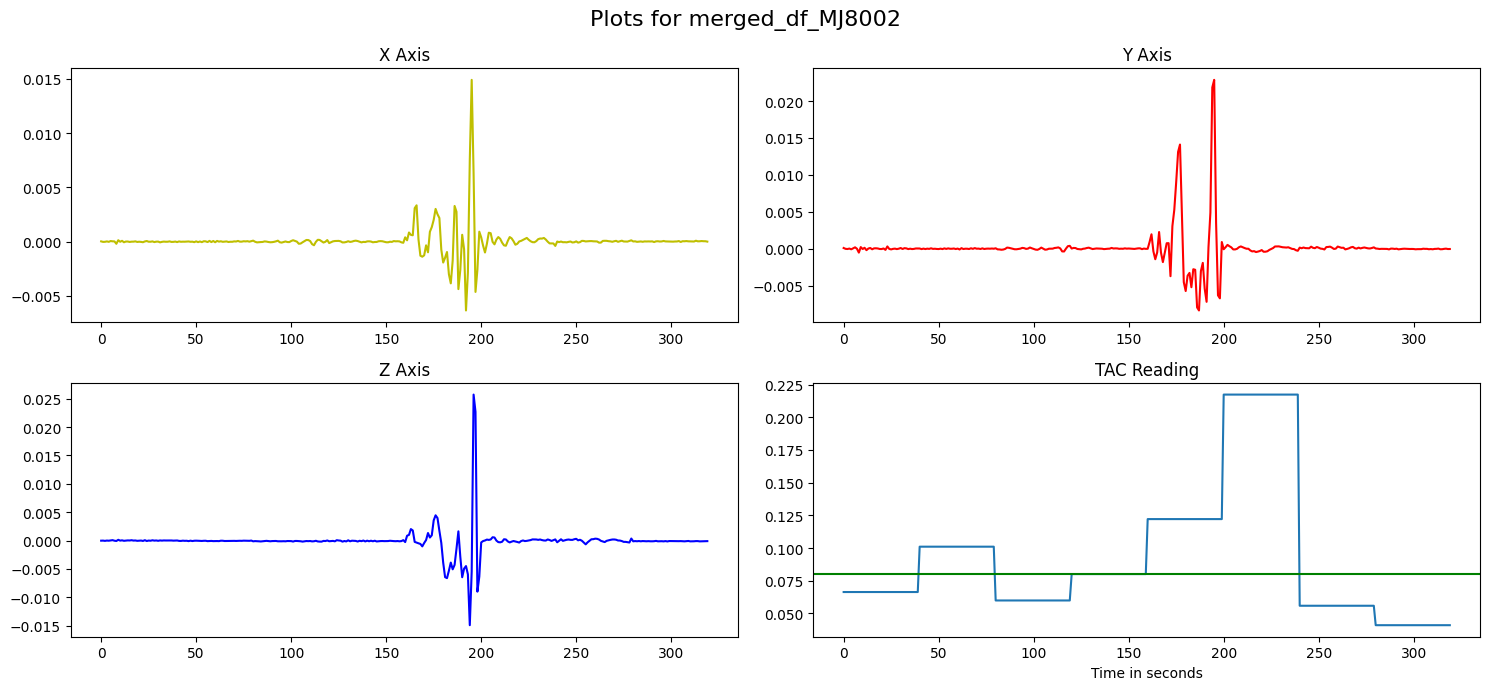

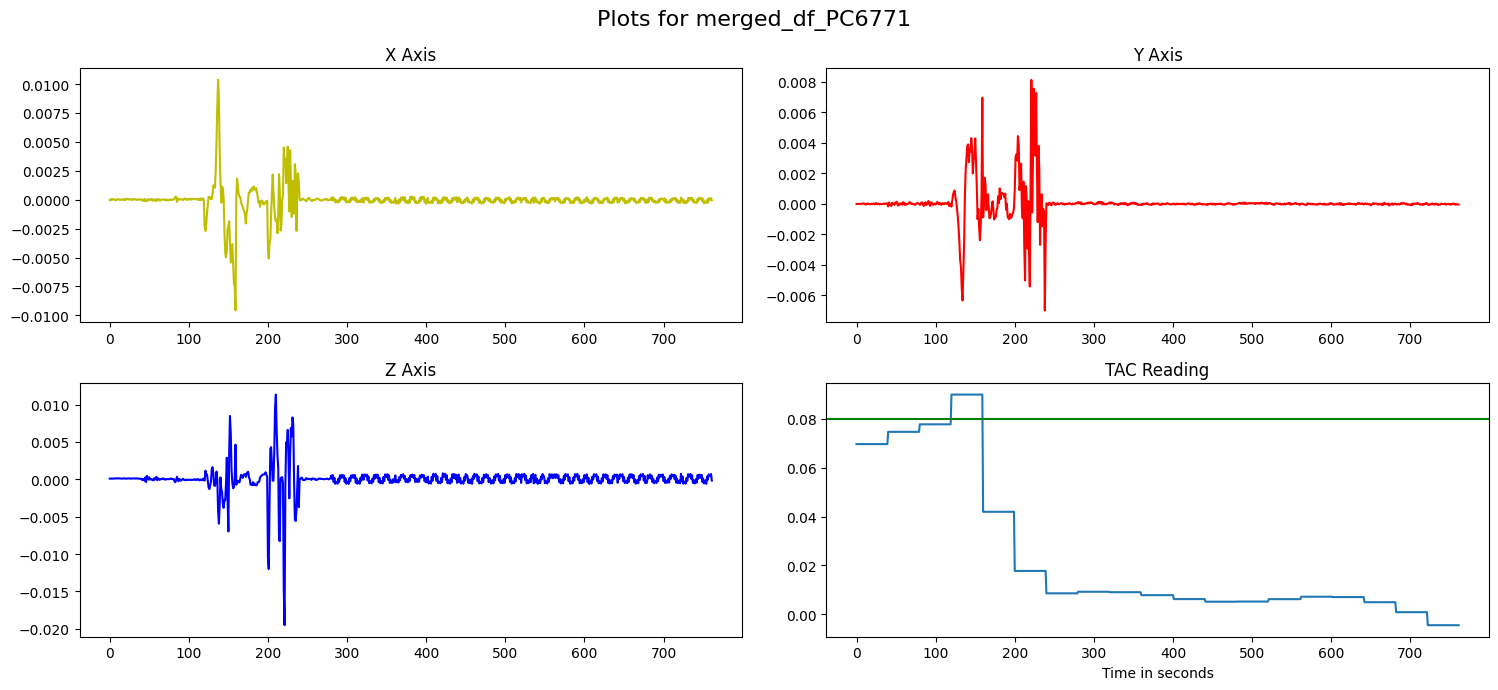

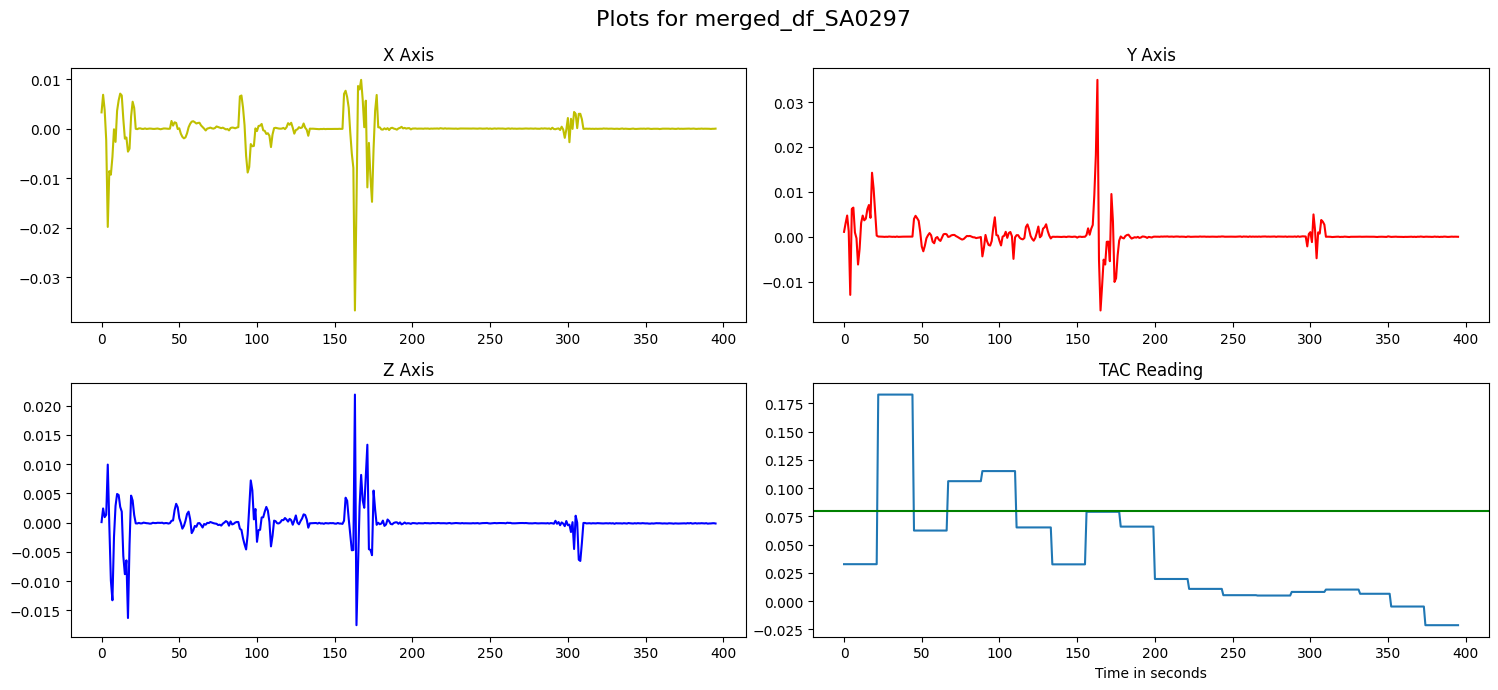

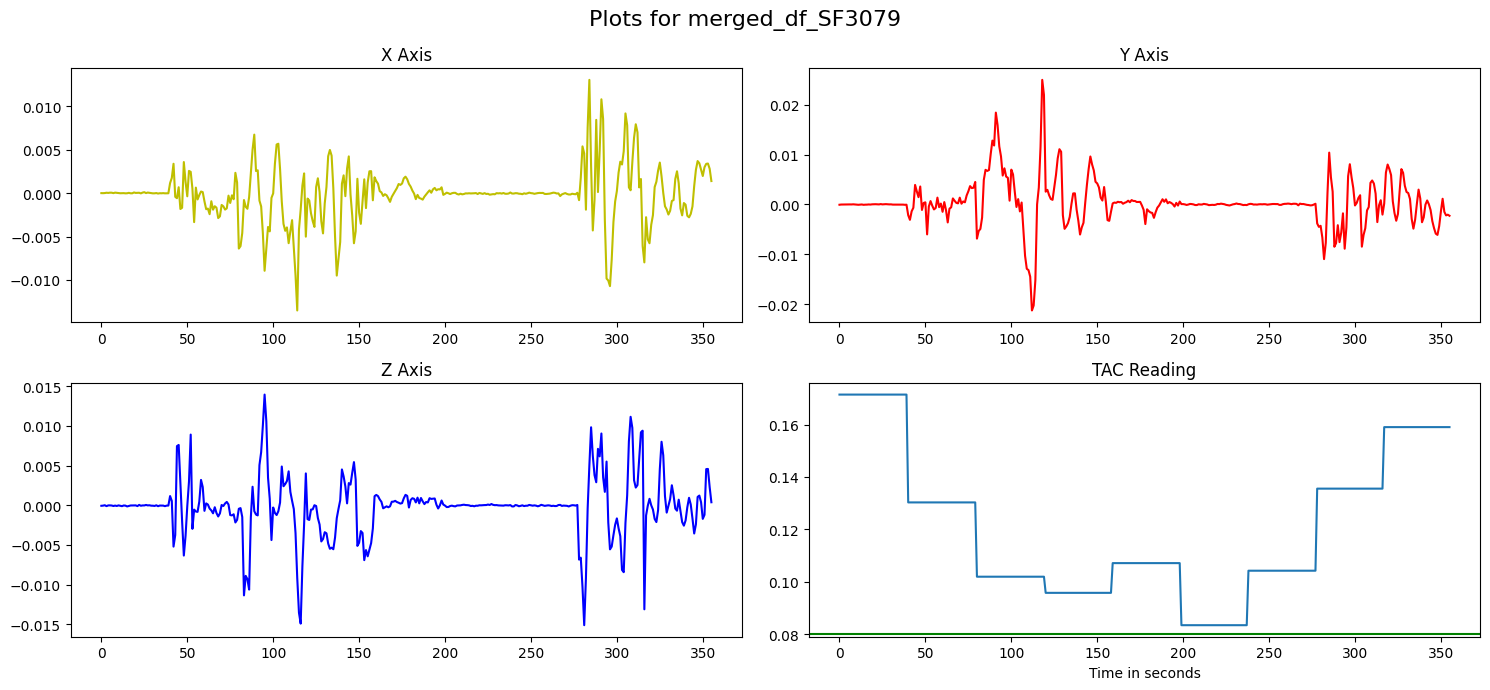

In [199]:
import numpy as np
import matplotlib.pyplot as plt

# List of DataFrame objects with their corresponding IDs
dataframes = [('merged_df_BK7610', merged_BK7610_df),
              ('merged_df_BU4707', merged_BU4707_df),
              ('merged_df_CC6740', merged_CC6740_df),
              ('merged_df_DC6359', merged_DC6359_df),
              ('merged_df_DK3500', merged_DK3500_df),
              ('merged_df_HV0618', merged_HV0618_df),
              ('merged_df_JB3156', merged_JB3156_df),
              ('merged_df_JR8022', merged_JR8022_df),
              ('merged_df_MC7070', merged_MC7070_df),
              ('merged_df_MJ8002', merged_MJ8002_df),
              ('merged_df_PC6771', merged_PC6771_df),
              ('merged_df_SA0297', merged_SA0297_df),
              ('merged_df_SF3079', merged_SF3079_df)]

# Loop over each DataFrame and ID tuple
for idx, (id_name, df) in enumerate(dataframes, start=1):
    t = np.arange(df['x'].size)
    fig, axs = plt.subplots(2, 2, figsize=(15, 7))
    plt.xlabel("Time in seconds")
    axs[0, 0].plot(t, df['x'],color='y')
    axs[0, 0].set_title('X Axis')
    axs[0, 1].plot(t, df['y'],color='r')
    axs[0, 1].set_title('Y Axis')
    axs[1, 0].plot(t, df['z'],color='b')
    axs[1, 0].set_title('Z Axis')
    axs[1, 1].plot(t, df['TAC_Reading'])
    axs[1, 1].axhline(y=0.08, color='g', linestyle='-')
    axs[1, 1].set_title('TAC Reading')
    plt.suptitle(f"Plots for {id_name}", fontsize=16)
    plt.tight_layout()
    plt.show()


# ***Permutation Entropy and Complexity***

## Below are the functions defined to calculate the permutation entropy and complexity for all the suject's measurments

In [200]:
''' This module has essential functions supporting
fast and effective computation of permutation entropy and
its different variations.'''
import numpy as np


def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])


def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0])

Performing further analysis of the data by sorting the TAC Readings of each PID and segmenting them into groups of time interval were the TAC values remained constant and jumped to the next time interval at TAC value change. This step is performed to carefully analyze the person's behaviour over a period of time taking into consideration that the behaviour can be observed only over a period of time and not at every second when the TAC value is measured.

# **BK7610**

### X axis Pid BK7610


In [201]:
#Sorting the data in ascending order of TAC Reading
sort_BK7610 = merged_BK7610_df.sort_values(by=['TAC_Reading'])
sort_BK7610

time     pid         x         y         z   timestamp  \
336  1493752430487  BK7610  0.002322 -0.003135 -0.000105  1493752430   
339  1493752430561  BK7610  0.000655 -0.002283  0.001128  1493752430   
340  1493752430589  BK7610  0.000718 -0.001765  0.001678  1493752430   
341  1493752430620  BK7610  0.000845 -0.001430  0.001880  1493752430   
342  1493752430637  BK7610  0.000827 -0.000830  0.002138  1493752430   
..             ...     ...       ...       ...       ...         ...   
580  1493763497605  BK7610  0.000060  0.002293  0.000405  1493763497   
579  1493763497580  BK7610 -0.000090  0.001505  0.000378  1493763497   
578  1493763497555  BK7610 -0.000265  0.000750  0.000188  1493763497   
576  1493763497505  BK7610  0.000035  0.000030 -0.000232  1493763497   
556  1493763497005  BK7610 -0.000782 -0.000240  0.000428  1493763497   

     TAC_Reading  
336     0.041689  
339     0.041689  
340     0.041689  
341     0.041689  
342     0.041689  
..           ...  
580     0.171758  
579     0.171758  
578     0.171758  
576     0.171758  
556     0.171758  

[674 rows x 7 columns]

In [202]:
# Using dataframe sort_BK7610: additional classification to check if 'TAC_Reading' value is >0.08 or not
#Sober = 0 , Intoxicated (Not Sober) = 1

sort_BK7610['Sober_classification'] = sort_BK7610['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_BK7610

time     pid         x         y         z   timestamp  \
336  1493752430487  BK7610  0.002322 -0.003135 -0.000105  1493752430   
339  1493752430561  BK7610  0.000655 -0.002283  0.001128  1493752430   
340  1493752430589  BK7610  0.000718 -0.001765  0.001678  1493752430   
341  1493752430620  BK7610  0.000845 -0.001430  0.001880  1493752430   
342  1493752430637  BK7610  0.000827 -0.000830  0.002138  1493752430   
..             ...     ...       ...       ...       ...         ...   
580  1493763497605  BK7610  0.000060  0.002293  0.000405  1493763497   
579  1493763497580  BK7610 -0.000090  0.001505  0.000378  1493763497   
578  1493763497555  BK7610 -0.000265  0.000750  0.000188  1493763497   
576  1493763497505  BK7610  0.000035  0.000030 -0.000232  1493763497   
556  1493763497005  BK7610 -0.000782 -0.000240  0.000428  1493763497   

     TAC_Reading  Sober_classification  
336     0.041689                     0  
339     0.041689                     0  
340     0.041689                     0  
341     0.041689                     0  
342     0.041689                     0  
..           ...                   ...  
580     0.171758                     1  
579     0.171758                     1  
578     0.171758                     1  
576     0.171758                     1  
556     0.171758                     1  

[674 rows x 8 columns]

In [203]:
#Resetting the index values after sorting
sort_BK7610.reset_index(drop=True)

time     pid         x         y         z   timestamp  \
0    1493752430487  BK7610  0.002322 -0.003135 -0.000105  1493752430   
1    1493752430561  BK7610  0.000655 -0.002283  0.001128  1493752430   
2    1493752430589  BK7610  0.000718 -0.001765  0.001678  1493752430   
3    1493752430620  BK7610  0.000845 -0.001430  0.001880  1493752430   
4    1493752430637  BK7610  0.000827 -0.000830  0.002138  1493752430   
..             ...     ...       ...       ...       ...         ...   
669  1493763497605  BK7610  0.000060  0.002293  0.000405  1493763497   
670  1493763497580  BK7610 -0.000090  0.001505  0.000378  1493763497   
671  1493763497555  BK7610 -0.000265  0.000750  0.000188  1493763497   
672  1493763497505  BK7610  0.000035  0.000030 -0.000232  1493763497   
673  1493763497005  BK7610 -0.000782 -0.000240  0.000428  1493763497   

     TAC_Reading  Sober_classification  
0       0.041689                     0  
1       0.041689                     0  
2       0.041689                     0  
3       0.041689                     0  
4       0.041689                     0  
..           ...                   ...  
669     0.171758                     1  
670     0.171758                     1  
671     0.171758                     1  
672     0.171758                     1  
673     0.171758                     1  

[674 rows x 8 columns]

In [204]:
#Counting the number of TAC Reading in each segment
count_BK7610=sort_BK7610['TAC_Reading'].value_counts()
count_BK7610

TAC_Reading
0.041689    40
0.080588    40
0.160774    40
0.148265    40
0.099630    40
0.090165    40
0.046559    40
0.085197    40
0.076462    40
0.067269    40
0.065953    40
0.050424    40
0.171758    40
0.134315    39
0.065357    39
0.089122    38
0.166076    38
Name: count, dtype: int64

In [205]:
#Calculating the permutation entropy and complexity
TAC_Reading_BK7610 = pd.Series([40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 39, 39, 38, 38], name='count')
pe_results_x_bk7610= []
comp_results_x_bk7610=[]
i=0
for segment_value in TAC_Reading_BK7610:
  num_segs=len(sort_BK7610['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_BK7610[i-1]
  end_index = start_index + (segment_value)
  segment = sort_BK7610['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp= complexity(op)
  pe_results_x_bk7610.append(pe)
  comp_results_x_bk7610.append(comp)
  i+=1
print(pe_results_x_bk7610)
print(comp_results_x_bk7610)

[0.9464035255118256, 0.9793684224284439, 0.954914252440094, 0.9530718705618363, 0.953456029387272, 0.9745703937213608, 0.9820923909706727, 0.9003219902604952, 0.9963737177488018, 0.8894512498367868, 0.9654427345652585, 0.8873833515146428, 0.9794683843586323, 0.9557115544611606, 0.8982826972921764, 0.9858245695739678, 0.8419227596229291]
[0.05010893483656408, 0.020279004318194863, 0.0428550605474601, 0.043037122446127604, 0.04471247659418525, 0.024940115253463933, 0.017515590606528773, 0.08360384366767445, 0.0034556316276051526, 0.09699886538939884, 0.03464232642417998, 0.10730159832028163, 0.01908297068285754, 0.044237052452558275, 0.08788455099858389, 0.013229651759662547, 0.13759664778109734]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


###Y axis Pid BK7610

In [206]:
#Calculating the permutation entropy and complexity
pe_results_y_bk7610= []
comp_results_y_bk7610=[]
i=0
for segment_value in TAC_Reading_BK7610:
  num_segs=len(sort_BK7610['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_BK7610[i-1]
  end_index = start_index + (segment_value)
  segment = sort_BK7610['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp= complexity(op)
  pe_results_y_bk7610.append(pe)
  comp_results_y_bk7610.append(comp)
  i+=1
print(pe_results_y_bk7610)
print(comp_results_y_bk7610)

[0.8525481382550969, 0.9765110569681833, 0.9447543560500088, 0.9699565663770943, 0.9819276984647238, 0.9700057238624977, 0.9793701029900673, 0.8204570214427122, 0.9766757494741322, 0.9355546694283879, 0.9203321922012823, 0.9689890597188715, 0.9799870352179012, 0.9085949474363799, 0.8928095231467471, 0.9925857947036592, 0.8763169785816157]
[0.12066868593456458, 0.022224166470248847, 0.05493562644781031, 0.027193201386596685, 0.016675115136992956, 0.029169073956891636, 0.02158271487513371, 0.14908016594801338, 0.023060973182618006, 0.058439215028076114, 0.07296372830798796, 0.029568366191570696, 0.019417615265194914, 0.08258819303060479, 0.0984429936280149, 0.007118477630245634, 0.11661643085461071]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


### Z axis Pid BK7610

In [207]:
#Calculating the permutation entropy and complexity
pe_results_z_bk7610= []
comp_results_z_bk7610=[]
i=0
for segment_value in TAC_Reading_BK7610:
  num_segs=len(sort_BK7610['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_BK7610[i-1]
  end_index = start_index + (segment_value)
  segment = sort_BK7610['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp= complexity(op)
  pe_results_z_bk7610.append(pe)
  comp_results_z_bk7610.append(comp)
  i+=1
print(pe_results_z_bk7610)
print(comp_results_z_bk7610)

[0.8708371432685482, 0.9772647472372961, 0.9457430857289653, 0.9534560293872721, 0.9775277211118097, 0.9182268364485108, 0.9567410612279952, 0.9212454081855889, 0.9689890597188715, 0.9355546694283877, 0.958609697009299, 0.9820923909706726, 0.9569320076369903, 0.9461680581595947, 0.9009143363990059, 0.9498797329895856, 0.8974334045733163]
[0.11075771602066249, 0.023470504142601087, 0.05469772260733315, 0.04471247659418455, 0.02181365216135073, 0.07461415506801904, 0.04509619150205726, 0.06756114866706393, 0.029568366191570696, 0.058439215028076565, 0.03674193751157214, 0.017515590606529016, 0.04205771066008148, 0.04848661304501996, 0.08650308864235033, 0.04677833485826813, 0.09138082439301075]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Permutation Entropy and Complexity plots

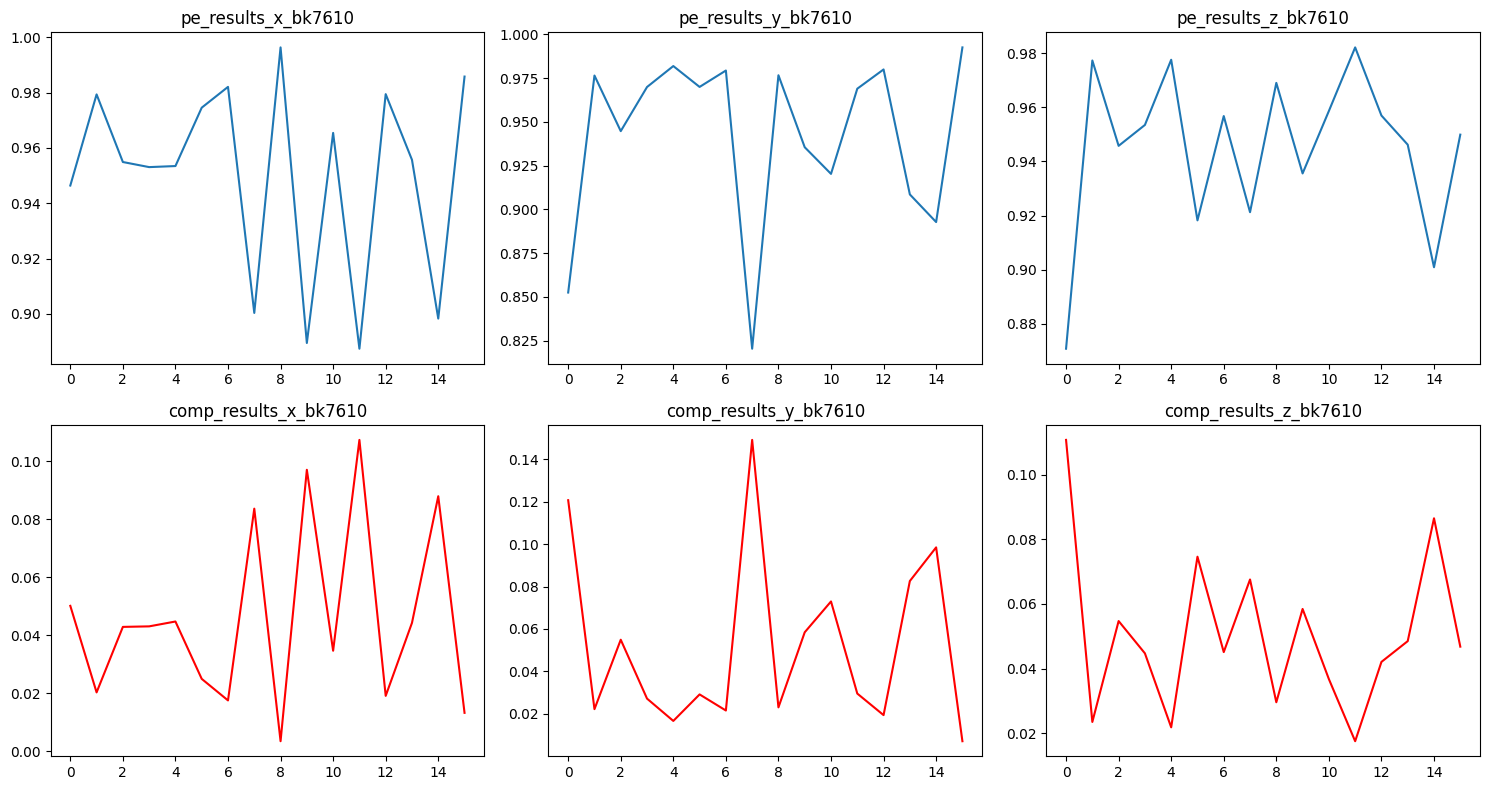

In [208]:
#Plotting the permutation entropy and complexity graphs
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_bk7610[0:16], ax=axes[0, 0])
sns.lineplot(data=pe_results_y_bk7610[0:16], ax=axes[0, 1])
sns.lineplot(data=pe_results_z_bk7610[0:16], ax=axes[0, 2])

# Plot comp_results
sns.lineplot(data=comp_results_x_bk7610[0:16], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_bk7610[0:16], ax=axes[1, 1],color='r')
sns.lineplot(data=comp_results_z_bk7610[0:16], ax=axes[1, 2],color='r')

# Set titles
axes[0, 0].set_title('pe_results_x_bk7610')
axes[0, 1].set_title('pe_results_y_bk7610')
axes[0, 2].set_title('pe_results_z_bk7610')
axes[1, 0].set_title('comp_results_x_bk7610')
axes[1, 1].set_title('comp_results_y_bk7610')
axes[1, 2].set_title('comp_results_z_bk7610')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

    Pe_results  Comp_results  TAC_Reading  Sober_classification
0     0.946404      0.050109     0.041689                     0
1     0.979368      0.020279     0.080588                     1
2     0.954914      0.042855     0.160774                     1
3     0.953072      0.043037     0.148265                     1
4     0.953456      0.044712     0.099630                     1
5     0.974570      0.024940     0.090165                     1
6     0.982092      0.017516     0.046559                     0
7     0.900322      0.083604     0.085197                     1
8     0.996374      0.003456     0.076462                     0
9     0.889451      0.096999     0.067269                     0
10    0.965443      0.034642     0.065953                     0
11    0.887383      0.107302     0.050424                     0
12    0.979468      0.019083     0.171758                     1
13    0.955712      0.044237     0.134315                     1
14    0.898283      0.087885     0.06535

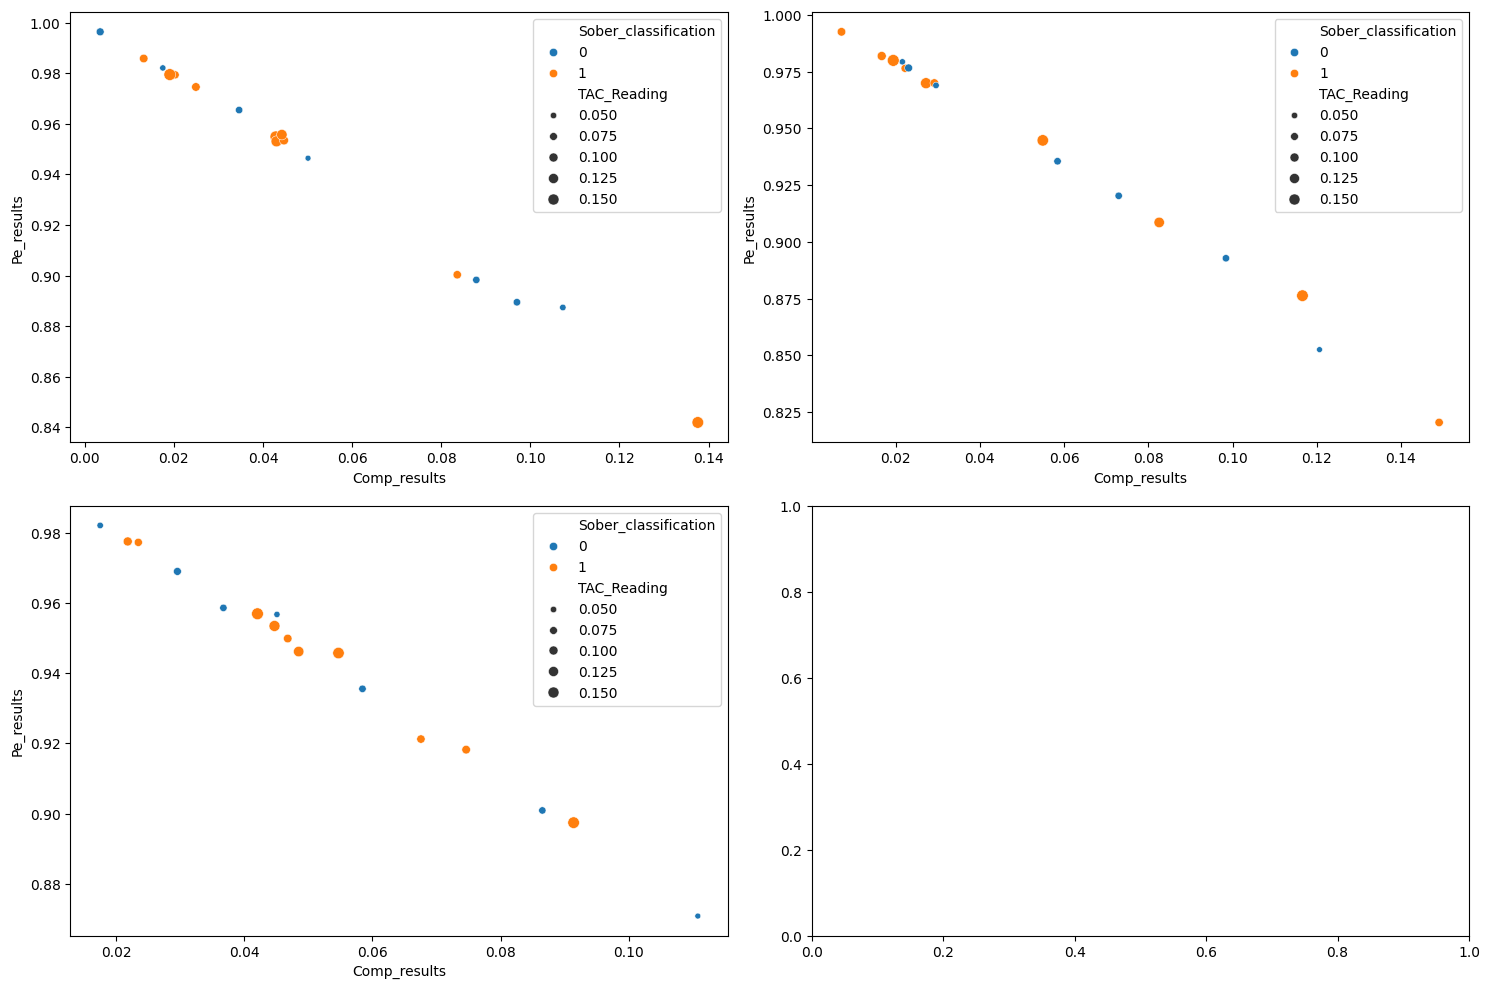

In [209]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_BK7610= ['0.041689','0.080588','0.160774','0.148265','0.099630','0.090165','0.046559','0.085197','0.076462','0.067269','0.065953','0.050424','0.171758','0.134315','0.065357','0.089122','0.166076']

# Create DataFrame using lists
bk7610_x =  pd.DataFrame({'Pe_results': pe_results_x_bk7610, 'Comp_results': comp_results_x_bk7610,'TAC_Reading':list_BK7610})
bk7610_y =  pd.DataFrame({'Pe_results': pe_results_y_bk7610, 'Comp_results': comp_results_y_bk7610,'TAC_Reading':list_BK7610})
bk7610_z =  pd.DataFrame({'Pe_results': pe_results_z_bk7610, 'Comp_results': comp_results_z_bk7610,'TAC_Reading':list_BK7610})
#Conerting data type to float
bk7610_x['TAC_Reading'] = bk7610_x['TAC_Reading'].astype(float)
bk7610_y['TAC_Reading'] = bk7610_y['TAC_Reading'].astype(float)
bk7610_z['TAC_Reading'] = bk7610_z['TAC_Reading'].astype(float)

bk7610_x['Sober_classification'] = bk7610_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
bk7610_y['Sober_classification'] = bk7610_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
bk7610_z['Sober_classification'] = bk7610_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(bk7610_x)
print(bk7610_y)
print(bk7610_z)

#Scatter Plot
fig,axes = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(data=bk7610_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=bk7610_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=bk7610_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# **BU4707**


##X axis Pid BU4707

In [210]:
#Sorting the data in ascending order of TAC Reading
sort_BU4707 = merged_BU4707_df.sort_values(by=['TAC_Reading'])
sort_BU4707

time     pid         x         y         z   timestamp  \
177  1493752430518  BU4707 -0.000042 -0.000225  0.000135  1493752430   
180  1493752430593  BU4707 -0.000050  0.000038 -0.000535  1493752430   
181  1493752430619  BU4707 -0.000005  0.000387 -0.000455  1493752430   
182  1493752430644  BU4707 -0.000020  0.000110  0.000405  1493752430   
183  1493752430669  BU4707  0.000058 -0.000040  0.000298  1493752430   
..             ...     ...       ...       ...       ...         ...   
24   1493744843604  BU4707 -0.000898  0.000162  0.001775  1493744843   
23   1493744843579  BU4707 -0.000810  0.000405  0.001863  1493744843   
22   1493744843553  BU4707 -0.000282  0.000392  0.001422  1493744843   
20   1493744843504  BU4707  0.000428  0.000267 -0.000013  1493744843   
0    1493744843003  BU4707 -0.001370 -0.000220 -0.000680  1493744843   

     TAC_Reading  
177     0.041689  
180     0.041689  
181     0.041689  
182     0.041689  
183     0.041689  
..           ...  
24      0.089122  
23      0.089122  
22      0.089122  
20      0.089122  
0       0.089122  

[237 rows x 7 columns]

In [211]:
# Using dataframe sort_BU4707: additional classification to check if 'TAC_Reading' value is >0.08 or not

sort_BU4707['Sober_classification'] = sort_BU4707['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_BU4707

time     pid         x         y         z   timestamp  \
177  1493752430518  BU4707 -0.000042 -0.000225  0.000135  1493752430   
180  1493752430593  BU4707 -0.000050  0.000038 -0.000535  1493752430   
181  1493752430619  BU4707 -0.000005  0.000387 -0.000455  1493752430   
182  1493752430644  BU4707 -0.000020  0.000110  0.000405  1493752430   
183  1493752430669  BU4707  0.000058 -0.000040  0.000298  1493752430   
..             ...     ...       ...       ...       ...         ...   
24   1493744843604  BU4707 -0.000898  0.000162  0.001775  1493744843   
23   1493744843579  BU4707 -0.000810  0.000405  0.001863  1493744843   
22   1493744843553  BU4707 -0.000282  0.000392  0.001422  1493744843   
20   1493744843504  BU4707  0.000428  0.000267 -0.000013  1493744843   
0    1493744843003  BU4707 -0.001370 -0.000220 -0.000680  1493744843   

     TAC_Reading  Sober_classification  
177     0.041689                     0  
180     0.041689                     0  
181     0.041689                     0  
182     0.041689                     0  
183     0.041689                     0  
..           ...                   ...  
24      0.089122                     1  
23      0.089122                     1  
22      0.089122                     1  
20      0.089122                     1  
0       0.089122                     1  

[237 rows x 8 columns]

In [212]:
#Resetting the index values after sorting
sort_BU4707.reset_index(drop=True)

time     pid         x         y         z   timestamp  \
0    1493752430518  BU4707 -0.000042 -0.000225  0.000135  1493752430   
1    1493752430593  BU4707 -0.000050  0.000038 -0.000535  1493752430   
2    1493752430619  BU4707 -0.000005  0.000387 -0.000455  1493752430   
3    1493752430644  BU4707 -0.000020  0.000110  0.000405  1493752430   
4    1493752430669  BU4707  0.000058 -0.000040  0.000298  1493752430   
..             ...     ...       ...       ...       ...         ...   
232  1493744843604  BU4707 -0.000898  0.000162  0.001775  1493744843   
233  1493744843579  BU4707 -0.000810  0.000405  0.001863  1493744843   
234  1493744843553  BU4707 -0.000282  0.000392  0.001422  1493744843   
235  1493744843504  BU4707  0.000428  0.000267 -0.000013  1493744843   
236  1493744843003  BU4707 -0.001370 -0.000220 -0.000680  1493744843   

     TAC_Reading  Sober_classification  
0       0.041689                     0  
1       0.041689                     0  
2       0.041689                     0  
3       0.041689                     0  
4       0.041689                     0  
..           ...                   ...  
232     0.089122                     1  
233     0.089122                     1  
234     0.089122                     1  
235     0.089122                     1  
236     0.089122                     1  

[237 rows x 8 columns]

In [213]:
#Counting the number of TAC Reading in each segment
count_BU4707=sort_BU4707['TAC_Reading'].value_counts()
count_BU4707

TAC_Reading
0.046559    40
0.050424    40
0.065953    40
0.089122    40
0.080588    39
0.041689    38
Name: count, dtype: int64

In [214]:
#Calculating the permutation entropy and complexity
TAC_Reading_BU4707 = pd.Series([40, 40, 40, 40, 39, 38],name='count')
pe_results_x_bu4707= []
comp_results_x_bu4707=[]
i=0
for segment_value in TAC_Reading_BU4707:
  num_segs=len(sort_BU4707['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_BU4707[i-1]
  end_index = start_index + (segment_value)
  segment = sort_BU4707['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_x_bu4707.append(pe)
  comp_results_x_bu4707.append(comp)
  i+=1
print(pe_results_x_bu4707)
print(comp_results_x_bu4707)

[0.9914550895366188, 0.8875898710139947, 0.970859376061799, 0.9819276984647238, 0.9939635559597791, 0.8577893754864903]
[0.008397768877605726, 0.11138013820403385, 0.029228299463340653, 0.016675115136992956, 0.0059899539800280415, 0.12820028367792588]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Y axis Pid BU4707

In [215]:
#Calculating the permutation entropy and complexity
pe_results_y_bu4707= []
comp_results_y_bu4707=[]
i=0
for segment_value in TAC_Reading_BU4707:
  num_segs=len(sort_BU4707['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_BU4707[i-1]
  end_index = start_index + (segment_value)
  segment = sort_BU4707['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp= complexity(op)
  pe_results_y_bu4707.append(pe)
  comp_results_y_bu4707.append(comp)
  i+=1
print(pe_results_y_bu4707)
print(comp_results_y_bu4707)

[0.9211733807200703, 0.9669992389866453, 0.9914550895366187, 0.9355546694283879, 0.9862382614875129, 0.8588183702561706]
[0.07479540571663292, 0.030277946235741374, 0.008397768877605967, 0.058439215028076114, 0.013699810936188814, 0.12312613357335789]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Z axis Pid BU4707

In [216]:
#Calculating the permutation entropy and complexity
pe_results_z_bu4707= []
comp_results_z_bu4707=[]
i=0
for segment_value in TAC_Reading_BU4707:
  num_segs=len(sort_BU4707['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_BU4707[i-1]
  end_index = start_index + (segment_value)
  segment = sort_BU4707['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp= complexity(op)
  pe_results_z_bu4707.append(pe)
  comp_results_z_bu4707.append(comp)
  i+=1
print(pe_results_z_bu4707)
print(comp_results_z_bu4707)

[0.9355546694283877, 0.913723410936277, 0.9561503829032075, 0.8708371432685484, 0.9939635559597791, 0.9625323662330157]
[0.058439215028076565, 0.07409626539872827, 0.03903897811155364, 0.11075771602066209, 0.0059899539800280415, 0.036533345016945905]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Permutation Entropy and Complexity plots

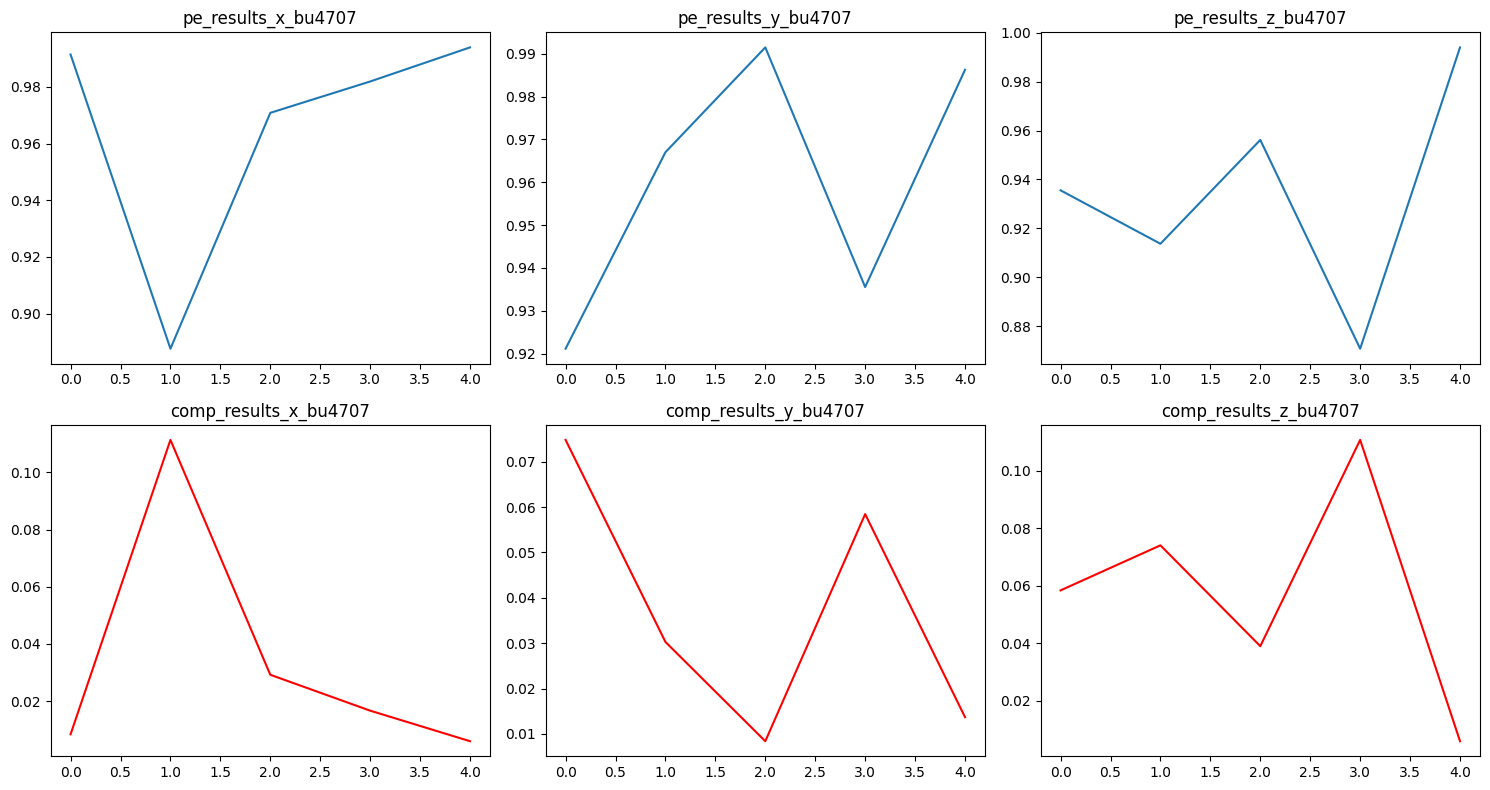

In [217]:
#Plotting the permutation entropy and complexity graphs
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_bu4707[0:5], ax=axes[0, 0])
sns.lineplot(data=pe_results_y_bu4707[0:5], ax=axes[0, 1])
sns.lineplot(data=pe_results_z_bu4707[0:5], ax=axes[0, 2])

# Plot comp_results
sns.lineplot(data=comp_results_x_bu4707[0:5], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_bu4707[0:5], ax=axes[1, 1],color='r')
sns.lineplot(data=comp_results_z_bu4707[0:5], ax=axes[1, 2],color='r')

# Set titles
axes[0, 0].set_title('pe_results_x_bu4707')
axes[0, 1].set_title('pe_results_y_bu4707')
axes[0, 2].set_title('pe_results_z_bu4707')
axes[1, 0].set_title('comp_results_x_bu4707')
axes[1, 1].set_title('comp_results_y_bu4707')
axes[1, 2].set_title('comp_results_z_bu4707')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.991455      0.008398     0.046559                     0
1    0.887590      0.111380     0.050424                     0
2    0.970859      0.029228     0.065953                     0
3    0.981928      0.016675     0.089122                     1
4    0.993964      0.005990     0.080588                     1
5    0.857789      0.128200     0.041689                     0
   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.921173      0.074795     0.046559                     0
1    0.966999      0.030278     0.050424                     0
2    0.991455      0.008398     0.065953                     0
3    0.935555      0.058439     0.089122                     1
4    0.986238      0.013700     0.080588                     1
5    0.858818      0.123126     0.041689                     0
   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.935555      0.058439     0.046559               

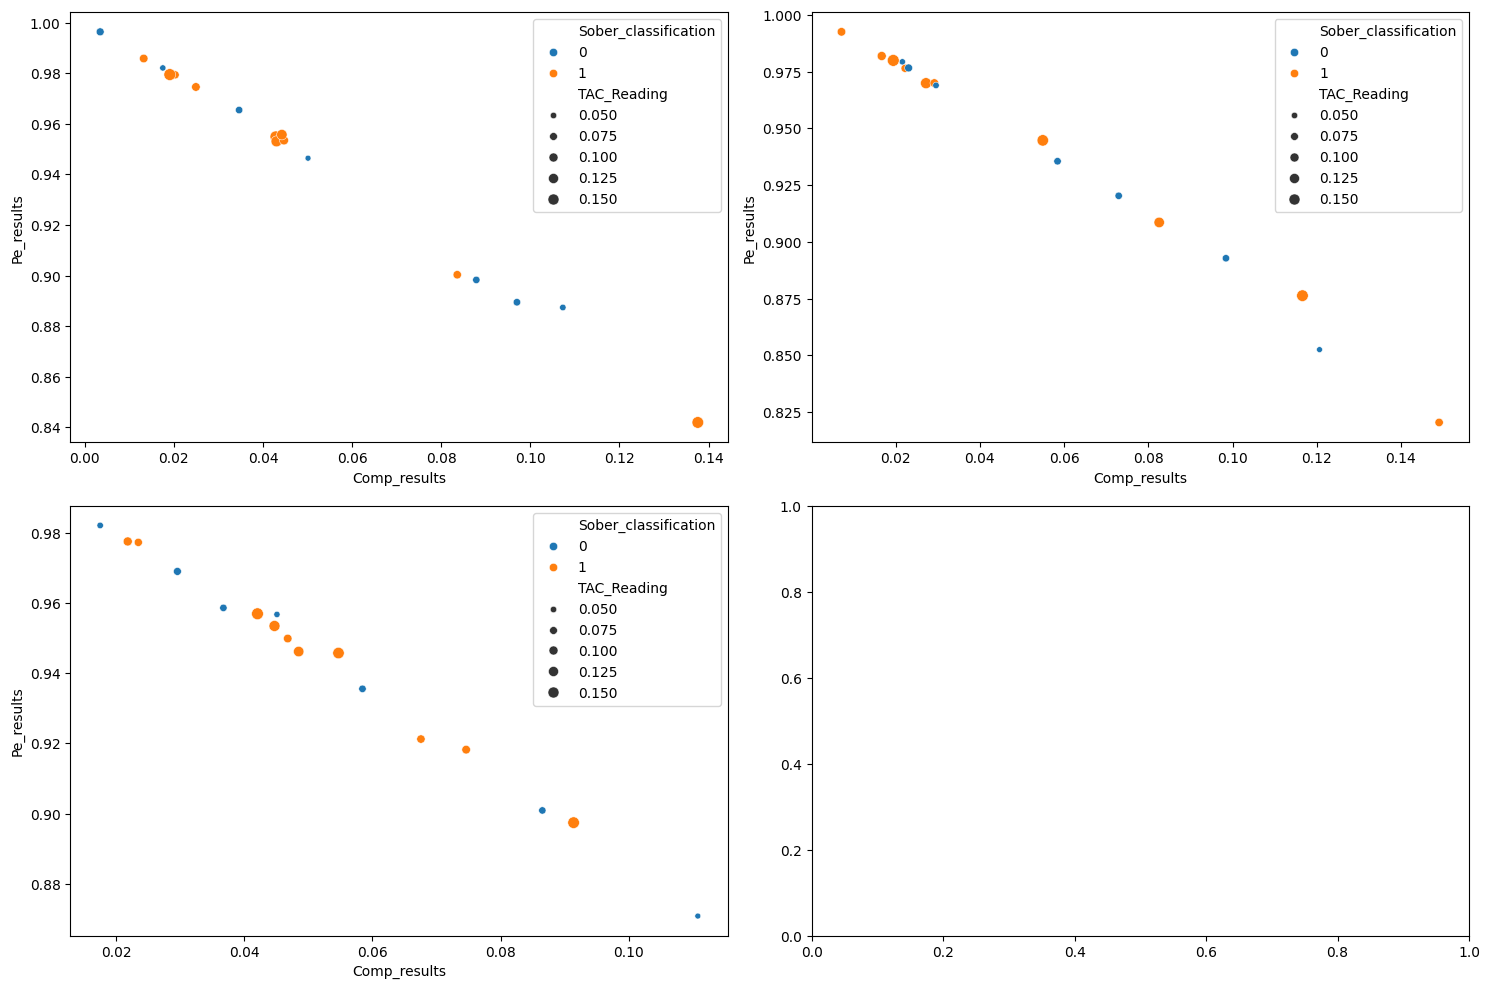

In [218]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_BU4707= ['0.046559 ','0.050424','0.065953','0.089122','0.080588','0.041689']

# Create DataFrame using lists
bu4707_x =  pd.DataFrame({'Pe_results': pe_results_x_bu4707, 'Comp_results': comp_results_x_bu4707,'TAC_Reading':list_BU4707})
bu4707_y =  pd.DataFrame({'Pe_results': pe_results_y_bu4707, 'Comp_results': comp_results_y_bu4707,'TAC_Reading':list_BU4707})
bu4707_z =  pd.DataFrame({'Pe_results': pe_results_z_bu4707, 'Comp_results': comp_results_z_bu4707,'TAC_Reading':list_BU4707})
#Conerting data type to float
bu4707_x['TAC_Reading'] = bu4707_x['TAC_Reading'].astype(float)
bu4707_y['TAC_Reading'] = bu4707_y['TAC_Reading'].astype(float)
bu4707_z['TAC_Reading'] = bu4707_z['TAC_Reading'].astype(float)

bu4707_x['Sober_classification'] = bu4707_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
bu4707_y['Sober_classification'] = bu4707_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
bu4707_z['Sober_classification'] = bu4707_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(bu4707_x)
print(bu4707_y)
print(bu4707_z)

#Scatter Plot
fig,axes = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(data=bk7610_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=bk7610_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=bk7610_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# **CC6740**

## X axis Pid CC6740

In [219]:
#Sorting the data in ascending order of TAC Reading
sort_CC6740 = merged_CC6740_df.sort_values(by=['TAC_Reading'])
sort_CC6740

time     pid         x         y         z   timestamp  \
830  1493809750974  CC6740 -0.000624  0.000140  0.013189  1493809750   
807  1493809750404  CC6740 -0.000309  0.000584  0.015105  1493809750   
806  1493809750377  CC6740  0.000658  0.002523  0.013189  1493809750   
805  1493809750352  CC6740  0.000160  0.000158  0.014626  1493809750   
804  1493809750325  CC6740 -0.000782  0.001132  0.013668  1493809750   
..             ...     ...       ...       ...       ...         ...   
336  1493776216577  CC6740  0.000455 -0.001240  0.027200  1493776216   
335  1493776216553  CC6740  0.000034 -0.001760  0.026812  1493776216   
334  1493776216528  CC6740 -0.001299  0.000118  0.025044  1493776216   
332  1493776216478  CC6740 -0.001587 -0.002772  0.026732  1493776216   
319  1493776216165  CC6740 -0.001688 -0.003279  0.028397  1493776216   

     TAC_Reading  
830     0.005040  
807     0.005040  
806     0.005040  
805     0.005040  
804     0.005040  
..           ...  
336     0.193018  
335     0.193018  
334     0.193018  
332     0.193018  
319     0.193018  

[831 rows x 7 columns]

In [220]:
# Using dataframe sort_CC6740: additional classification to check if 'TAC_Reading' value is >0.08 or not

sort_CC6740['Sober_classification'] = sort_CC6740['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_CC6740

time     pid         x         y         z   timestamp  \
830  1493809750974  CC6740 -0.000624  0.000140  0.013189  1493809750   
807  1493809750404  CC6740 -0.000309  0.000584  0.015105  1493809750   
806  1493809750377  CC6740  0.000658  0.002523  0.013189  1493809750   
805  1493809750352  CC6740  0.000160  0.000158  0.014626  1493809750   
804  1493809750325  CC6740 -0.000782  0.001132  0.013668  1493809750   
..             ...     ...       ...       ...       ...         ...   
336  1493776216577  CC6740  0.000455 -0.001240  0.027200  1493776216   
335  1493776216553  CC6740  0.000034 -0.001760  0.026812  1493776216   
334  1493776216528  CC6740 -0.001299  0.000118  0.025044  1493776216   
332  1493776216478  CC6740 -0.001587 -0.002772  0.026732  1493776216   
319  1493776216165  CC6740 -0.001688 -0.003279  0.028397  1493776216   

     TAC_Reading  Sober_classification  
830     0.005040                     0  
807     0.005040                     0  
806     0.005040                     0  
805     0.005040                     0  
804     0.005040                     0  
..           ...                   ...  
336     0.193018                     1  
335     0.193018                     1  
334     0.193018                     1  
332     0.193018                     1  
319     0.193018                     1  

[831 rows x 8 columns]

In [221]:
#Counting the number of TAC Reading in each segment
count_CC6740=sort_CC6740['TAC_Reading'].value_counts()
count_CC6740

TAC_Reading
0.054354    50
0.005040    40
0.035216    40
0.061028    40
0.060860    40
0.056929    40
0.055006    40
0.052713    40
0.005121    40
0.033952    40
0.095394    40
0.028566    40
0.025582    40
0.025327    40
0.015250    40
0.012700    40
0.009171    40
0.148161    40
0.018062    39
0.193018    37
0.041870    13
0.091390    12
Name: count, dtype: int64

In [222]:
#Resetting the index values after sorting
sort_CC6740.reset_index(drop=True)

time     pid         x         y         z   timestamp  \
0    1493809750974  CC6740 -0.000624  0.000140  0.013189  1493809750   
1    1493809750404  CC6740 -0.000309  0.000584  0.015105  1493809750   
2    1493809750377  CC6740  0.000658  0.002523  0.013189  1493809750   
3    1493809750352  CC6740  0.000160  0.000158  0.014626  1493809750   
4    1493809750325  CC6740 -0.000782  0.001132  0.013668  1493809750   
..             ...     ...       ...       ...       ...         ...   
826  1493776216577  CC6740  0.000455 -0.001240  0.027200  1493776216   
827  1493776216553  CC6740  0.000034 -0.001760  0.026812  1493776216   
828  1493776216528  CC6740 -0.001299  0.000118  0.025044  1493776216   
829  1493776216478  CC6740 -0.001587 -0.002772  0.026732  1493776216   
830  1493776216165  CC6740 -0.001688 -0.003279  0.028397  1493776216   

     TAC_Reading  Sober_classification  
0       0.005040                     0  
1       0.005040                     0  
2       0.005040                     0  
3       0.005040                     0  
4       0.005040                     0  
..           ...                   ...  
826     0.193018                     1  
827     0.193018                     1  
828     0.193018                     1  
829     0.193018                     1  
830     0.193018                     1  

[831 rows x 8 columns]

In [223]:
#Calculating the permutation entropy and complexity
TAC_Reading_CC6740 = pd.Series([50,40, 40, 40, 40,40, 40, 40, 40,40, 40, 40, 40,40, 40, 40, 40,40, 39, 37,13,12],name='count')
pe_results_x_cc6740= []
comp_results_x_cc6740=[]
i=0
for segment_value in TAC_Reading_CC6740:
  num_segs=len(sort_CC6740['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_CC6740[i-1]
  end_index = start_index + (segment_value)
  segment = sort_CC6740['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_x_cc6740.append(pe)
  comp_results_x_cc6740.append(comp)
  i+=1
print(pe_results_x_cc6740)
print(comp_results_x_cc6740)

[0.9555218419835317, 0.9914550895366187, 0.9372323588006969, 0.9839330922873067, 0.9416479092439677, 0.9960197593954816, 0.9662947062029361, 0.9914550895366188, 0.928886324378377, 0.9914550895366188, 0.9839330922873067, 0.9530718705618363, 0.9486283856538955, 0.9531930555127586, 0.9665297456127798, 0.9559153434933637, 0.9845517050767641, 0.9258937320312578, 0.9681231622657267, 0.9843820856830992, 0.9122066329329884, 0.9232196723355078]
[0.04442199405459335, 0.008397768877605483, 0.061767325812098574, 0.015965351963811325, 0.05707467284875902, 0.00397411284652309, 0.033420024066380644, 0.008397768877605242, 0.07562338385685885, 0.008397768877605726, 0.015965351963811325, 0.043037122446127604, 0.04608933542118093, 0.042040661664328606, 0.03191058160815995, 0.042437092281749134, 0.015097119514571749, 0.06684923628815287, 0.03147611860946581, 0.015623665579537196, 0.07775050781421497, 0.06762979927246475]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Y axis Pid CC6740

In [224]:
#Calculating the permutation entropy and complexity
pe_results_y_cc6740= []
comp_results_y_cc6740=[]
i=0
for segment_value in TAC_Reading_CC6740:
  num_segs=len(sort_CC6740['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_CC6740[i-1]
  end_index = start_index + (segment_value)
  segment = sort_CC6740['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_y_cc6740.append(pe)
  comp_results_y_cc6740.append(comp)
  i+=1
print(pe_results_y_cc6740)
print(comp_results_y_cc6740)

[0.9774100140524925, 0.9689890597188715, 0.959861400562769, 0.9799870352179012, 0.9472136701561004, 0.9793701029900674, 0.9765389914328532, 0.9984790735015731, 0.908760689723245, 0.963337378812487, 0.954914252440094, 0.9719463871093206, 0.9503495825812311, 0.9465247104627478, 0.9914550895366187, 0.9606430252965518, 0.9939144036427102, 0.9719463871093205, 0.9747016515811021, 0.9611245317985523, 0.9162695888499091, 0.9464119282150146]
[0.02160968497815597, 0.029568366191570696, 0.039168194876133, 0.019417615265194914, 0.05270967913664204, 0.021582714875133954, 0.02209660397823804, 0.001486760693056, 0.09306154544713904, 0.03647340227689505, 0.0428550605474601, 0.026474747404678502, 0.04690791542841558, 0.04912042746272095, 0.008397768877605967, 0.03788378349458827, 0.00593285091994129, 0.026474747404678735, 0.02567841210102819, 0.04007470137211449, 0.07272234220308464, 0.049641212339956504]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Z axis Pid CC6740

In [225]:
#Calculating the permutation entropy and complexity
pe_results_z_cc6740= []
comp_results_z_cc6740=[]
i=0
for segment_value in TAC_Reading_CC6740:
  num_segs=len(sort_CC6740['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_CC6740[i-1]
  end_index = start_index + (segment_value)
  segment = sort_CC6740['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_z_cc6740.append(pe)
  comp_results_z_cc6740.append(comp)
  i+=1
print(pe_results_z_cc6740)
print(comp_results_z_cc6740)

[0.9673122876463133, 0.9860384480400782, 0.9785164507907663, 0.9875090324672131, 0.9672834358818927, 0.970859376061799, 0.9984790735015732, 0.9765110569681833, 0.8967739845452587, 0.9914550895366188, 0.9884977621461697, 0.8954347827421132, 0.9020644102085644, 0.9700057238624976, 0.9884977621461697, 0.9939144036427102, 0.9839330922873069, 0.9592003753340864, 0.9774975149125346, 0.9961439357898729, 0.933510035736515, 0.9464119282150146]
[0.03172045666517606, 0.014047963107715307, 0.021530082698218784, 0.011907627122557394, 0.033152095489666494, 0.029228299463340653, 0.001486760693055756, 0.022224166470248847, 0.10171007868055765, 0.008397768877605726, 0.011610798784122935, 0.09875012789181209, 0.0862565811878348, 0.02916907395689187, 0.011610798784122935, 0.00593285091994129, 0.015965351963811082, 0.0428131817790898, 0.021566454392664337, 0.0037869144134090706, 0.061807296679243943, 0.04964121233995604]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Permutation Entropy and Complexity plots

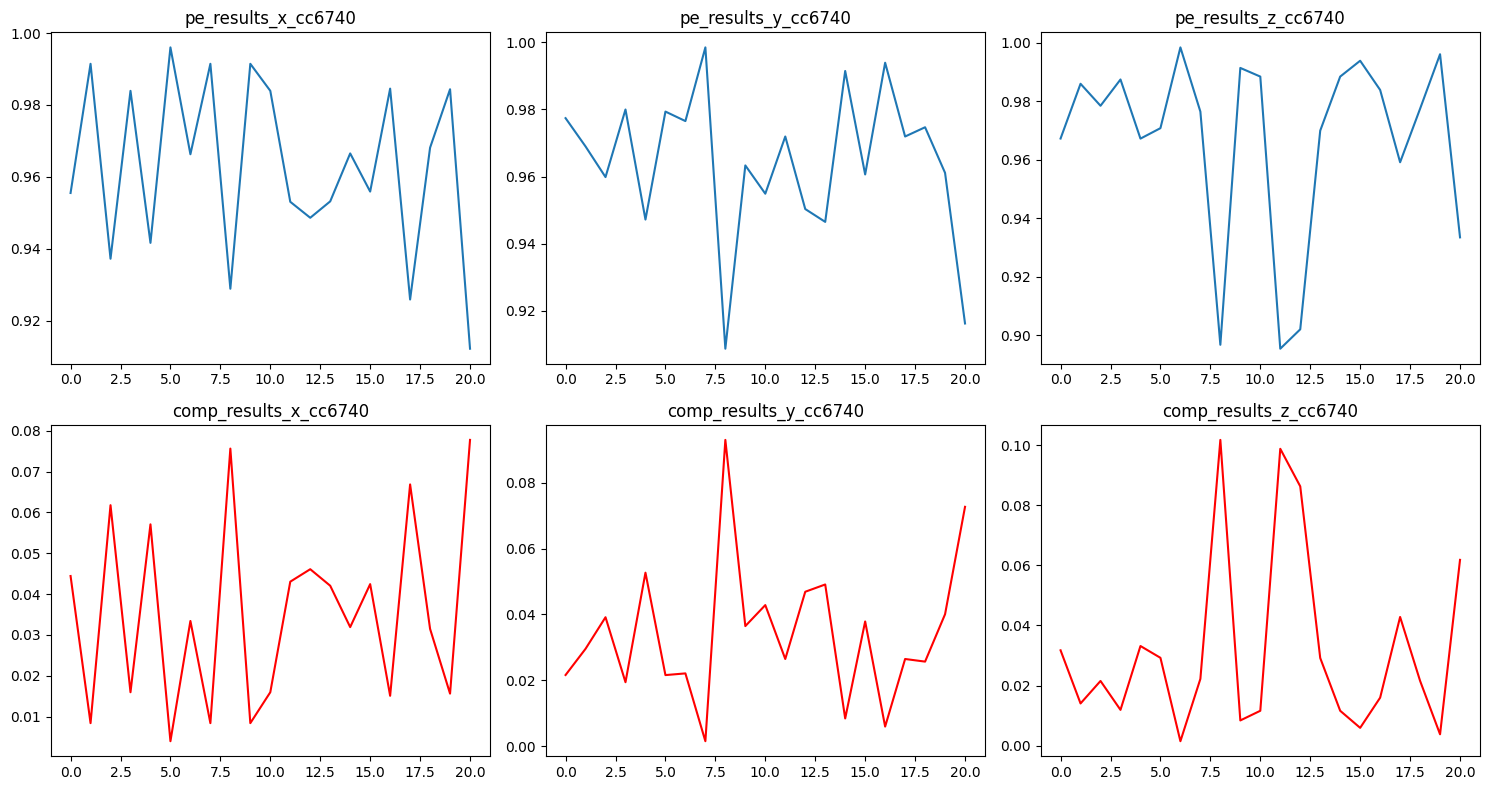

In [226]:
#Plotting the permutation entropy and complexity graphs
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_cc6740[0:21], ax=axes[0, 0])
sns.lineplot(data=pe_results_y_cc6740[0:21], ax=axes[0, 1])
sns.lineplot(data=pe_results_z_cc6740[0:21], ax=axes[0, 2])

# Plot comp_results
sns.lineplot(data=comp_results_x_cc6740[0:21], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_cc6740[0:21], ax=axes[1, 1],color='r')
sns.lineplot(data=comp_results_z_cc6740[0:21], ax=axes[1, 2],color='r')

# Set titles
axes[0, 0].set_title('pe_results_x_cc6740')
axes[0, 1].set_title('pe_results_y_cc6740')
axes[0, 2].set_title('pe_results_z_cc6740')
axes[1, 0].set_title('comp_results_x_cc6740')
axes[1, 1].set_title('comp_results_y_cc6740')
axes[1, 2].set_title('comp_results_z_cc6740')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

    Pe_results  Comp_results  TAC_Reading  Sober_classification
0     0.955522      0.044422     0.054354                     0
1     0.991455      0.008398     0.005040                     0
2     0.937232      0.061767     0.035216                     0
3     0.983933      0.015965     0.061028                     0
4     0.941648      0.057075     0.060860                     0
5     0.996020      0.003974     0.056929                     0
6     0.966295      0.033420     0.055006                     0
7     0.991455      0.008398     0.052713                     0
8     0.928886      0.075623     0.005121                     0
9     0.991455      0.008398     0.033952                     0
10    0.983933      0.015965     0.095394                     1
11    0.953072      0.043037     0.028566                     0
12    0.948628      0.046089     0.025582                     0
13    0.953193      0.042041     0.025327                     0
14    0.966530      0.031911     0.01525

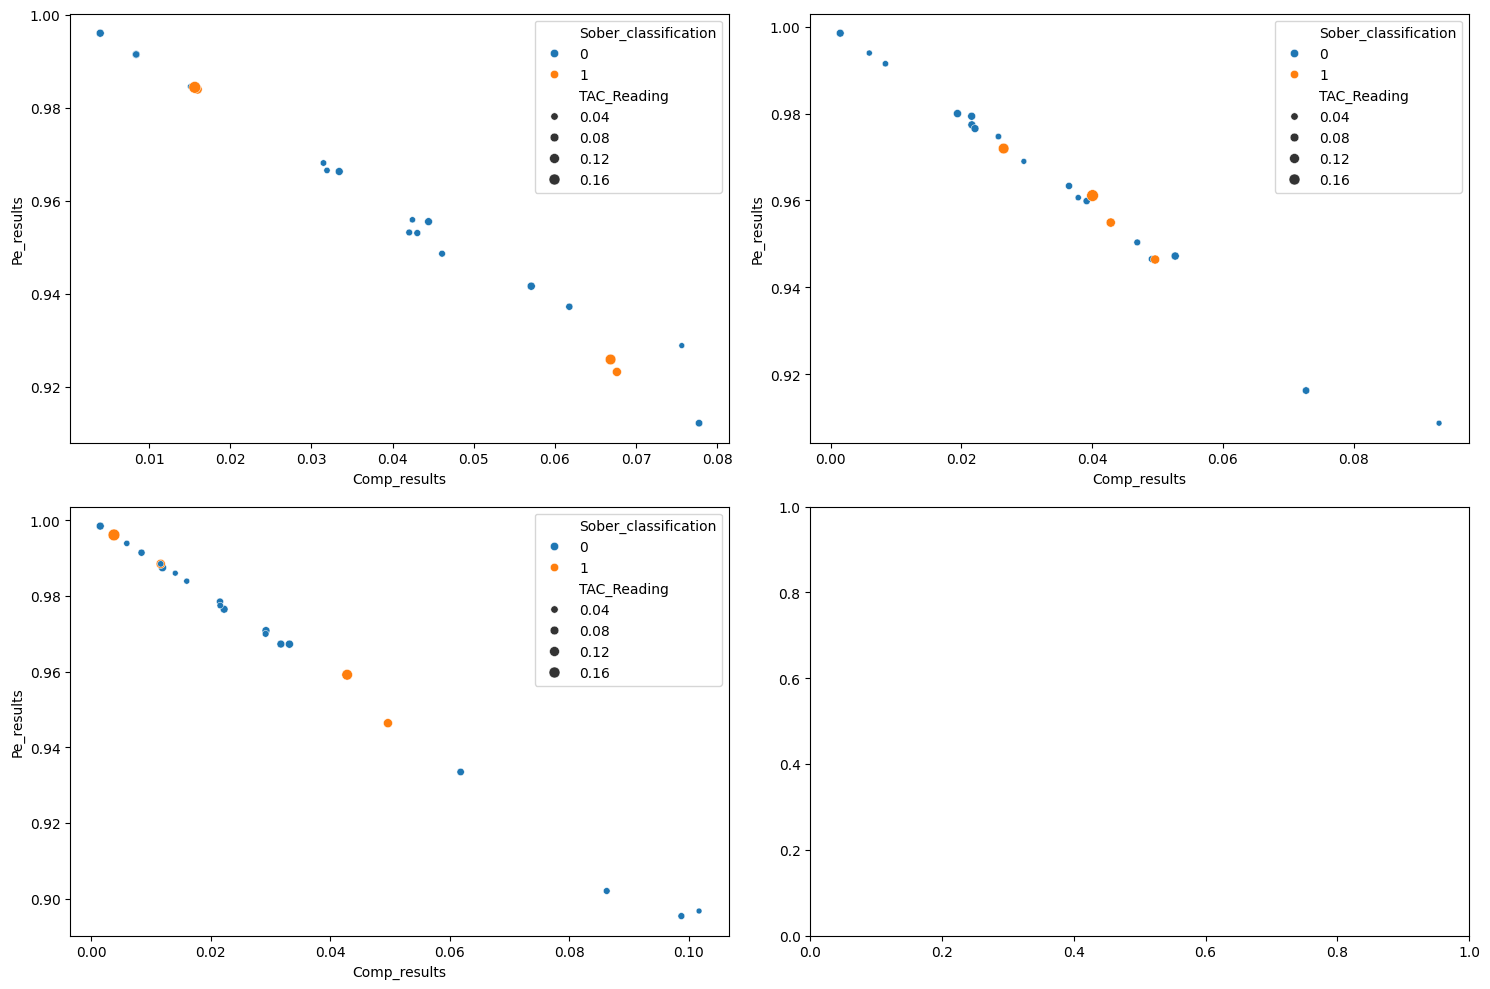

In [227]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_CC6740= ['0.054354','0.005040','0.035216','0.061028','0.060860','0.056929','0.055006','0.052713','0.005121','0.033952','0.095394','0.028566','0.025582','0.025327','0.015250','0.012700','0.009171','0.148161','0.018062','0.193018','0.041870','0.091390']

# Create DataFrame using lists
cc6740_x =  pd.DataFrame({'Pe_results': pe_results_x_cc6740, 'Comp_results': comp_results_x_cc6740,'TAC_Reading':list_CC6740})
cc6740_y =  pd.DataFrame({'Pe_results': pe_results_y_cc6740, 'Comp_results': comp_results_y_cc6740,'TAC_Reading':list_CC6740})
cc6740_z =  pd.DataFrame({'Pe_results': pe_results_z_cc6740, 'Comp_results': comp_results_z_cc6740,'TAC_Reading':list_CC6740})
#Conerting data type to float
cc6740_x['TAC_Reading'] = cc6740_x['TAC_Reading'].astype(float)
cc6740_y['TAC_Reading'] = cc6740_y['TAC_Reading'].astype(float)
cc6740_z['TAC_Reading'] = cc6740_z['TAC_Reading'].astype(float)

cc6740_x['Sober_classification'] = cc6740_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
cc6740_y['Sober_classification'] = cc6740_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
cc6740_z['Sober_classification'] = cc6740_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(cc6740_x)
print(cc6740_y)
print(cc6740_z)

#Scatter Plot
fig,axes = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(data=cc6740_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=cc6740_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=cc6740_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#**DC6359**

## X axis Pid DC6359

In [228]:
#Sorting the data in ascending order of TAC Reading
sort_DC6359 = merged_DC6359_df.sort_values(by=['TAC_Reading'])
sort_DC6359

time     pid         x         y         z   timestamp  \
200  1493764665265  DC6359  0.000017 -0.000040  0.000215  1493764665   
207  1493764665449  DC6359  0.000017 -0.000040  0.000125  1493764665   
206  1493764665424  DC6359 -0.000025  0.000215  0.000365  1493764665   
204  1493764665369  DC6359 -0.000245 -0.000142  0.000208  1493764665   
203  1493764665345  DC6359  0.000005 -0.000150  0.000193  1493764665   
..             ...     ...       ...       ...       ...         ...   
23   1493748079609  DC6359 -0.000155  0.000422  0.000300  1493748079   
22   1493748079590  DC6359 -0.000022  0.000160  0.000160  1493748079   
21   1493748079557  DC6359  0.000118  0.000270  0.000353  1493748079   
28   1493748079745  DC6359  0.000295 -0.000548 -0.000180  1493748079   
0    1493748079007  DC6359  0.000202 -0.000158 -0.000265  1493748079   

     TAC_Reading  
200     0.043772  
207     0.043772  
206     0.043772  
204     0.043772  
203     0.043772  
..           ...  
23      0.122072  
22      0.122072  
21      0.122072  
28      0.122072  
0       0.122072  

[304 rows x 7 columns]

In [229]:
# Using dataframe sort_DC6359: additional classification to check if 'TAC_Reading' value is >0.08 or not

sort_DC6359['Sober_classification'] = sort_DC6359['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_DC6359

time     pid         x         y         z   timestamp  \
200  1493764665265  DC6359  0.000017 -0.000040  0.000215  1493764665   
207  1493764665449  DC6359  0.000017 -0.000040  0.000125  1493764665   
206  1493764665424  DC6359 -0.000025  0.000215  0.000365  1493764665   
204  1493764665369  DC6359 -0.000245 -0.000142  0.000208  1493764665   
203  1493764665345  DC6359  0.000005 -0.000150  0.000193  1493764665   
..             ...     ...       ...       ...       ...         ...   
23   1493748079609  DC6359 -0.000155  0.000422  0.000300  1493748079   
22   1493748079590  DC6359 -0.000022  0.000160  0.000160  1493748079   
21   1493748079557  DC6359  0.000118  0.000270  0.000353  1493748079   
28   1493748079745  DC6359  0.000295 -0.000548 -0.000180  1493748079   
0    1493748079007  DC6359  0.000202 -0.000158 -0.000265  1493748079   

     TAC_Reading  Sober_classification  
200     0.043772                     0  
207     0.043772                     0  
206     0.043772                     0  
204     0.043772                     0  
203     0.043772                     0  
..           ...                   ...  
23      0.122072                     1  
22      0.122072                     1  
21      0.122072                     1  
28      0.122072                     1  
0       0.122072                     1  

[304 rows x 8 columns]

In [230]:
#Resetting the index values after sorting
sort_DC6359.reset_index(drop=True)

time     pid         x         y         z   timestamp  \
0    1493764665265  DC6359  0.000017 -0.000040  0.000215  1493764665   
1    1493764665449  DC6359  0.000017 -0.000040  0.000125  1493764665   
2    1493764665424  DC6359 -0.000025  0.000215  0.000365  1493764665   
3    1493764665369  DC6359 -0.000245 -0.000142  0.000208  1493764665   
4    1493764665345  DC6359  0.000005 -0.000150  0.000193  1493764665   
..             ...     ...       ...       ...       ...         ...   
299  1493748079609  DC6359 -0.000155  0.000422  0.000300  1493748079   
300  1493748079590  DC6359 -0.000022  0.000160  0.000160  1493748079   
301  1493748079557  DC6359  0.000118  0.000270  0.000353  1493748079   
302  1493748079745  DC6359  0.000295 -0.000548 -0.000180  1493748079   
303  1493748079007  DC6359  0.000202 -0.000158 -0.000265  1493748079   

     TAC_Reading  Sober_classification  
0       0.043772                     0  
1       0.043772                     0  
2       0.043772                     0  
3       0.043772                     0  
4       0.043772                     0  
..           ...                   ...  
299     0.122072                     1  
300     0.122072                     1  
301     0.122072                     1  
302     0.122072                     1  
303     0.122072                     1  

[304 rows x 8 columns]

In [231]:
##Counting the number of TAC Reading in each segment
count_DC6359=sort_DC6359['TAC_Reading'].value_counts()
count_DC6359

TAC_Reading
0.043772    38
0.045017    38
0.049240    38
0.050705    38
0.053329    38
0.058219    38
0.068986    38
0.122072    38
Name: count, dtype: int64

In [232]:
#Calculating the permutation entropy and complexity
TAC_Reading_DC6359 = pd.Series([38,38,38,38,38,38,38,38], name='count')
pe_results_x_dc6359= []
comp_results_x_dc6359=[]
i=0
for segment_value in TAC_Reading_DC6359:
  num_segs=len(sort_DC6359['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_DC6359[i-1]
  end_index = start_index + (segment_value)
  segment = sort_DC6359['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_x_dc6359.append(pe)
  comp_results_x_dc6359.append(comp)
  i+=1
print(pe_results_x_dc6359)
print(comp_results_x_dc6359)

[0.9858245695739678, 0.9024237353655703, 0.986868228679533, 0.9801070035498418, 0.9645808441046619, 0.9298812211686729, 0.9925857947036592, 0.9832286269064269]
[0.013229651759662547, 0.09362928551597681, 0.012945750296497742, 0.018980995030395967, 0.03378141954106246, 0.0681084670337854, 0.007118477630245634, 0.015722461889949347]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Y axis Pid DC6359

In [233]:
#Calculating the permutation entropy and complexity
pe_results_y_dc6359= []
comp_results_y_dc6359=[]
i=0
for segment_value in TAC_Reading_DC6359:
  num_segs=len(sort_DC6359['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_DC6359[i-1]
  end_index = start_index + (segment_value)
  segment = sort_DC6359['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_y_dc6359.append(pe)
  comp_results_y_dc6359.append(comp)
  i+=1
print(pe_results_y_dc6359)
print(comp_results_y_dc6359)

[0.947455858485499, 0.9276606751335724, 0.9692935913627069, 0.9794557973093504, 0.9801070035498418, 0.9614592207480765, 0.9165013526933709, 0.9769853801932566]
[0.05178326385681319, 0.06673988938264164, 0.03073359649434883, 0.021254777216247907, 0.018980995030395967, 0.036917596919451394, 0.0846941357983413, 0.022218453462674304]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Z axis Pid DC6359

In [234]:
#Calculating the permutation entropy and complexity
pe_results_z_dc6359= []
comp_results_z_dc6359=[]
i=0
for segment_value in TAC_Reading_DC6359:
  num_segs=len(sort_DC6359['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_DC6359[i-1]
  end_index = start_index + (segment_value)
  segment = sort_DC6359['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_z_dc6359.append(pe)
  comp_results_z_dc6359.append(comp)
  i+=1
print(pe_results_z_dc6359)
print(comp_results_z_dc6359)

[0.986868228679533, 0.8721982387314726, 0.9108132730486184, 0.986868228679533, 0.85508463529336, 0.9684980294119769, 0.9112793630083249, 0.9588632780805357]
[0.012945750296497742, 0.10832781013377303, 0.08609445713166436, 0.012945750296497742, 0.12936649396533162, 0.029399258940240643, 0.08800621589674175, 0.03928292915465154]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Permutation Entropy and Complexity Plots

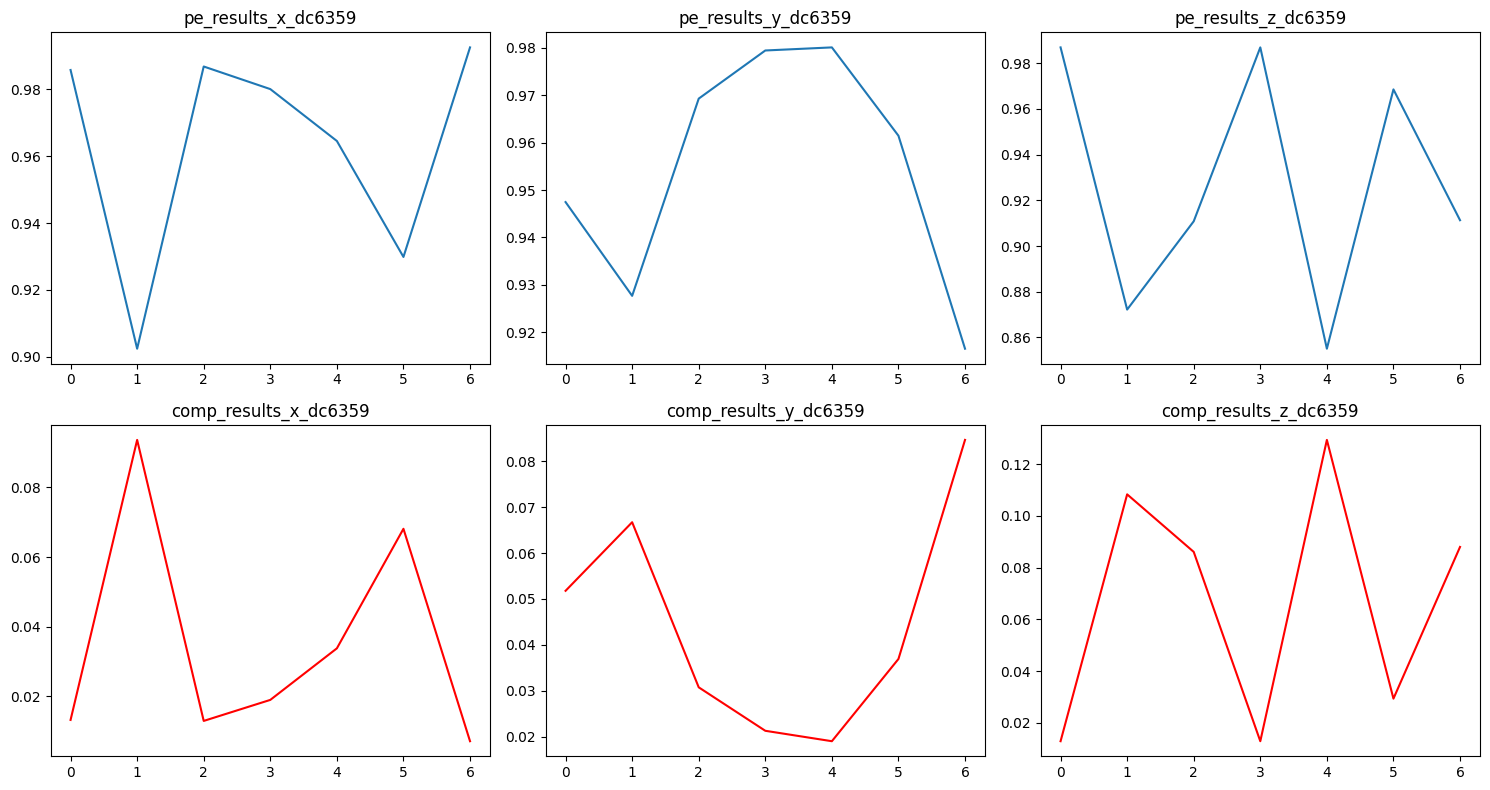

In [235]:
#Plotting the permutation entropy and complexity
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_dc6359[0:7], ax=axes[0, 0])
sns.lineplot(data=pe_results_y_dc6359[0:7], ax=axes[0, 1])
sns.lineplot(data=pe_results_z_dc6359[0:7], ax=axes[0, 2])

# Plot comp_results
sns.lineplot(data=comp_results_x_dc6359[0:7], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_dc6359[0:7], ax=axes[1, 1],color='r')
sns.lineplot(data=comp_results_z_dc6359[0:7], ax=axes[1, 2],color='r')

# Set titles
axes[0, 0].set_title('pe_results_x_dc6359')
axes[0, 1].set_title('pe_results_y_dc6359')
axes[0, 2].set_title('pe_results_z_dc6359')
axes[1, 0].set_title('comp_results_x_dc6359')
axes[1, 1].set_title('comp_results_y_dc6359')
axes[1, 2].set_title('comp_results_z_dc6359')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.985825      0.013230     0.043772                     0
1    0.902424      0.093629     0.045017                     0
2    0.986868      0.012946     0.049240                     0
3    0.980107      0.018981     0.050705                     0
4    0.964581      0.033781     0.053329                     0
5    0.929881      0.068108     0.058219                     0
6    0.992586      0.007118     0.068986                     0
7    0.983229      0.015722     0.122072                     1
   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.947456      0.051783     0.043772                     0
1    0.927661      0.066740     0.045017                     0
2    0.969294      0.030734     0.049240                     0
3    0.979456      0.021255     0.050705                     0
4    0.980107      0.018981     0.053329                     0
5    0.961459      0.036918     0.058219               

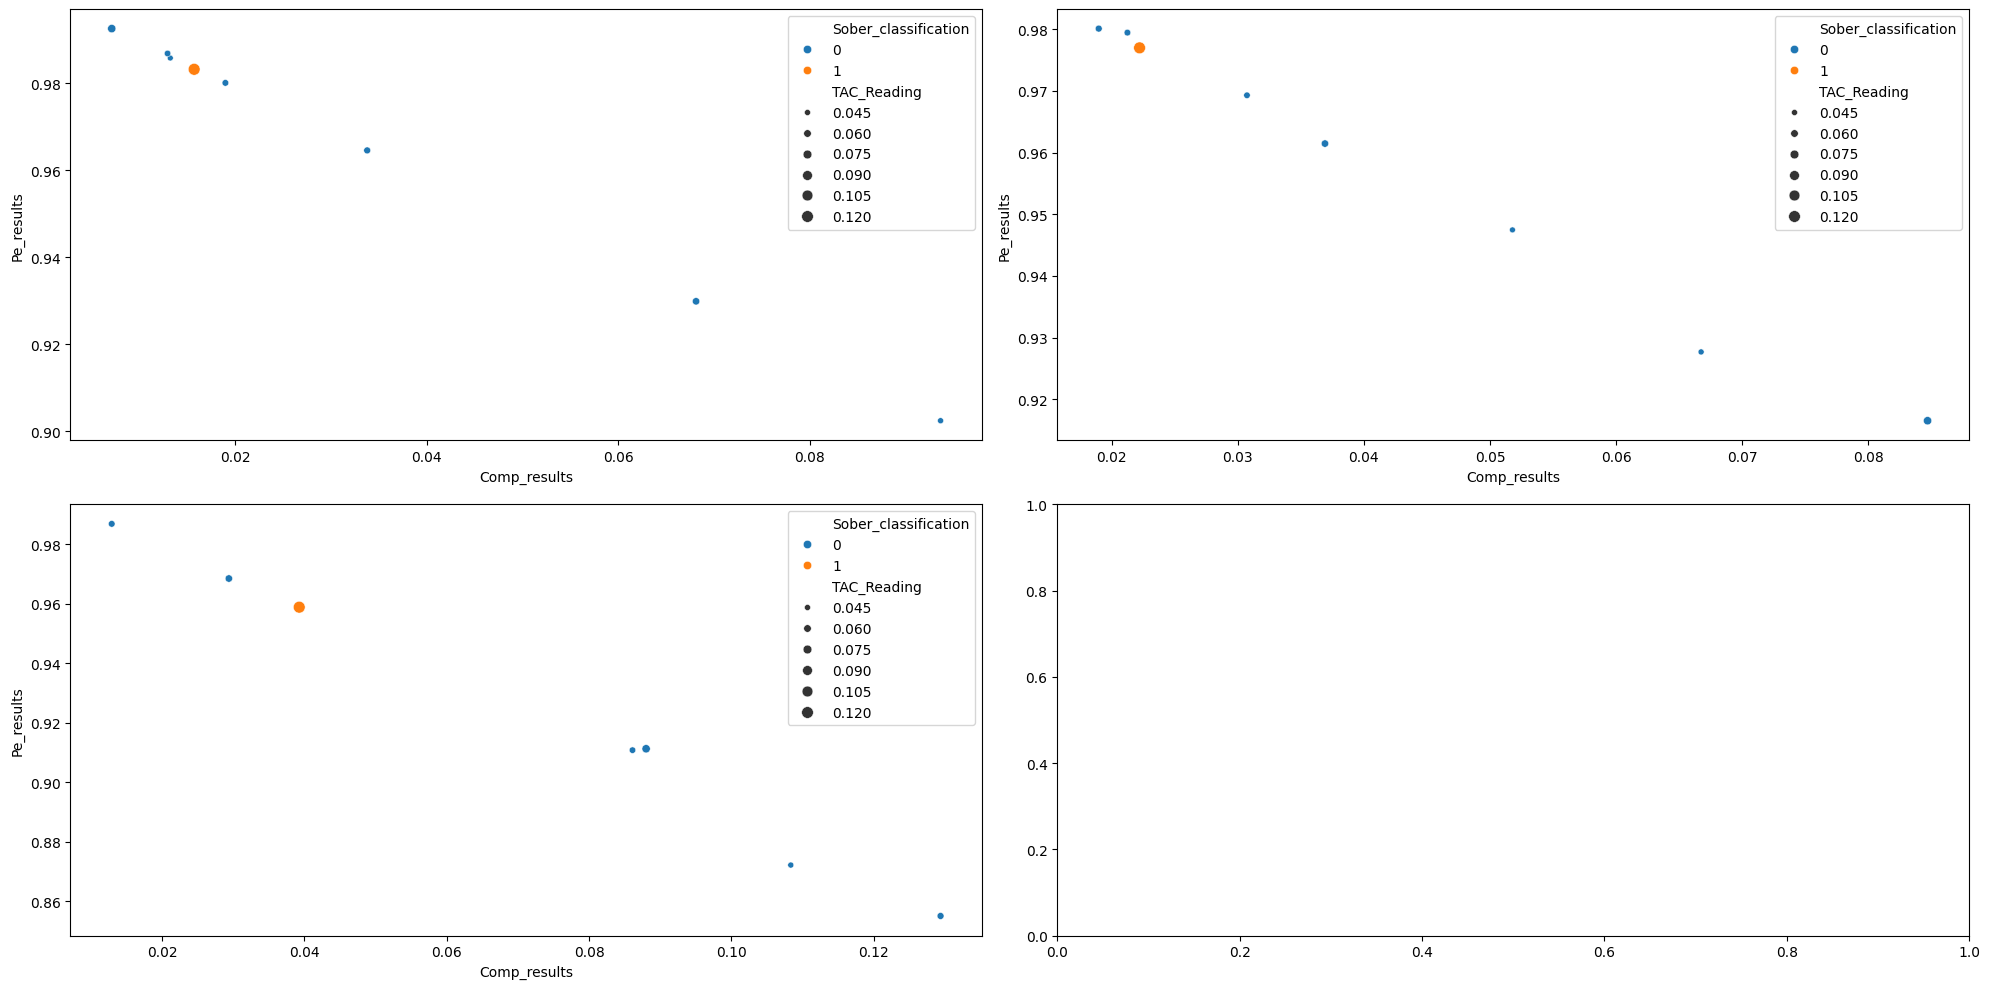

In [236]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_DC6359= ['0.043772','0.045017','0.049240','0.050705','0.053329','0.058219','0.068986','0.122072']

# Create DataFrame using lists
dc6359_x =  pd.DataFrame({'Pe_results': pe_results_x_dc6359, 'Comp_results': comp_results_x_dc6359,'TAC_Reading':list_DC6359})
dc6359_y =  pd.DataFrame({'Pe_results': pe_results_y_dc6359, 'Comp_results': comp_results_y_dc6359,'TAC_Reading':list_DC6359})
dc6359_z =  pd.DataFrame({'Pe_results': pe_results_z_dc6359, 'Comp_results': comp_results_z_dc6359,'TAC_Reading':list_DC6359})
#Conerting data type to float
dc6359_x['TAC_Reading'] = dc6359_x['TAC_Reading'].astype(float)
dc6359_y['TAC_Reading'] = dc6359_y['TAC_Reading'].astype(float)
dc6359_z['TAC_Reading'] = dc6359_z['TAC_Reading'].astype(float)

dc6359_x['Sober_classification'] = dc6359_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
dc6359_y['Sober_classification'] = dc6359_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
dc6359_z['Sober_classification'] = dc6359_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(dc6359_x)
print(dc6359_y)
print(dc6359_z)

#Scatter Plot
fig,axes = plt.subplots(2, 2, figsize=(20, 10))

sns.scatterplot(data=dc6359_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=dc6359_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=dc6359_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# DK3500

## X axis Pid DK3500

In [237]:
#Sorting the data in ascending order of TAC Reading
sort_DK3500 = merged_DK3500_df.sort_values(by=['TAC_Reading'])
sort_DK3500

time     pid         x         y         z   timestamp  \
0   1493745545015  DK3500 -0.000373 -0.002302  0.000915  1493745545   
22  1493745545567  DK3500 -0.000213 -0.001230 -0.002022  1493745545   
23  1493745545592  DK3500  0.000045 -0.000907 -0.002083  1493745545   
24  1493745545617  DK3500  0.001187 -0.000630 -0.000333  1493745545   
25  1493745545641  DK3500  0.001940 -0.000470  0.001280  1493745545   
..            ...     ...       ...       ...       ...         ...   
64  1493763898604  DK3500 -0.000278 -0.000530  0.000220  1493763898   
62  1493763898553  DK3500 -0.000893 -0.000228 -0.001275  1493763898   
61  1493763898528  DK3500  0.000185  0.000827  0.001475  1493763898   
59  1493763898478  DK3500  0.001020  0.001060 -0.001370  1493763898   
68  1493763898704  DK3500 -0.002392 -0.004077 -0.002917  1493763898   

    TAC_Reading  
0      0.003018  
22     0.003018  
23     0.003018  
24     0.003018  
25     0.003018  
..          ...  
64     0.071151  
62     0.071151  
61     0.071151  
59     0.071151  
68     0.071151  

[637 rows x 7 columns]

In [238]:
# Using dataframe sort_DK3500: additional classification to check if 'TAC_Reading' value is >0.08 or not

sort_DK3500['Sober_classification'] = sort_DK3500['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_DK3500

time     pid         x         y         z   timestamp  \
0   1493745545015  DK3500 -0.000373 -0.002302  0.000915  1493745545   
22  1493745545567  DK3500 -0.000213 -0.001230 -0.002022  1493745545   
23  1493745545592  DK3500  0.000045 -0.000907 -0.002083  1493745545   
24  1493745545617  DK3500  0.001187 -0.000630 -0.000333  1493745545   
25  1493745545641  DK3500  0.001940 -0.000470  0.001280  1493745545   
..            ...     ...       ...       ...       ...         ...   
64  1493763898604  DK3500 -0.000278 -0.000530  0.000220  1493763898   
62  1493763898553  DK3500 -0.000893 -0.000228 -0.001275  1493763898   
61  1493763898528  DK3500  0.000185  0.000827  0.001475  1493763898   
59  1493763898478  DK3500  0.001020  0.001060 -0.001370  1493763898   
68  1493763898704  DK3500 -0.002392 -0.004077 -0.002917  1493763898   

    TAC_Reading  Sober_classification  
0      0.003018                     0  
22     0.003018                     0  
23     0.003018                     0  
24     0.003018                     0  
25     0.003018                     0  
..          ...                   ...  
64     0.071151                     0  
62     0.071151                     0  
61     0.071151                     0  
59     0.071151                     0  
68     0.071151                     0  

[637 rows x 8 columns]

In [239]:
#Resetting the index values after sorting
sort_DK3500.reset_index(drop=True)

time     pid         x         y         z   timestamp  \
0    1493745545015  DK3500 -0.000373 -0.002302  0.000915  1493745545   
1    1493745545567  DK3500 -0.000213 -0.001230 -0.002022  1493745545   
2    1493745545592  DK3500  0.000045 -0.000907 -0.002083  1493745545   
3    1493745545617  DK3500  0.001187 -0.000630 -0.000333  1493745545   
4    1493745545641  DK3500  0.001940 -0.000470  0.001280  1493745545   
..             ...     ...       ...       ...       ...         ...   
632  1493763898604  DK3500 -0.000278 -0.000530  0.000220  1493763898   
633  1493763898553  DK3500 -0.000893 -0.000228 -0.001275  1493763898   
634  1493763898528  DK3500  0.000185  0.000827  0.001475  1493763898   
635  1493763898478  DK3500  0.001020  0.001060 -0.001370  1493763898   
636  1493763898704  DK3500 -0.002392 -0.004077 -0.002917  1493763898   

     TAC_Reading  Sober_classification  
0       0.003018                     0  
1       0.003018                     0  
2       0.003018                     0  
3       0.003018                     0  
4       0.003018                     0  
..           ...                   ...  
632     0.071151                     0  
633     0.071151                     0  
634     0.071151                     0  
635     0.071151                     0  
636     0.071151                     0  

[637 rows x 8 columns]

In [240]:
#Counting the number of TAC Reading in each segment
count_DK3500=sort_DK3500['TAC_Reading'].value_counts()
count_DK3500

TAC_Reading
0.011943    41
0.003018    40
0.010660    40
0.011012    40
0.011030    40
0.011820    40
0.012633    40
0.013744    40
0.014697    40
0.016433    40
0.018886    40
0.021548    40
0.049382    40
0.071151    40
0.013212    39
0.023774    37
Name: count, dtype: int64

In [241]:
#Calculating the permutation entropy and complexity
TAC_Reading_DK3500 = pd.Series([41,40,40,40,40,40,40,40,40,40,40,40,40,40,39,37],name='count')
pe_results_x_dk3500= []
comp_results_x_dk3500=[]
i=0
for segment_value in TAC_Reading_DK3500:
  num_segs=len(sort_DK3500['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_DK3500[i-1]
  end_index = start_index + (segment_value)
  segment = sort_DK3500['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_x_dk3500.append(pe)
  comp_results_x_dk3500.append(comp)
  i+=1
print(pe_results_x_dk3500)
print(comp_results_x_dk3500)

[0.8503254293119663, 0.9689890597188715, 0.9303730673416911, 0.9914550895366187, 0.9939144036427102, 0.9745703937213607, 0.9893497337838472, 0.9799870352179013, 0.9748054331312045, 0.9710944154716428, 0.9960197593954816, 0.9546357054752236, 0.9820923909706727, 0.8757243507869304, 0.9520963461497677, 0.9721862409248937]
[0.12899652190984556, 0.029568366191570696, 0.058655662933799764, 0.008397768877605967, 0.005932850919940804, 0.024940115253464165, 0.01033804032152148, 0.019417615265194674, 0.025849397732544008, 0.02771063689562163, 0.00397411284652309, 0.04688635381599741, 0.017515590606529255, 0.11861489221324309, 0.04848160853142465, 0.02791066949323993]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Y axis Pid DK3500

In [242]:
#Calculating the permutation entropy and complexity
pe_results_y_dk3500= []
comp_results_y_dk3500=[]
i=0
for segment_value in TAC_Reading_DK3500:
  num_segs=len(sort_DK3500['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_DK3500[i-1]
  end_index = start_index + (segment_value)
  segment = sort_DK3500['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_y_dk3500.append(pe)
  comp_results_y_dk3500.append(comp)
  i+=1
print(pe_results_y_dk3500)
print(comp_results_y_dk3500)

[0.9274116103775164, 0.9793701029900673, 0.970859376061799, 0.9482303342997265, 0.9407959376062901, 0.950349582581231, 0.9482303342997266, 0.9939144036427102, 0.9655410159338235, 0.9765110569681833, 0.9799870352179012, 0.9527950041585894, 0.9899683465733048, 0.970859376061799, 0.9909263008020207, 0.966412021357377]
[0.06607307238359846, 0.021582714875134194, 0.029228299463340178, 0.05234559817344522, 0.05824284561205533, 0.04690791542841581, 0.05234559817344499, 0.005932850919940804, 0.032179518379740146, 0.022224166470248368, 0.019417615265194914, 0.04832891776140477, 0.009461402396527584, 0.029228299463340178, 0.009266409772262068, 0.030897108237284438]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Z axis Pid DK3500

In [243]:
#Calculating the permutation entropy and complexity
pe_results_z_dk3500= []
comp_results_z_dk3500=[]
i=0
for segment_value in TAC_Reading_DK3500:
  num_segs=len(sort_DK3500['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_DK3500[i-1]
  end_index = start_index + (segment_value)
  segment = sort_DK3500['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_z_dk3500.append(pe)
  comp_results_z_dk3500.append(comp)
  i+=1
print(pe_results_z_dk3500)
print(comp_results_z_dk3500)

[0.9110300360880268, 0.9422230144783984, 0.9662947062029361, 0.9352916955538741, 0.9765110569681833, 0.9459340321379602, 0.9893497337838475, 0.9863924063933984, 0.99356044528939, 0.9960197593954816, 0.9875090324672131, 0.9914550895366188, 0.954914252440094, 0.9322852106780216, 0.9862382614875129, 0.9591721038745084]
[0.08160223334271904, 0.0557473658913595, 0.033420024066380644, 0.07044980806515819, 0.022224166470248368, 0.05169630954765313, 0.010338040321520999, 0.013538320501349663, 0.006449163665318961, 0.003974112846523577, 0.011907627122557876, 0.008397768877605242, 0.0428550605474601, 0.06523787536861558, 0.013699810936188814, 0.03850581645345719]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Permutation Entropy and Complexity Plots

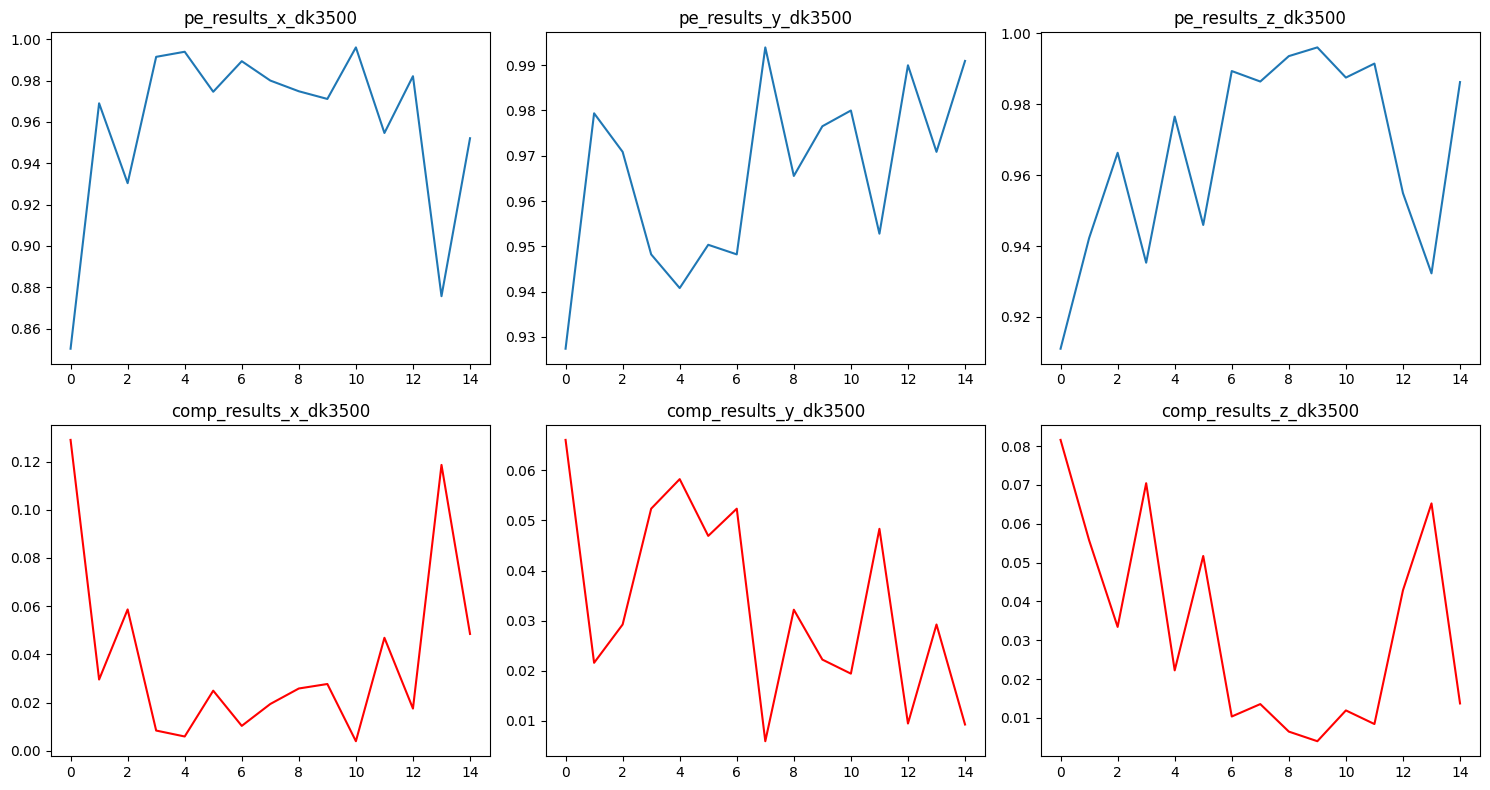

In [244]:
#Plotting the permutation entropy and complexity
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_dk3500[0:15], ax=axes[0, 0])
sns.lineplot(data=pe_results_y_dk3500[0:15], ax=axes[0, 1])
sns.lineplot(data=pe_results_z_dk3500[0:15], ax=axes[0, 2])

# Plot comp_results
sns.lineplot(data=comp_results_x_dk3500[0:15], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_dk3500[0:15], ax=axes[1, 1],color='r')
sns.lineplot(data=comp_results_z_dk3500[0:15], ax=axes[1, 2],color='r')

# Set titles
axes[0, 0].set_title('pe_results_x_dk3500')
axes[0, 1].set_title('pe_results_y_dk3500')
axes[0, 2].set_title('pe_results_z_dk3500')
axes[1, 0].set_title('comp_results_x_dk3500')
axes[1, 1].set_title('comp_results_y_dk3500')
axes[1, 2].set_title('comp_results_z_dk3500')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [245]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_DK3500= ['0.011943','0.003018','0.010660','0.011012','0.011030','0.011820','0.012633','0.013744','0.014697','0.016433','0.018886','0.021548','0.049382','0.071151','0.013212','0.023774']

# Create DataFrame using lists
dk3500_x =  pd.DataFrame({'Pe_results': pe_results_x_dk3500, 'Comp_results': comp_results_x_dk3500,'TAC_Reading':list_DK3500})
dk3500_y =  pd.DataFrame({'Pe_results': pe_results_y_dk3500, 'Comp_results': comp_results_y_dk3500,'TAC_Reading':list_DK3500})
dk3500_z =  pd.DataFrame({'Pe_results': pe_results_z_dk3500, 'Comp_results': comp_results_z_dk3500,'TAC_Reading':list_DK3500})
#Conerting data type to float
dk3500_x['TAC_Reading'] = dk3500_x['TAC_Reading'].astype(float)
dk3500_y['TAC_Reading'] = dk3500_y['TAC_Reading'].astype(float)
dk3500_z['TAC_Reading'] = dk3500_z['TAC_Reading'].astype(float)

dk3500_x['Sober_classification'] = dk3500_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
dk3500_y['Sober_classification'] = dk3500_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
dk3500_z['Sober_classification'] = dk3500_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(dk3500_x)
print(dk3500_y)
print(dk3500_z)

#Scatter Plot

fig,axes = plt.subplots(2, 2, figsize=(20, 10))

sns.scatterplot(data=dk3500_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=dk3500_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=dk3500_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

    Pe_results  Comp_results  TAC_Reading  Sober_classification
0     0.850325      0.128997     0.011943                     0
1     0.968989      0.029568     0.003018                     0
2     0.930373      0.058656     0.010660                     0
3     0.991455      0.008398     0.011012                     0
4     0.993914      0.005933     0.011030                     0
5     0.974570      0.024940     0.011820                     0
6     0.989350      0.010338     0.012633                     0
7     0.979987      0.019418     0.013744                     0
8     0.974805      0.025849     0.014697                     0
9     0.971094      0.027711     0.016433                     0
10    0.996020      0.003974     0.018886                     0
11    0.954636      0.046886     0.021548                     0
12    0.982092      0.017516     0.049382                     0
13    0.875724      0.118615     0.071151                     0
14    0.952096      0.048482     0.01321

# **HV0618**

## X axis Pid HV0618

In [246]:
#Sorting the data in ascending order of TAC Reading
sort_HV0618 = merged_HV0618_df.sort_values(by=['TAC_Reading'])
sort_HV0618

time     pid         x         y         z   timestamp  \
460  1493800203519  HV0618 -0.000068  0.000005  0.000128  1493800203   
456  1493800203419  HV0618 -0.000095  0.000010  0.000175  1493800203   
455  1493800203393  HV0618 -0.000085  0.000013  0.000168  1493800203   
454  1493800203368  HV0618 -0.000085 -0.000022  0.000142  1493800203   
453  1493800203343  HV0618 -0.000040 -0.000020  0.000142  1493800203   
..             ...     ...       ...       ...       ...         ...   
57   1493748246446  HV0618 -0.005658 -0.003463 -0.000280  1493748246   
58   1493748246470  HV0618 -0.004808 -0.002587 -0.000695  1493748246   
59   1493748246496  HV0618 -0.002427  0.001638 -0.001275  1493748246   
40   1493748246019  HV0618 -0.010045  0.000477 -0.006195  1493748246   
49   1493748246249  HV0618  0.002033  0.002455  0.003478  1493748246   

     TAC_Reading  
460    -0.003344  
456    -0.003344  
455    -0.003344  
454    -0.003344  
453    -0.003344  
..           ...  
57      0.122406  
58      0.122406  
59      0.122406  
40      0.122406  
49      0.122406  

[600 rows x 7 columns]

In [247]:
# Using dataframe sort_HV0618: additional classification to check if 'TAC_Reading' value is >0.08 or not

sort_HV0618['Sober_classification'] = sort_HV0618['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_HV0618

time     pid         x         y         z   timestamp  \
460  1493800203519  HV0618 -0.000068  0.000005  0.000128  1493800203   
456  1493800203419  HV0618 -0.000095  0.000010  0.000175  1493800203   
455  1493800203393  HV0618 -0.000085  0.000013  0.000168  1493800203   
454  1493800203368  HV0618 -0.000085 -0.000022  0.000142  1493800203   
453  1493800203343  HV0618 -0.000040 -0.000020  0.000142  1493800203   
..             ...     ...       ...       ...       ...         ...   
57   1493748246446  HV0618 -0.005658 -0.003463 -0.000280  1493748246   
58   1493748246470  HV0618 -0.004808 -0.002587 -0.000695  1493748246   
59   1493748246496  HV0618 -0.002427  0.001638 -0.001275  1493748246   
40   1493748246019  HV0618 -0.010045  0.000477 -0.006195  1493748246   
49   1493748246249  HV0618  0.002033  0.002455  0.003478  1493748246   

     TAC_Reading  Sober_classification  
460    -0.003344                     0  
456    -0.003344                     0  
455    -0.003344                     0  
454    -0.003344                     0  
453    -0.003344                     0  
..           ...                   ...  
57      0.122406                     1  
58      0.122406                     1  
59      0.122406                     1  
40      0.122406                     1  
49      0.122406                     1  

[600 rows x 8 columns]

In [248]:
#Resetting the index values after sorting
sort_HV0618.reset_index(drop=True)

time     pid         x         y         z   timestamp  \
0    1493800203519  HV0618 -0.000068  0.000005  0.000128  1493800203   
1    1493800203419  HV0618 -0.000095  0.000010  0.000175  1493800203   
2    1493800203393  HV0618 -0.000085  0.000013  0.000168  1493800203   
3    1493800203368  HV0618 -0.000085 -0.000022  0.000142  1493800203   
4    1493800203343  HV0618 -0.000040 -0.000020  0.000142  1493800203   
..             ...     ...       ...       ...       ...         ...   
595  1493748246446  HV0618 -0.005658 -0.003463 -0.000280  1493748246   
596  1493748246470  HV0618 -0.004808 -0.002587 -0.000695  1493748246   
597  1493748246496  HV0618 -0.002427  0.001638 -0.001275  1493748246   
598  1493748246019  HV0618 -0.010045  0.000477 -0.006195  1493748246   
599  1493748246249  HV0618  0.002033  0.002455  0.003478  1493748246   

     TAC_Reading  Sober_classification  
0      -0.003344                     0  
1      -0.003344                     0  
2      -0.003344                     0  
3      -0.003344                     0  
4      -0.003344                     0  
..           ...                   ...  
595     0.122406                     1  
596     0.122406                     1  
597     0.122406                     1  
598     0.122406                     1  
599     0.122406                     1  

[600 rows x 8 columns]

In [249]:
#Counting the number of TAC Reading in each segment
count_HV0618=sort_HV0618['TAC_Reading'].value_counts()
count_HV0618

TAC_Reading
-0.003344    40
-0.003296    40
-0.000408    40
 0.000280    40
 0.002632    40
 0.003258    40
 0.003539    40
 0.004388    40
 0.006191    40
 0.006193    40
 0.006279    40
 0.024965    40
 0.038516    40
 0.040862    40
 0.122406    40
Name: count, dtype: int64

In [250]:
#Calculating the permutation entropy and complexity
TAC_Reading_HV0618 = pd.Series([40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],name='count')
pe_results_x_hv0618= []
comp_results_x_hv0618=[]
i=0
for segment_value in TAC_Reading_HV0618:
  num_segs=len(sort_HV0618['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_HV0618[i-1]
  end_index = start_index + (segment_value)
  segment = sort_HV0618['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_x_hv0618.append(pe)
  comp_results_x_hv0618.append(comp)
  i+=1
print(pe_results_x_hv0618)
print(comp_results_x_hv0618)

[0.9542097196563848, 0.9939144036427102, 0.9594772417373335, 0.9665297456127799, 0.8660339477707104, 0.9820923909706726, 0.9745703937213608, 0.961496677495853, 0.9681650225458637, 0.9534560293872721, 0.9352916955538741, 0.967383397812081, 0.9860384480400781, 0.9559153434933637, 0.9719463871093205]
[0.04594800748407159, 0.005932850919940804, 0.037484041313710637, 0.031910581608160196, 0.11473776498904688, 0.017515590606529016, 0.024940115253463933, 0.03795067970799826, 0.03067142013831828, 0.04471247659418502, 0.06001409566159965, 0.03197220063200068, 0.014047963107716029, 0.042437092281749605, 0.026474747404678735]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Y axis Pid HV0618

In [251]:
#Calculating the permutation entropy and complexity
pe_results_y_hv0618= []
comp_results_y_hv0618=[]
i=0
for segment_value in TAC_Reading_HV0618:
  num_segs=len(sort_HV0618['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_HV0618[i-1]
  end_index = start_index + (segment_value)
  segment = sort_HV0618['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_y_hv0618.append(pe)
  comp_results_y_hv0618.append(comp)
  i+=1
print(pe_results_y_hv0618)
print(comp_results_y_hv0618)

[0.9839330922873067, 0.9868904196777558, 0.9669992389866453, 0.9211841638389597, 0.9277821619850753, 0.9960197593954816, 0.9694585530927369, 0.9530718705618363, 0.9984790735015732, 0.9603308939366346, 0.9719463871093205, 0.9875090324672131, 0.9594772417373333, 0.9845517050767643, 0.954914252440094]
[0.015965351963811325, 0.012780524083383994, 0.030277946235741374, 0.0718368885281299, 0.06498244727620622, 0.003974112846523577, 0.027930365020551216, 0.043037122446127604, 0.001486760693055756, 0.03755058248496373, 0.026474747404678735, 0.011907627122557876, 0.03748404131371086, 0.015097119514571029, 0.0428550605474601]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Z axis Pid HV0618

In [252]:
#Calculating the permutation entropy and complexity
pe_results_z_hv0618= []
comp_results_z_hv0618=[]
i=0
for segment_value in TAC_Reading_HV0618:
  num_segs=len(sort_HV0618['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_HV0618[i-1]
  end_index = start_index + (segment_value)
  segment = sort_HV0618['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_z_hv0618.append(pe)
  comp_results_z_hv0618.append(comp)
  i+=1
print(pe_results_z_hv0618)
print(comp_results_z_hv0618)

[0.9203321922012822, 0.9914550895366187, 0.9960197593954816, 0.9625836885433745, 0.9344505070350861, 0.9546357054752235, 0.9503495825812311, 0.9465247104627479, 0.9295629226974164, 0.9708593760617991, 0.9569320076369899, 0.9391730220475195, 0.9465950573666428, 0.9775277211118096, 0.8945703474239225]
[0.07296372830798772, 0.008397768877605483, 0.00397411284652309, 0.035234147352728167, 0.05816969237253527, 0.04688635381599763, 0.04690791542841558, 0.04912042746272119, 0.06895374767690354, 0.029228299463339942, 0.042057710660081925, 0.0592353575339409, 0.05351966597621215, 0.021813652161350488, 0.0915164157031247]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Permutation Entropy and Complexity plots

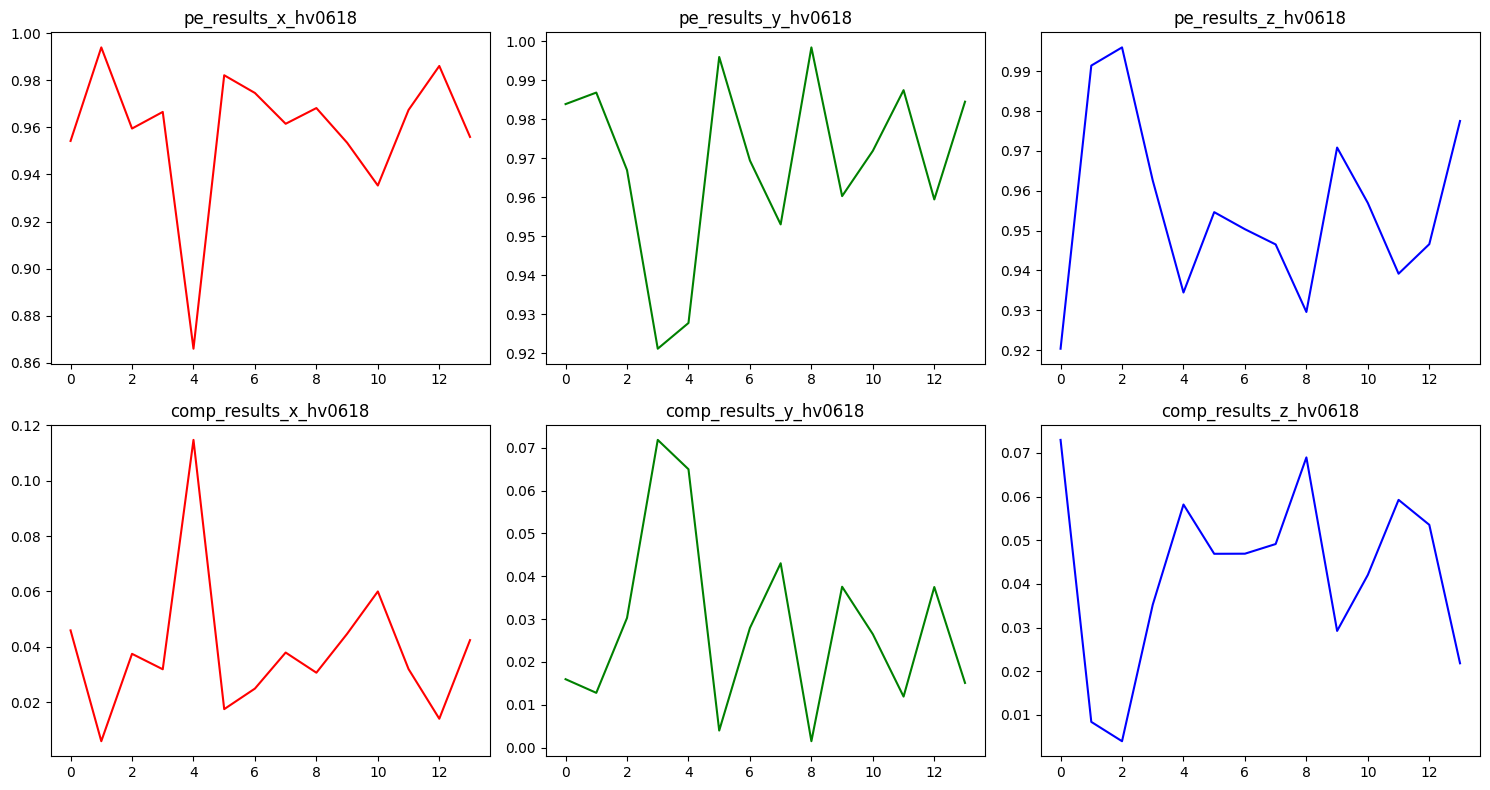

In [253]:
#Calculating the permutation entropy and complexity
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_hv0618[0:14], ax=axes[0, 0],color='r')
sns.lineplot(data=pe_results_y_hv0618[0:14], ax=axes[0, 1],color='g')
sns.lineplot(data=pe_results_z_hv0618[0:14], ax=axes[0, 2],color='b')

# Plot comp_results
sns.lineplot(data=comp_results_x_hv0618[0:14], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_hv0618[0:14], ax=axes[1, 1],color='g')
sns.lineplot(data=comp_results_z_hv0618[0:14], ax=axes[1, 2],color='b')

# Set titles
axes[0, 0].set_title('pe_results_x_hv0618')
axes[0, 1].set_title('pe_results_y_hv0618')
axes[0, 2].set_title('pe_results_z_hv0618')
axes[1, 0].set_title('comp_results_x_hv0618')
axes[1, 1].set_title('comp_results_y_hv0618')
axes[1, 2].set_title('comp_results_z_hv0618')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [254]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_HV0618= ['-0.003344','-0.003296','-0.000408',' 0.000280',' 0.002632',' 0.003258',' 0.003539 ',' 0.004388',' 0.006191',' 0.006193',' 0.006279 ',' 0.024965',' 0.038516',' 0.040862',' 0.122406']

# Create DataFrame using lists
hv0618_x =  pd.DataFrame({'Pe_results': pe_results_x_hv0618, 'Comp_results': comp_results_x_hv0618,'TAC_Reading':list_HV0618})
hv0618_y =  pd.DataFrame({'Pe_results': pe_results_y_hv0618, 'Comp_results': comp_results_y_hv0618,'TAC_Reading':list_HV0618})
hv0618_z =  pd.DataFrame({'Pe_results': pe_results_z_hv0618, 'Comp_results': comp_results_z_hv0618,'TAC_Reading':list_HV0618})
#Conerting data type to float
hv0618_x['TAC_Reading'] = hv0618_x['TAC_Reading'].astype(float)
hv0618_y['TAC_Reading'] = hv0618_y['TAC_Reading'].astype(float)
hv0618_z['TAC_Reading'] = hv0618_z['TAC_Reading'].astype(float)

hv0618_x['Sober_classification'] = hv0618_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
hv0618_y['Sober_classification'] = hv0618_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
hv0618_z['Sober_classification'] = hv0618_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(hv0618_x)
print(hv0618_y)
print(hv0618_z)

#Scatter Plot

fig,axes = plt.subplots(2, 2, figsize=(20, 10))

sns.scatterplot(data=hv0618_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=hv0618_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=hv0618_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

    Pe_results  Comp_results  TAC_Reading  Sober_classification
0     0.954210      0.045948    -0.003344                     0
1     0.993914      0.005933    -0.003296                     0
2     0.959477      0.037484    -0.000408                     0
3     0.966530      0.031911     0.000280                     0
4     0.866034      0.114738     0.002632                     0
5     0.982092      0.017516     0.003258                     0
6     0.974570      0.024940     0.003539                     0
7     0.961497      0.037951     0.004388                     0
8     0.968165      0.030671     0.006191                     0
9     0.953456      0.044712     0.006193                     0
10    0.935292      0.060014     0.006279                     0
11    0.967383      0.031972     0.024965                     0
12    0.986038      0.014048     0.038516                     0
13    0.955915      0.042437     0.040862                     0
14    0.971946      0.026475     0.12240

# **JB3156**

## X axis Pid JB3156

In [255]:
#Sorting the data in ascending order of TAC Reading
sort_JB3156 = merged_JB3156_df.sort_values(by=['TAC_Reading'])
sort_JB3156

time     pid         x             y             z   timestamp  \
0    1493740607011  JB3156  0.045732  2.585300e-01  2.724761e-01  1493740607   
27   1493740607555  JB3156 -0.025567  9.674375e-02 -8.516148e-02  1493740607   
28   1493740607575  JB3156  0.025798  9.115133e-02 -1.105837e-02  1493740607   
29   1493740607596  JB3156  0.027500  3.977208e-02  3.718024e-02  1493740607   
30   1493740607615  JB3156  0.141513 -1.030104e-02 -1.140433e-02  1493740607   
..             ...     ...       ...           ...           ...         ...   
329  1493760881400  JB3156  0.056234 -4.522519e+06  4.522519e+06  1493760881   
330  1493760881423  JB3156  0.054019 -4.522519e+06  4.522519e+06  1493760881   
353  1493760881884  JB3156  0.042377 -4.522519e+06  4.522519e+06  1493760881   
321  1493760881239  JB3156  0.028311 -4.522519e+06  4.522519e+06  1493760881   
352  1493760881864  JB3156  0.040462 -4.522519e+06  4.522519e+06  1493760881   

     TAC_Reading  
0       0.035549  
27      0.035549  
28      0.035549  
29      0.035549  
30      0.035549  
..           ...  
329     0.091967  
330     0.091967  
353     0.091967  
321     0.091967  
352     0.091967  

[720 rows x 7 columns]

In [256]:
# Using dataframe sort_JB3156: additional classification to check if 'TAC_Reading' value is >0.08 or not

sort_JB3156['Sober_classification'] = sort_JB3156['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_JB3156

time     pid         x             y             z   timestamp  \
0    1493740607011  JB3156  0.045732  2.585300e-01  2.724761e-01  1493740607   
27   1493740607555  JB3156 -0.025567  9.674375e-02 -8.516148e-02  1493740607   
28   1493740607575  JB3156  0.025798  9.115133e-02 -1.105837e-02  1493740607   
29   1493740607596  JB3156  0.027500  3.977208e-02  3.718024e-02  1493740607   
30   1493740607615  JB3156  0.141513 -1.030104e-02 -1.140433e-02  1493740607   
..             ...     ...       ...           ...           ...         ...   
329  1493760881400  JB3156  0.056234 -4.522519e+06  4.522519e+06  1493760881   
330  1493760881423  JB3156  0.054019 -4.522519e+06  4.522519e+06  1493760881   
353  1493760881884  JB3156  0.042377 -4.522519e+06  4.522519e+06  1493760881   
321  1493760881239  JB3156  0.028311 -4.522519e+06  4.522519e+06  1493760881   
352  1493760881864  JB3156  0.040462 -4.522519e+06  4.522519e+06  1493760881   

     TAC_Reading  Sober_classification  
0       0.035549                     0  
27      0.035549                     0  
28      0.035549                     0  
29      0.035549                     0  
30      0.035549                     0  
..           ...                   ...  
329     0.091967                     1  
330     0.091967                     1  
353     0.091967                     1  
321     0.091967                     1  
352     0.091967                     1  

[720 rows x 8 columns]

In [257]:
#Resetting the index values after sorting
sort_JB3156.reset_index(drop=True)

time     pid         x             y             z   timestamp  \
0    1493740607011  JB3156  0.045732  2.585300e-01  2.724761e-01  1493740607   
1    1493740607555  JB3156 -0.025567  9.674375e-02 -8.516148e-02  1493740607   
2    1493740607575  JB3156  0.025798  9.115133e-02 -1.105837e-02  1493740607   
3    1493740607596  JB3156  0.027500  3.977208e-02  3.718024e-02  1493740607   
4    1493740607615  JB3156  0.141513 -1.030104e-02 -1.140433e-02  1493740607   
..             ...     ...       ...           ...           ...         ...   
715  1493760881400  JB3156  0.056234 -4.522519e+06  4.522519e+06  1493760881   
716  1493760881423  JB3156  0.054019 -4.522519e+06  4.522519e+06  1493760881   
717  1493760881884  JB3156  0.042377 -4.522519e+06  4.522519e+06  1493760881   
718  1493760881239  JB3156  0.028311 -4.522519e+06  4.522519e+06  1493760881   
719  1493760881864  JB3156  0.040462 -4.522519e+06  4.522519e+06  1493760881   

     TAC_Reading  Sober_classification  
0       0.035549                     0  
1       0.035549                     0  
2       0.035549                     0  
3       0.035549                     0  
4       0.035549                     0  
..           ...                   ...  
715     0.091967                     1  
716     0.091967                     1  
717     0.091967                     1  
718     0.091967                     1  
719     0.091967                     1  

[720 rows x 8 columns]

In [258]:
#Counting the number of TAC Reading in each segment
count_JB3156=sort_JB3156['TAC_Reading'].value_counts()
count_JB3156

TAC_Reading
0.035549    50
0.035910    50
0.046254    50
0.062373    50
0.069628    50
0.037236    49
0.044379    49
0.050301    49
0.066105    49
0.080562    49
0.091967    49
0.061351    48
0.061969    48
0.063135    40
0.091344    23
0.038097    17
Name: count, dtype: int64

In [259]:
#Calculating the permutation entropy and complexity
TAC_Reading_JB3156 = pd.Series([50,50,50,50,50,49,49,49,49,49,49,48,48,40,23,17], name='count')
pe_results_x_jb3156= []
comp_results_x_jb3156=[]
i=0
for segment_value in TAC_Reading_JB3156:
  num_segs=len(sort_JB3156['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_JB3156[i-1]
  end_index = start_index + (segment_value)
  segment = sort_JB3156['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_x_jb3156.append(pe)
  comp_results_x_jb3156.append(comp)
  i+=1
print(pe_results_x_jb3156)
print(comp_results_x_jb3156)

[0.9557079148496581, 0.9294127667059525, 0.9620960061980909, 0.9175363868704953, 0.9638433121838774, 0.9627929140821332, 0.9796573847049985, 0.9070044791162124, 0.9829679051196508, 0.987347790732625, 0.9648043543508605, 0.9406945633541751, 0.9209669911369877, 0.9295629226974164, 0.9942854629567633, 0.8212530783391992]
[0.04048262083643016, 0.06644258412568341, 0.03510553087612618, 0.07313704743870582, 0.03469644752456677, 0.03577085787820233, 0.019767349106733213, 0.08642989524785921, 0.016447728641146797, 0.012307829920431796, 0.034421123773168714, 0.05418393788337315, 0.072036621982692, 0.0689537476769031, 0.005621518403213876, 0.1297773759919361]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Y axis Pis JB3156

In [260]:
#Calculating the permutation entropy and complexity
pe_results_y_jb3156= []
comp_results_y_jb3156=[]
i=0
for segment_value in TAC_Reading_JB3156:
  num_segs=len(sort_JB3156['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_JB3156[i-1]
  end_index = start_index + (segment_value)
  segment = sort_JB3156['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_y_jb3156.append(pe)
  comp_results_y_jb3156.append(comp)
  i+=1
print(pe_results_y_jb3156)
print(comp_results_y_jb3156)

[0.9190905411707535, nan, 0.99120977828769, 0.9504164796552006, 0.5043072674065553, 0.8811970516954679, 0.44154252209327216, 0.9016329763187617, 0.6138609799283427, 0.187027536394487, nan, 0.9312675894877598, 0.9485521521215325, 0.9386905818535186, nan, nan]
[0.07187658934229225, nan, 0.008649768520210219, 0.04532321255566271, 0.22012410976807978, 0.09643036925249654, 0.21948423699447211, 0.08090914712348699, 0.2130942405195649, 0.14339483483886895, nan, 0.06285301229400359, 0.047240374087322644, 0.05997034751894753, nan, nan]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))
<ipython-input-200-944f380d48bf>:50: RuntimeWarning: invalid value encountered in scalar divide
  return(s_entropy(p)/max_entropy)
<ipython-input-200-944f380d48bf>:62: RuntimeWarning: divide by zero encountered in scalar divide
  Q_o = -1/(constant1+constant2+constant3)
<ipython-input-200-944f380d48bf>:67: RuntimeWarning: invalid value encountered in scalar multiply
  Comp_JS = Q_o * JSdivergence * pe


## Z axis Pid JB3156

In [261]:
#Calculating the permutation entropy and complexity
pe_results_z_jb3156= []
comp_results_z_jb3156=[]
i=0
for segment_value in TAC_Reading_JB3156:
  num_segs=len(sort_JB3156['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_JB3156[i-1]
  end_index = start_index + (segment_value)
  segment = sort_JB3156['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_z_jb3156.append(pe)
  comp_results_z_jb3156.append(comp)
  i+=1
print(pe_results_z_jb3156)
print(comp_results_z_jb3156)

[0.9514197403315636, nan, 0.9076649801176722, 0.9793569710531482, 0.5355584217036248, 0.8575098027835709, 0.5980522500440543, 0.8704710720900891, 0.5707070889836992, 0.187027536394487, 0.5344191139134536, 0.9069842114254852, 0.8981682513995195, 0.9436812375312202, 0.34635168603374933, 0.5713619478607342]
[0.04511125340553577, nan, 0.0818651360420484, 0.019496095763331136, 0.21848470717097204, 0.11864384275286591, 0.22015075959640168, 0.10721978150019967, 0.21564017770564878, 0.14339483483886895, 0.22933211339450008, 0.07843731324025498, 0.0943751754214949, 0.05393049705439118, 0.2057117300471517, 0.21570960611882697]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))
<ipython-input-200-944f380d48bf>:50: RuntimeWarning: invalid value encountered in scalar divide
  return(s_entropy(p)/max_entropy)
<ipython-input-200-944f380d48bf>:62: RuntimeWarning: divide by zero encountered in scalar divide
  Q_o = -1/(constant1+constant2+constant3)
<ipython-input-200-944f380d48bf>:67: RuntimeWarning: invalid value encountered in scalar multiply
  Comp_JS = Q_o * JSdivergence * pe


## Permutation Entropy and Complexity plots

In [262]:
#Plotting the permutation entropy and complexity
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_jb3156[0:15], ax=axes[0, 0],color='r')
sns.lineplot(data=pe_results_y_jb3156[0:15], ax=axes[0, 1],color='g')
sns.lineplot(data=pe_results_z_jb3156[0:15], ax=axes[0, 2],color='b')

# Plot comp_results
sns.lineplot(data=comp_results_x_jb3156[0:15], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_jb3156[0:15], ax=axes[1, 1],color='g')
sns.lineplot(data=comp_results_z_jb3156[0:15], ax=axes[1, 2],color='b')

# Set titles
axes[0, 0].set_title('pe_results_x_jb3156')
axes[0, 1].set_title('pe_results_y_jb3156')
axes[0, 2].set_title('pe_results_z_jb3156')
axes[1, 0].set_title('comp_results_x_jb3156')
axes[1, 1].set_title('comp_results_y_jb3156')
axes[1, 2].set_title('comp_results_z_jb3156')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

    Pe_results  Comp_results  TAC_Reading  Sober_classification
0     0.955708      0.040483     0.035549                     0
1     0.929413      0.066443     0.035910                     0
2     0.962096      0.035106     0.046254                     0
3     0.917536      0.073137     0.062373                     0
4     0.963843      0.034696     0.069628                     0
5     0.962793      0.035771     0.037236                     0
6     0.979657      0.019767     0.044379                     0
7     0.907004      0.086430     0.050301                     0
8     0.982968      0.016448     0.066105                     0
9     0.987348      0.012308     0.080562                     1
10    0.964804      0.034421     0.091967                     1
11    0.940695      0.054184     0.061351                     0
12    0.920967      0.072037     0.061969                     0
13    0.929563      0.068954     0.063135                     0
14    0.994285      0.005622     0.09134

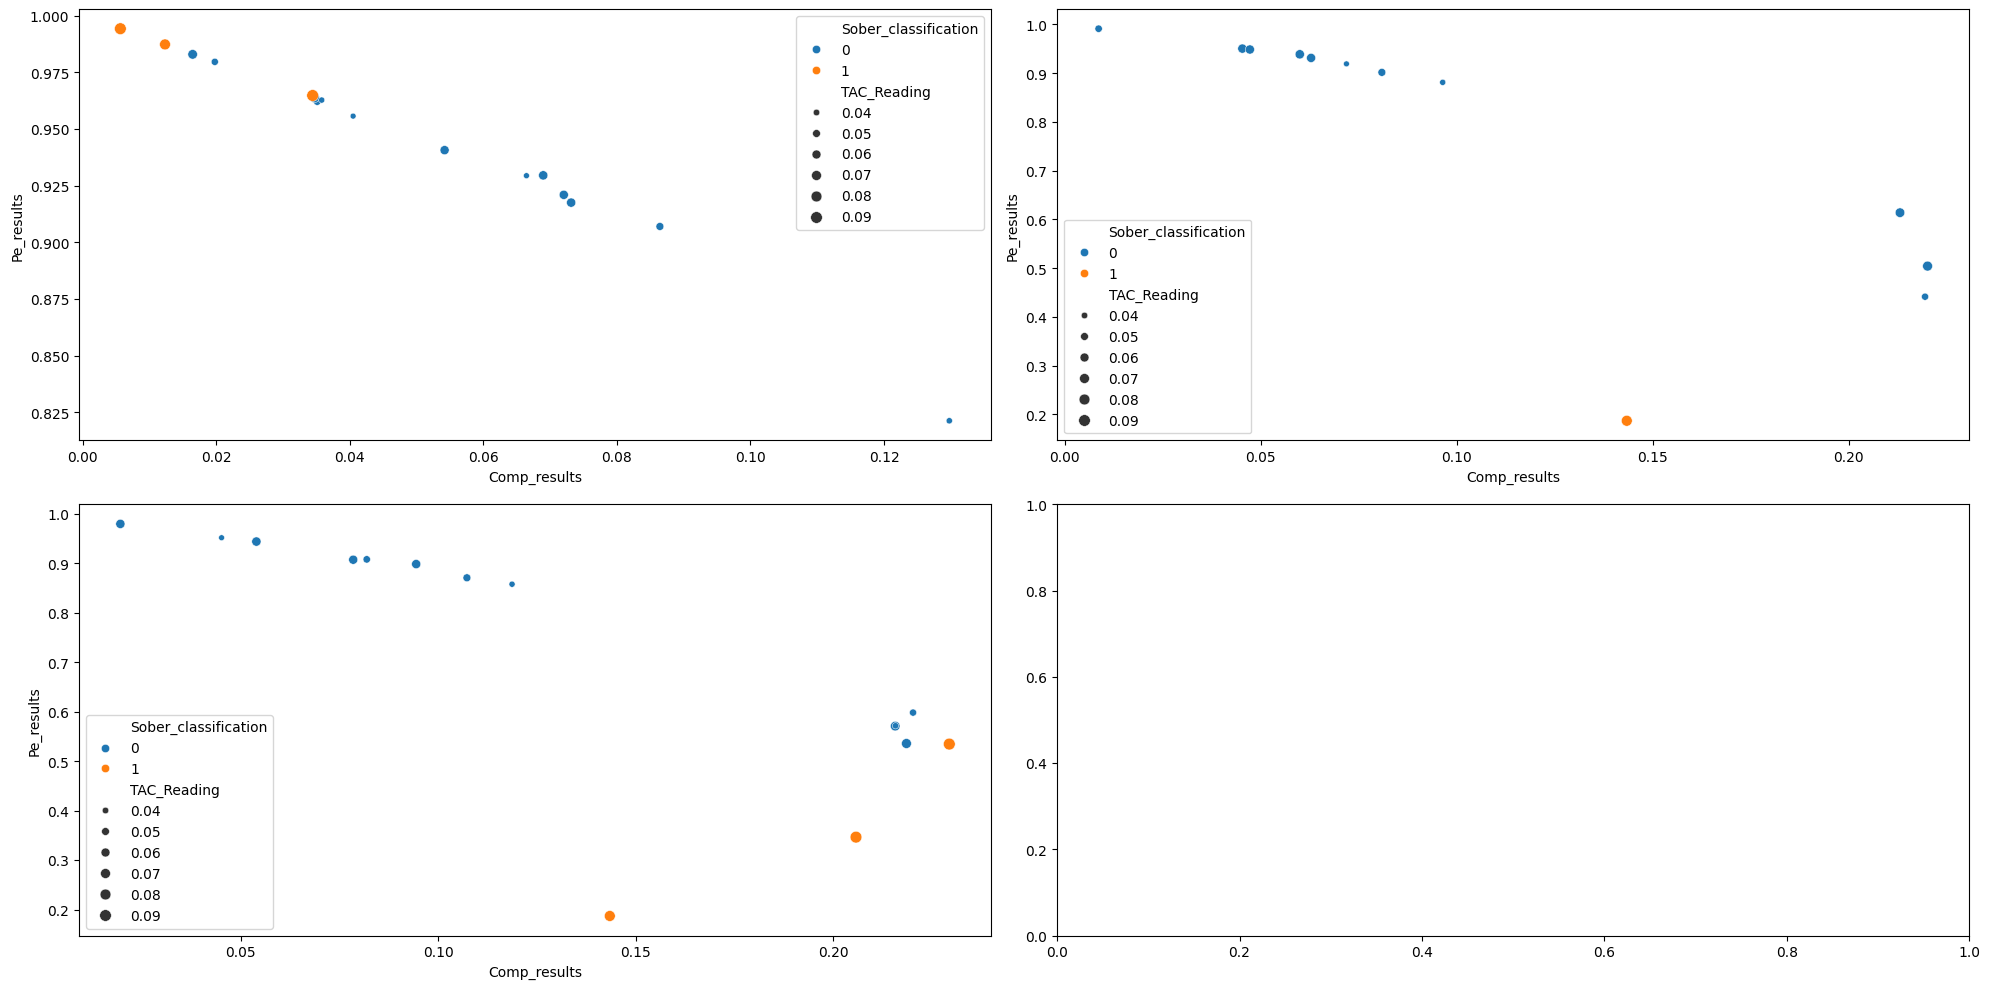

In [263]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_JB3156= ['0.035549 ','0.035910','0.046254','0.062373','0.069628','0.037236','0.044379','0.050301','0.066105','0.080562','0.091967','0.061351','0.061969','0.063135 ','0.091344','0.038097']

# Create DataFrame using lists
jb3156_x =  pd.DataFrame({'Pe_results': pe_results_x_jb3156, 'Comp_results': comp_results_x_jb3156,'TAC_Reading':list_JB3156})
jb3156_y =  pd.DataFrame({'Pe_results': pe_results_y_jb3156, 'Comp_results': comp_results_y_jb3156,'TAC_Reading':list_JB3156})
jb3156_z =  pd.DataFrame({'Pe_results': pe_results_z_jb3156, 'Comp_results': comp_results_z_jb3156,'TAC_Reading':list_JB3156})
#Conerting data type to float
jb3156_x['TAC_Reading'] = jb3156_x['TAC_Reading'].astype(float)
jb3156_y['TAC_Reading'] = jb3156_y['TAC_Reading'].astype(float)
jb3156_z['TAC_Reading'] = jb3156_z['TAC_Reading'].astype(float)

jb3156_x['Sober_classification'] = jb3156_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
jb3156_y['Sober_classification'] = jb3156_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
jb3156_z['Sober_classification'] = jb3156_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(jb3156_x)
print(jb3156_y)
print(jb3156_z)

#Scatter Plot

fig,axes = plt.subplots(2, 2, figsize=(20, 10))

sns.scatterplot(data=jb3156_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=jb3156_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=jb3156_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



# **JR8022**

## X axis Pid JR8022

In [264]:
#Sorting the data in ascending order of TAC Reading
sort_JR8022 = merged_JR8022_df.sort_values(by=['TAC_Reading'])
sort_JR8022

time     pid         x         y         z   timestamp  \
0   1493739745021  JR8022  0.000010 -0.000005 -0.000142  1493739745   
22  1493739745547  JR8022 -0.000003 -0.000017 -0.000112  1493739745   
23  1493739745585  JR8022 -0.000035  0.000007 -0.000090  1493739745   
24  1493739745621  JR8022 -0.000007 -0.000020 -0.000107  1493739745   
25  1493739745624  JR8022  0.000003 -0.000038 -0.000100  1493739745   
..            ...     ...       ...       ...       ...         ...   
63  1493756304571  JR8022  0.001275 -0.000107  0.000953  1493756304   
62  1493756304567  JR8022  0.000125 -0.006078  0.002658  1493756304   
61  1493756304529  JR8022 -0.001773 -0.010460  0.002985  1493756304   
77  1493756304927  JR8022 -0.005330  0.002853 -0.006095  1493756304   
59  1493756304476  JR8022 -0.000562 -0.008615  0.000628  1493756304   

    TAC_Reading  
0      0.088046  
22     0.088046  
23     0.088046  
24     0.088046  
25     0.088046  
..          ...  
63     0.206761  
62     0.206761  
61     0.206761  
77     0.206761  
59     0.206761  

[119 rows x 7 columns]

In [265]:
# Using dataframe sort_JR8022: additional classification to check if 'TAC_Reading' value is >0.08 or not
#Sober = 0 , Intoxicated (Not Sober) = 1

sort_JR8022['Sober_classification'] = sort_JR8022['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_JR8022

time     pid         x         y         z   timestamp  \
0   1493739745021  JR8022  0.000010 -0.000005 -0.000142  1493739745   
22  1493739745547  JR8022 -0.000003 -0.000017 -0.000112  1493739745   
23  1493739745585  JR8022 -0.000035  0.000007 -0.000090  1493739745   
24  1493739745621  JR8022 -0.000007 -0.000020 -0.000107  1493739745   
25  1493739745624  JR8022  0.000003 -0.000038 -0.000100  1493739745   
..            ...     ...       ...       ...       ...         ...   
63  1493756304571  JR8022  0.001275 -0.000107  0.000953  1493756304   
62  1493756304567  JR8022  0.000125 -0.006078  0.002658  1493756304   
61  1493756304529  JR8022 -0.001773 -0.010460  0.002985  1493756304   
77  1493756304927  JR8022 -0.005330  0.002853 -0.006095  1493756304   
59  1493756304476  JR8022 -0.000562 -0.008615  0.000628  1493756304   

    TAC_Reading  Sober_classification  
0      0.088046                     1  
22     0.088046                     1  
23     0.088046                     1  
24     0.088046                     1  
25     0.088046                     1  
..          ...                   ...  
63     0.206761                     1  
62     0.206761                     1  
61     0.206761                     1  
77     0.206761                     1  
59     0.206761                     1  

[119 rows x 8 columns]

In [266]:
#Resetting the index values after sorting
sort_JR8022.reset_index(drop=True)

time     pid         x         y         z   timestamp  \
0    1493739745021  JR8022  0.000010 -0.000005 -0.000142  1493739745   
1    1493739745547  JR8022 -0.000003 -0.000017 -0.000112  1493739745   
2    1493739745585  JR8022 -0.000035  0.000007 -0.000090  1493739745   
3    1493739745621  JR8022 -0.000007 -0.000020 -0.000107  1493739745   
4    1493739745624  JR8022  0.000003 -0.000038 -0.000100  1493739745   
..             ...     ...       ...       ...       ...         ...   
114  1493756304571  JR8022  0.001275 -0.000107  0.000953  1493756304   
115  1493756304567  JR8022  0.000125 -0.006078  0.002658  1493756304   
116  1493756304529  JR8022 -0.001773 -0.010460  0.002985  1493756304   
117  1493756304927  JR8022 -0.005330  0.002853 -0.006095  1493756304   
118  1493756304476  JR8022 -0.000562 -0.008615  0.000628  1493756304   

     TAC_Reading  Sober_classification  
0       0.088046                     1  
1       0.088046                     1  
2       0.088046                     1  
3       0.088046                     1  
4       0.088046                     1  
..           ...                   ...  
114     0.206761                     1  
115     0.206761                     1  
116     0.206761                     1  
117     0.206761                     1  
118     0.206761                     1  

[119 rows x 8 columns]

In [267]:
#Counting the number of TAC Reading in each segment
count_JR8022=sort_JR8022['TAC_Reading'].value_counts()
count_JR8022

TAC_Reading
0.088046    40
0.206761    40
0.176895    39
Name: count, dtype: int64

In [268]:
#Calculating the permutation entropy and complexity
TAC_Reading_JR8022 = pd.Series([40,40,39],name='count')
pe_results_x_jr8022= []
comp_results_x_jr8022=[]
i=0
for segment_value in TAC_Reading_JR8022:
  num_segs=len(sort_JR8022['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_JR8022[i-1]
  end_index = start_index + (segment_value)
  segment = sort_JR8022['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_x_jr8022.append(pe)
  comp_results_x_jr8022.append(comp)
  i+=1
print(pe_results_x_jr8022)
print(comp_results_x_jr8022)

[0.9785164507907662, 0.927457566944645, 0.8287318319861924]
[0.02153008269821854, 0.07063318336566421, 0.13441525432810092]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Y axis Pid JR8022

In [269]:
#Calculating the permutation entropy and complexity
pe_results_y_jr8022= []
comp_results_y_jr8022=[]
i=0
for segment_value in TAC_Reading_JR8022:
  num_segs=len(sort_JR8022['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_JR8022[i-1]
  end_index = start_index + (segment_value)
  segment = sort_JR8022['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_y_jr8022.append(pe)
  comp_results_y_jr8022.append(comp)
  i+=1
print(pe_results_y_jr8022)
print(comp_results_y_jr8022)

[0.9631464324034921, 0.9644540048863018, 0.950586016197575]
[0.039533444587266764, 0.034908089285298864, 0.050522680944595964]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Z axis Pid JR8022

In [270]:
#Calculating the permutation entropy and complexity
pe_results_z_jr8022= []
comp_results_z_jr8022=[]
i=0
for segment_value in TAC_Reading_JR8022:
  num_segs=len(sort_JR8022['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_JR8022[i-1]
  end_index = start_index + (segment_value)
  segment = sort_JR8022['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_z_jr8022.append(pe)
  comp_results_z_jr8022.append(comp)
  i+=1
print(pe_results_z_jr8022)
print(comp_results_z_jr8022)

[0.9914550895366188, 0.9029180624078657, 0.8504602360239986]
[0.008397768877605726, 0.08636941561314096, 0.14077012026454022]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Permutation Entropy and Complexity plots

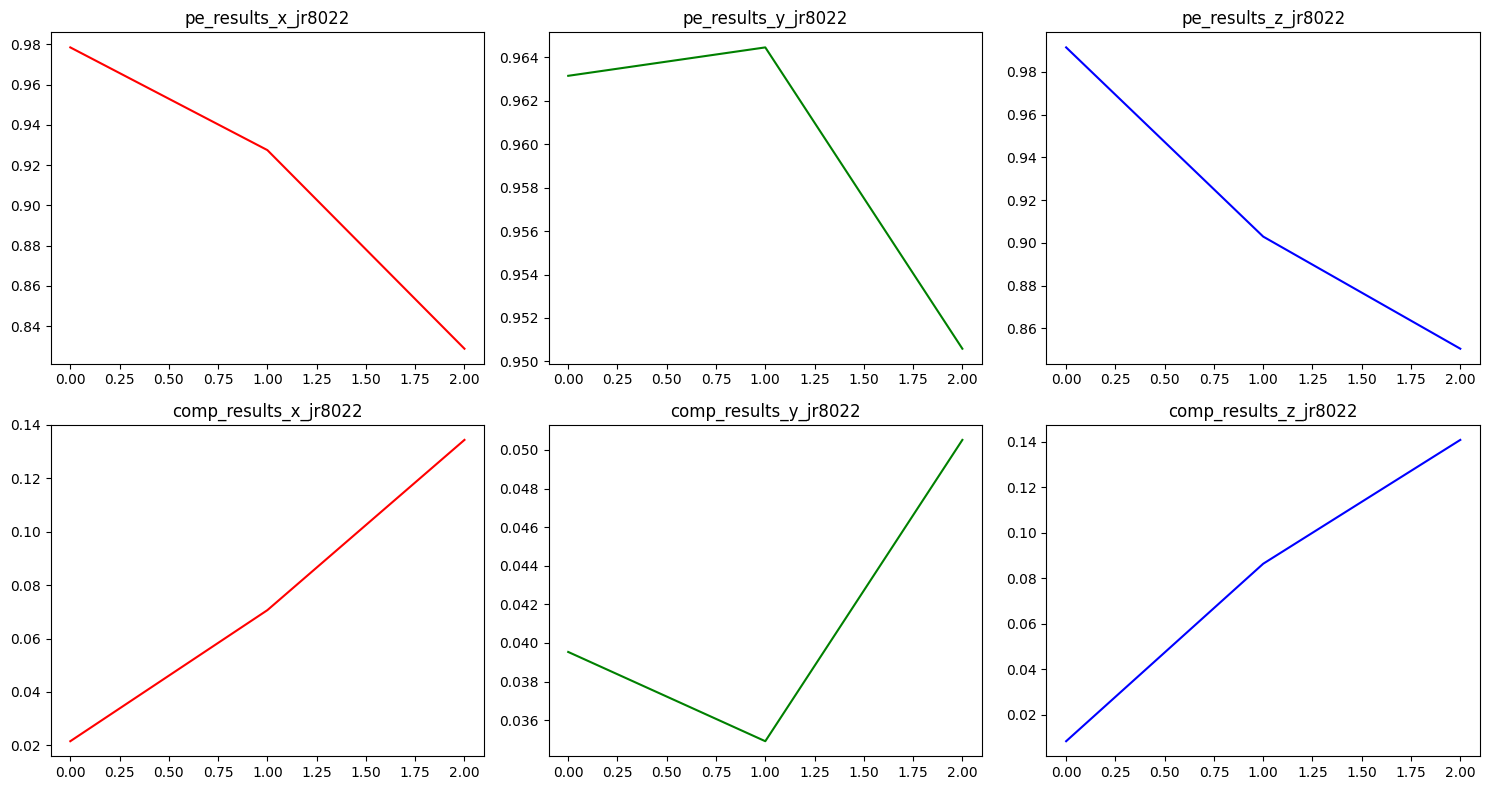

In [271]:
#Plotting the permutation entropy and complexity
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_jr8022[0:15], ax=axes[0, 0],color='r')
sns.lineplot(data=pe_results_y_jr8022[0:15], ax=axes[0, 1],color='g')
sns.lineplot(data=pe_results_z_jr8022[0:15], ax=axes[0, 2],color='b')

# Plot comp_results
sns.lineplot(data=comp_results_x_jr8022[0:15], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_jr8022[0:15], ax=axes[1, 1],color='g')
sns.lineplot(data=comp_results_z_jr8022[0:15], ax=axes[1, 2],color='b')

# Set titles
axes[0, 0].set_title('pe_results_x_jr8022')
axes[0, 1].set_title('pe_results_y_jr8022')
axes[0, 2].set_title('pe_results_z_jr8022')
axes[1, 0].set_title('comp_results_x_jr8022')
axes[1, 1].set_title('comp_results_y_jr8022')
axes[1, 2].set_title('comp_results_z_jr8022')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.978516      0.021530     0.088046                     1
1    0.927458      0.070633     0.206761                     1
2    0.828732      0.134415     0.176895                     1
   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.963146      0.039533     0.088046                     1
1    0.964454      0.034908     0.206761                     1
2    0.950586      0.050523     0.176895                     1
   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.991455      0.008398     0.088046                     1
1    0.902918      0.086369     0.206761                     1
2    0.850460      0.140770     0.176895                     1


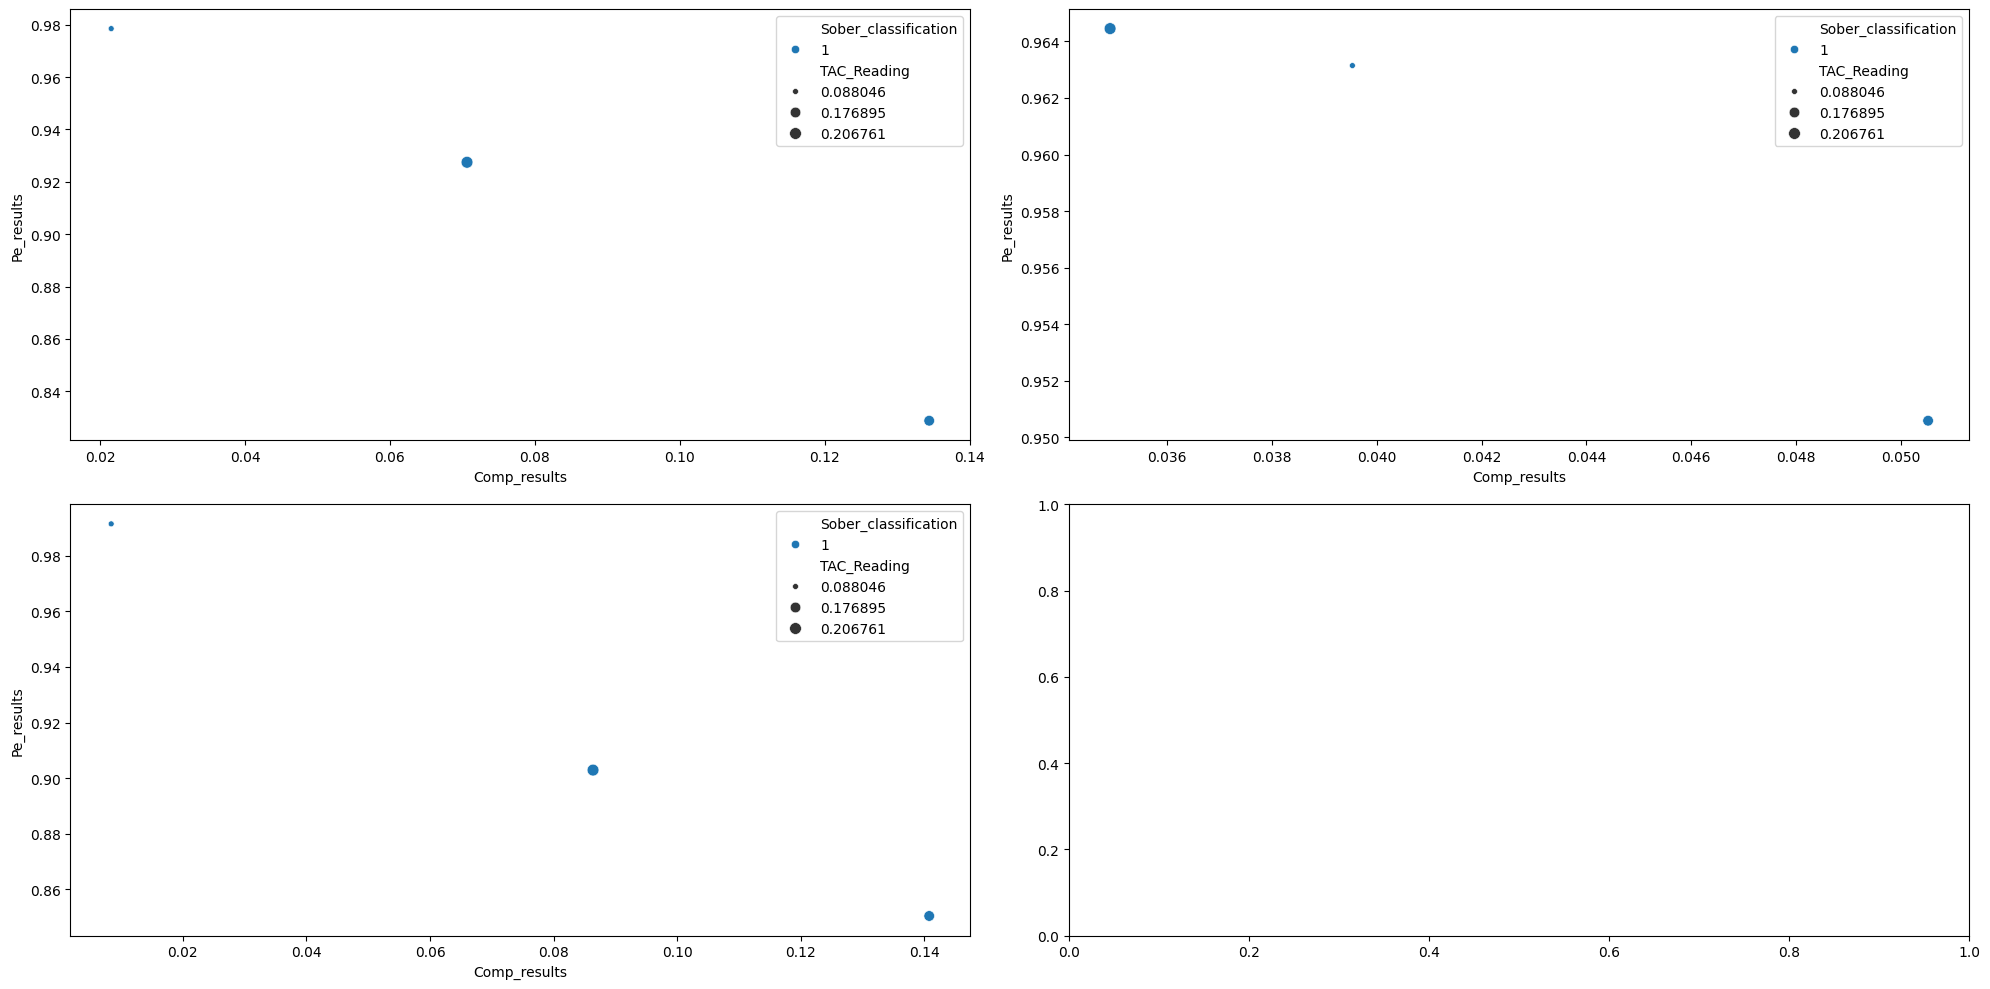

In [272]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_JR8022= ['0.088046','0.206761','0.176895']

# Create DataFrame using lists
jr8022_x =  pd.DataFrame({'Pe_results': pe_results_x_jr8022, 'Comp_results': comp_results_x_jr8022,'TAC_Reading':list_JR8022})
jr8022_y =  pd.DataFrame({'Pe_results': pe_results_y_jr8022, 'Comp_results': comp_results_y_jr8022,'TAC_Reading':list_JR8022})
jr8022_z =  pd.DataFrame({'Pe_results': pe_results_z_jr8022, 'Comp_results': comp_results_z_jr8022,'TAC_Reading':list_JR8022})
#Conerting data type to float
jr8022_x['TAC_Reading'] = jr8022_x['TAC_Reading'].astype(float)
jr8022_y['TAC_Reading'] = jr8022_y['TAC_Reading'].astype(float)
jr8022_z['TAC_Reading'] = jr8022_z['TAC_Reading'].astype(float)

jr8022_x['Sober_classification'] = jr8022_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
jr8022_y['Sober_classification'] = jr8022_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
jr8022_z['Sober_classification'] = jr8022_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(jr8022_x)
print(jr8022_y)
print(jr8022_z)

#Scatter Plot
fig,axes = plt.subplots(2, 2, figsize=(20, 10))

sns.scatterplot(data=jr8022_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=jr8022_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=jr8022_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# **MC7070**

## X axis Pid MC7070

In [273]:
#Sorting the data in ascending order of TAC Reading
sort_MC7070 = merged_MC7070_df.sort_values(by=['TAC_Reading'])
sort_MC7070

time     pid         x         y         z   timestamp  \
0    1493746471011  MC7070  0.000032 -0.000020  0.000188  1493746471   
22   1493746471561  MC7070  0.000007  0.000010  0.000193  1493746471   
23   1493746471585  MC7070 -0.000050 -0.000022  0.000158  1493746471   
24   1493746471611  MC7070 -0.000005 -0.000030  0.000193  1493746471   
25   1493746471636  MC7070 -0.000005 -0.000000  0.000175  1493746471   
..             ...     ...       ...       ...       ...         ...   
146  1493779648953  MC7070  0.008483  0.001805 -0.006063  1493779648   
147  1493779648955  MC7070  0.008327  0.001102 -0.000965  1493779648   
148  1493779648956  MC7070  0.007912  0.001595  0.001795  1493779648   
150  1493779648999  MC7070  0.006032  0.000515  0.006745  1493779648   
135  1493779648943  MC7070 -0.009527  0.001893 -0.004210  1493779648   

     TAC_Reading  
0       0.091933  
22      0.091933  
23      0.091933  
24      0.091933  
25      0.091933  
..           ...  
146     0.159160  
147     0.159160  
148     0.159160  
150     0.159160  
135     0.159160  

[191 rows x 7 columns]

In [274]:
# Using dataframe sort_MC7070: additional classification to check if 'TAC_Reading' value is >0.08 or not
#Sober = 0 , Intoxicated (Not Sober) = 1

sort_MC7070['Sober_classification'] = sort_MC7070['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_MC7070

time     pid         x         y         z   timestamp  \
0    1493746471011  MC7070  0.000032 -0.000020  0.000188  1493746471   
22   1493746471561  MC7070  0.000007  0.000010  0.000193  1493746471   
23   1493746471585  MC7070 -0.000050 -0.000022  0.000158  1493746471   
24   1493746471611  MC7070 -0.000005 -0.000030  0.000193  1493746471   
25   1493746471636  MC7070 -0.000005 -0.000000  0.000175  1493746471   
..             ...     ...       ...       ...       ...         ...   
146  1493779648953  MC7070  0.008483  0.001805 -0.006063  1493779648   
147  1493779648955  MC7070  0.008327  0.001102 -0.000965  1493779648   
148  1493779648956  MC7070  0.007912  0.001595  0.001795  1493779648   
150  1493779648999  MC7070  0.006032  0.000515  0.006745  1493779648   
135  1493779648943  MC7070 -0.009527  0.001893 -0.004210  1493779648   

     TAC_Reading  Sober_classification  
0       0.091933                     1  
22      0.091933                     1  
23      0.091933                     1  
24      0.091933                     1  
25      0.091933                     1  
..           ...                   ...  
146     0.159160                     1  
147     0.159160                     1  
148     0.159160                     1  
150     0.159160                     1  
135     0.159160                     1  

[191 rows x 8 columns]

In [275]:
#Resetting the index values after sorting
sort_MC7070.reset_index(drop=True)

time     pid         x         y         z   timestamp  \
0    1493746471011  MC7070  0.000032 -0.000020  0.000188  1493746471   
1    1493746471561  MC7070  0.000007  0.000010  0.000193  1493746471   
2    1493746471585  MC7070 -0.000050 -0.000022  0.000158  1493746471   
3    1493746471611  MC7070 -0.000005 -0.000030  0.000193  1493746471   
4    1493746471636  MC7070 -0.000005 -0.000000  0.000175  1493746471   
..             ...     ...       ...       ...       ...         ...   
186  1493779648953  MC7070  0.008483  0.001805 -0.006063  1493779648   
187  1493779648955  MC7070  0.008327  0.001102 -0.000965  1493779648   
188  1493779648956  MC7070  0.007912  0.001595  0.001795  1493779648   
189  1493779648999  MC7070  0.006032  0.000515  0.006745  1493779648   
190  1493779648943  MC7070 -0.009527  0.001893 -0.004210  1493779648   

     TAC_Reading  Sober_classification  
0       0.091933                     1  
1       0.091933                     1  
2       0.091933                     1  
3       0.091933                     1  
4       0.091933                     1  
..           ...                   ...  
186     0.159160                     1  
187     0.159160                     1  
188     0.159160                     1  
189     0.159160                     1  
190     0.159160                     1  

[191 rows x 8 columns]

In [276]:
#Counting the number of TAC Reading in each segment
count_MC7070=sort_MC7070['TAC_Reading'].value_counts()
count_MC7070

TAC_Reading
0.091933    40
0.142696    40
0.144615    40
0.144962    40
0.159160    31
Name: count, dtype: int64

In [277]:
#Calculating the permutation entropy and complexity
TAC_Reading_MC7070 = pd.Series([40,40,40,40,31],name='count')
pe_results_x_mc7070= []
comp_results_x_mc7070=[]
i=0
for segment_value in TAC_Reading_MC7070:
  num_segs=len(sort_MC7070['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_MC7070[i-1]
  end_index = start_index + (segment_value)
  segment = sort_MC7070['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_x_mc7070.append(pe)
  comp_results_x_mc7070.append(comp)
  i+=1
print(pe_results_x_mc7070)
print(comp_results_x_mc7070)

[0.9745703937213607, 0.9175762175194302, 0.9269285097857742, 0.9868904196777557, 0.8418318791762179]
[0.024940115253464165, 0.07816971201050854, 0.06489061999456006, 0.012780524083383751, 0.12800629284093906]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Y axis Pid MC7070

In [278]:
#Calculating the permutation entropy and complexity
pe_results_y_mc7070= []
comp_results_y_mc7070=[]
i=0
for segment_value in TAC_Reading_MC7070:
  num_segs=len(sort_MC7070['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_MC7070[i-1]
  end_index = start_index + (segment_value)
  segment = sort_MC7070['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_y_mc7070.append(pe)
  comp_results_y_mc7070.append(comp)
  i+=1
print(pe_results_y_mc7070)
print(comp_results_y_mc7070)

[0.9960197593954816, 0.9625836885433744, 0.9640419115961962, 0.9457430857289653, 0.9458855337610705]
[0.00397411284652309, 0.035234147352728395, 0.03334331611047681, 0.054697722607334076, 0.04645406731993386]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Z axis Pid MC7070

In [279]:
#Calculating the permutation entropy and complexity
pe_results_z_mc7070= []
comp_results_z_mc7070=[]
i=0
for segment_value in TAC_Reading_MC7070:
  num_segs=len(sort_MC7070['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_MC7070[i-1]
  end_index = start_index + (segment_value)
  segment = sort_MC7070['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_z_mc7070.append(pe)
  comp_results_z_mc7070.append(comp)
  i+=1
print(pe_results_z_mc7070)
print(comp_results_z_mc7070)

[0.9799870352179013, 0.8668596655053418, 0.9282677115889197, 0.9745703937213608, 0.8395121044284909]
[0.019417615265194674, 0.11797877557300569, 0.06372610135700796, 0.024940115253464408, 0.13543917565364116]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Permutation Entropy and Complexity plots

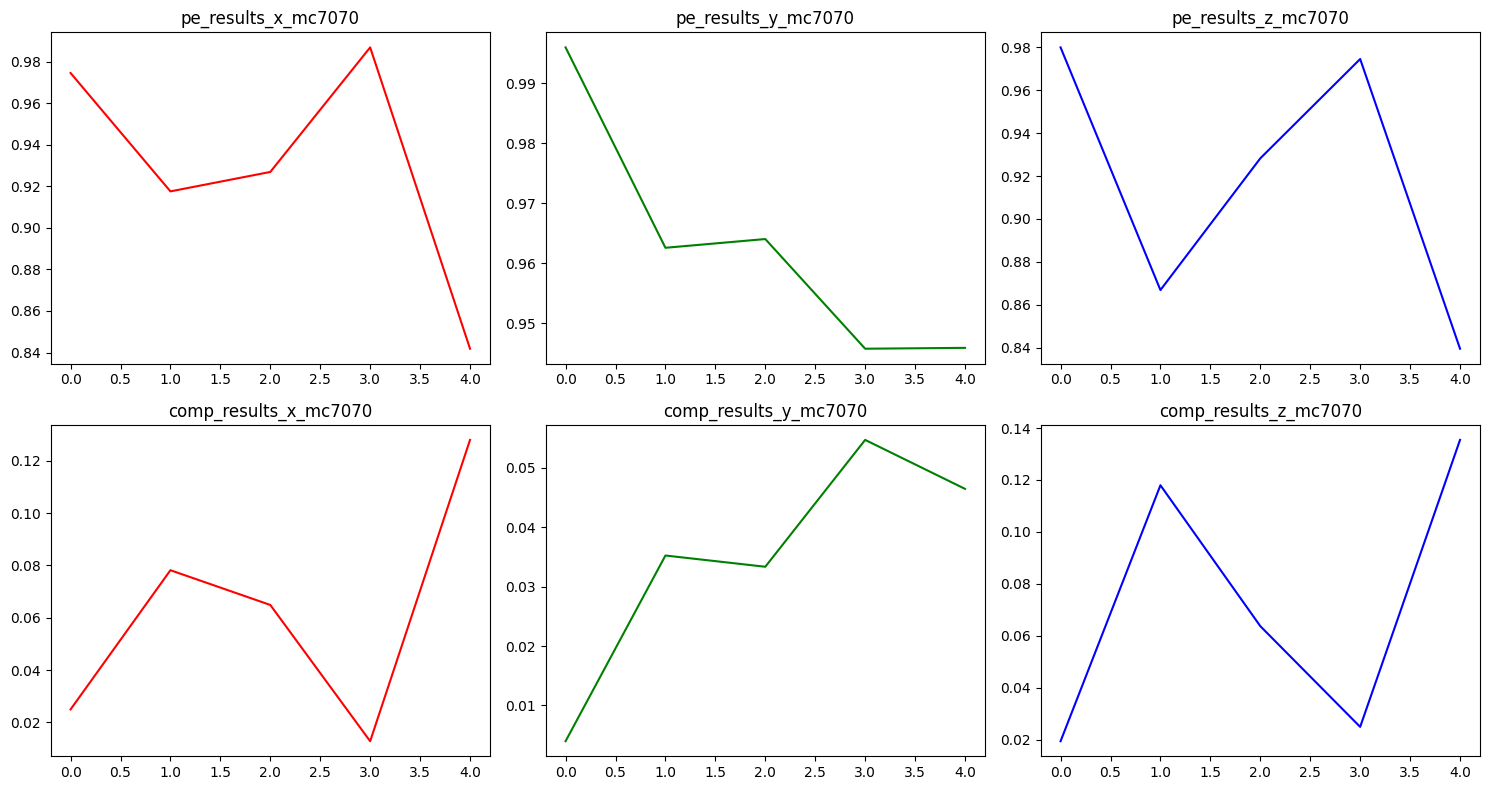

In [280]:
#Plotting the permutation entropy and complexity
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_mc7070[0:15], ax=axes[0, 0],color='r')
sns.lineplot(data=pe_results_y_mc7070[0:15], ax=axes[0, 1],color='g')
sns.lineplot(data=pe_results_z_mc7070[0:15], ax=axes[0, 2],color='b')

# Plot comp_results
sns.lineplot(data=comp_results_x_mc7070[0:15], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_mc7070[0:15], ax=axes[1, 1],color='g')
sns.lineplot(data=comp_results_z_mc7070[0:15], ax=axes[1, 2],color='b')

# Set titles
axes[0, 0].set_title('pe_results_x_mc7070')
axes[0, 1].set_title('pe_results_y_mc7070')
axes[0, 2].set_title('pe_results_z_mc7070')
axes[1, 0].set_title('comp_results_x_mc7070')
axes[1, 1].set_title('comp_results_y_mc7070')
axes[1, 2].set_title('comp_results_z_mc7070')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [281]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_MC7070= ['0.091933','0.142696','0.144615','0.144962','0.159160']

# Create DataFrame using lists
mc7070_x =  pd.DataFrame({'Pe_results': pe_results_x_mc7070, 'Comp_results': comp_results_x_mc7070,'TAC_Reading':list_MC7070})
mc7070_y =  pd.DataFrame({'Pe_results': pe_results_y_mc7070, 'Comp_results': comp_results_y_mc7070,'TAC_Reading':list_MC7070})
mc7070_z =  pd.DataFrame({'Pe_results': pe_results_z_mc7070, 'Comp_results': comp_results_z_mc7070,'TAC_Reading':list_MC7070})
#Conerting data type to float
mc7070_x['TAC_Reading'] = mc7070_x['TAC_Reading'].astype(float)
mc7070_y['TAC_Reading'] = mc7070_y['TAC_Reading'].astype(float)
mc7070_z['TAC_Reading'] = mc7070_z['TAC_Reading'].astype(float)

mc7070_x['Sober_classification'] = mc7070_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
mc7070_y['Sober_classification'] = mc7070_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
mc7070_z['Sober_classification'] = mc7070_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(mc7070_x)
print(mc7070_y)
print(mc7070_z)

#Scatter Plot

fig,axes = plt.subplots(2, 2, figsize=(20, 10))

sns.scatterplot(data=mc7070_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=mc7070_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=mc7070_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.974570      0.024940     0.091933                     1
1    0.917576      0.078170     0.142696                     1
2    0.926929      0.064891     0.144615                     1
3    0.986890      0.012781     0.144962                     1
4    0.841832      0.128006     0.159160                     1
   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.996020      0.003974     0.091933                     1
1    0.962584      0.035234     0.142696                     1
2    0.964042      0.033343     0.144615                     1
3    0.945743      0.054698     0.144962                     1
4    0.945886      0.046454     0.159160                     1
   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.979987      0.019418     0.091933                     1
1    0.866860      0.117979     0.142696                     1
2    0.928268      0.063726     0.144615               

# **MJ8002**

## X axis Pid MJ8002

In [282]:
#Sorting the data in ascending order of TAC Reading
sort_MJ8002 = merged_MJ8002_df.sort_values(by=['TAC_Reading'])
sort_MJ8002

time     pid         x         y         z   timestamp  \
319  1493783820987  MJ8002  0.000005 -0.000045 -0.000097  1493783820   
296  1493783820413  MJ8002  0.000065 -0.000020 -0.000137  1493783820   
295  1493783820387  MJ8002  0.000022 -0.000005 -0.000110  1493783820   
294  1493783820363  MJ8002  0.000013 -0.000025 -0.000120  1493783820   
293  1493783820337  MJ8002  0.000040 -0.000052 -0.000130  1493783820   
..             ...     ...       ...       ...       ...         ...   
216  1493765405416  MJ8002  0.000307 -0.000335 -0.000190  1493765405   
217  1493765405440  MJ8002  0.000048 -0.000458 -0.000077  1493765405   
218  1493765405465  MJ8002 -0.000280 -0.000398 -0.000158  1493765405   
211  1493765405291  MJ8002 -0.000087  0.000085 -0.000208  1493765405   
220  1493765405515  MJ8002  0.000020 -0.000190 -0.000347  1493765405   

     TAC_Reading  
319     0.040976  
296     0.040976  
295     0.040976  
294     0.040976  
293     0.040976  
..           ...  
216     0.217373  
217     0.217373  
218     0.217373  
211     0.217373  
220     0.217373  

[320 rows x 7 columns]

In [283]:
# Using dataframe sort_MJ8002: additional classification to check if 'TAC_Reading' value is >0.08 or not
#Sober = 0 , Intoxicated (Not Sober) = 1

sort_MJ8002['Sober_classification'] = sort_MJ8002['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_MJ8002

time     pid         x         y         z   timestamp  \
319  1493783820987  MJ8002  0.000005 -0.000045 -0.000097  1493783820   
296  1493783820413  MJ8002  0.000065 -0.000020 -0.000137  1493783820   
295  1493783820387  MJ8002  0.000022 -0.000005 -0.000110  1493783820   
294  1493783820363  MJ8002  0.000013 -0.000025 -0.000120  1493783820   
293  1493783820337  MJ8002  0.000040 -0.000052 -0.000130  1493783820   
..             ...     ...       ...       ...       ...         ...   
216  1493765405416  MJ8002  0.000307 -0.000335 -0.000190  1493765405   
217  1493765405440  MJ8002  0.000048 -0.000458 -0.000077  1493765405   
218  1493765405465  MJ8002 -0.000280 -0.000398 -0.000158  1493765405   
211  1493765405291  MJ8002 -0.000087  0.000085 -0.000208  1493765405   
220  1493765405515  MJ8002  0.000020 -0.000190 -0.000347  1493765405   

     TAC_Reading  Sober_classification  
319     0.040976                     0  
296     0.040976                     0  
295     0.040976                     0  
294     0.040976                     0  
293     0.040976                     0  
..           ...                   ...  
216     0.217373                     1  
217     0.217373                     1  
218     0.217373                     1  
211     0.217373                     1  
220     0.217373                     1  

[320 rows x 8 columns]

In [284]:
#Resetting the index values after sorting
sort_MJ8002.reset_index(drop=True)

time     pid         x         y         z   timestamp  \
0    1493783820987  MJ8002  0.000005 -0.000045 -0.000097  1493783820   
1    1493783820413  MJ8002  0.000065 -0.000020 -0.000137  1493783820   
2    1493783820387  MJ8002  0.000022 -0.000005 -0.000110  1493783820   
3    1493783820363  MJ8002  0.000013 -0.000025 -0.000120  1493783820   
4    1493783820337  MJ8002  0.000040 -0.000052 -0.000130  1493783820   
..             ...     ...       ...       ...       ...         ...   
315  1493765405416  MJ8002  0.000307 -0.000335 -0.000190  1493765405   
316  1493765405440  MJ8002  0.000048 -0.000458 -0.000077  1493765405   
317  1493765405465  MJ8002 -0.000280 -0.000398 -0.000158  1493765405   
318  1493765405291  MJ8002 -0.000087  0.000085 -0.000208  1493765405   
319  1493765405515  MJ8002  0.000020 -0.000190 -0.000347  1493765405   

     TAC_Reading  Sober_classification  
0       0.040976                     0  
1       0.040976                     0  
2       0.040976                     0  
3       0.040976                     0  
4       0.040976                     0  
..           ...                   ...  
315     0.217373                     1  
316     0.217373                     1  
317     0.217373                     1  
318     0.217373                     1  
319     0.217373                     1  

[320 rows x 8 columns]

In [285]:
#Counting the number of TAC Reading in each segment
count_MJ8002=sort_MJ8002['TAC_Reading'].value_counts()
count_MJ8002

TAC_Reading
0.040976    40
0.055848    40
0.059885    40
0.066343    40
0.080089    40
0.101030    40
0.122134    40
0.217373    40
Name: count, dtype: int64

In [286]:
#Calculating the permutation entropy and complexity
TAC_Reading_MJ8002 = pd.Series([40,40,40,40,40,40,40,40],name='count')
pe_results_x_mj8002= []
comp_results_x_mj8002=[]
i=0
for segment_value in TAC_Reading_MJ8002:
  num_segs=len(sort_MJ8002['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_MJ8002[i-1]
  end_index = start_index + (segment_value)
  segment = sort_MJ8002['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_x_mj8002.append(pe)
  comp_results_x_mj8002.append(comp)
  i+=1
print(pe_results_x_mj8002)
print(comp_results_x_mj8002)

[0.9178883488793472, 0.9884977621461697, 0.9914550895366187, 0.9860384480400782, 0.9419600406038848, 0.9527950041585894, 0.9058141454516855, 0.8262715534027691]
[0.08454986954527278, 0.011610798784122935, 0.008397768877605967, 0.01404796310771579, 0.05310366509309687, 0.04832891776140431, 0.08271020675704079, 0.14315648260946484]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Y axis Pid MJ8002

In [287]:
#Calculating the permutation entropy and complexity
pe_results_y_mj8002= []
comp_results_y_mj8002=[]
i=0
for segment_value in TAC_Reading_MJ8002:
  num_segs=len(sort_MJ8002['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_MJ8002[i-1]
  end_index = start_index + (segment_value)
  segment = sort_MJ8002['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_y_mj8002.append(pe)
  comp_results_y_mj8002.append(comp)
  i+=1
print(pe_results_y_mj8002)
print(comp_results_y_mj8002)

[0.9820923909706726, 0.9939144036427101, 0.9875090324672131, 0.9863924063933982, 0.9464035255118257, 0.9708593760617991, 0.8964235124210698, 0.900649694710769]
[0.017515590606529977, 0.005932850919941046, 0.011907627122557394, 0.0135383205013499, 0.05010893483656386, 0.029228299463340417, 0.0985791748389932, 0.08553668711751984]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Z axis Pid MJ8002

In [288]:
#Calculating the permutation entropy and complexity
pe_results_z_mj8002= []
comp_results_z_mj8002=[]
i=0
for segment_value in TAC_Reading_MJ8002:
  num_segs=len(sort_MJ8002['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_MJ8002[i-1]
  end_index = start_index + (segment_value)
  segment = sort_MJ8002['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_z_mj8002.append(pe)
  comp_results_z_mj8002.append(comp)
  i+=1
print(pe_results_z_mj8002)
print(comp_results_z_mj8002)

[0.9960197593954816, 0.9298858371762231, 0.9419600406038848, 0.9799870352179013, 0.9745703937213607, 0.9839330922873067, 0.946595057366643, 0.9615825974901048]
[0.00397411284652309, 0.06205157040553451, 0.05310366509309687, 0.019417615265194674, 0.024940115253464644, 0.015965351963811325, 0.05351966597621192, 0.03566314369159537]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Permutation Entropy and Complexity Plots

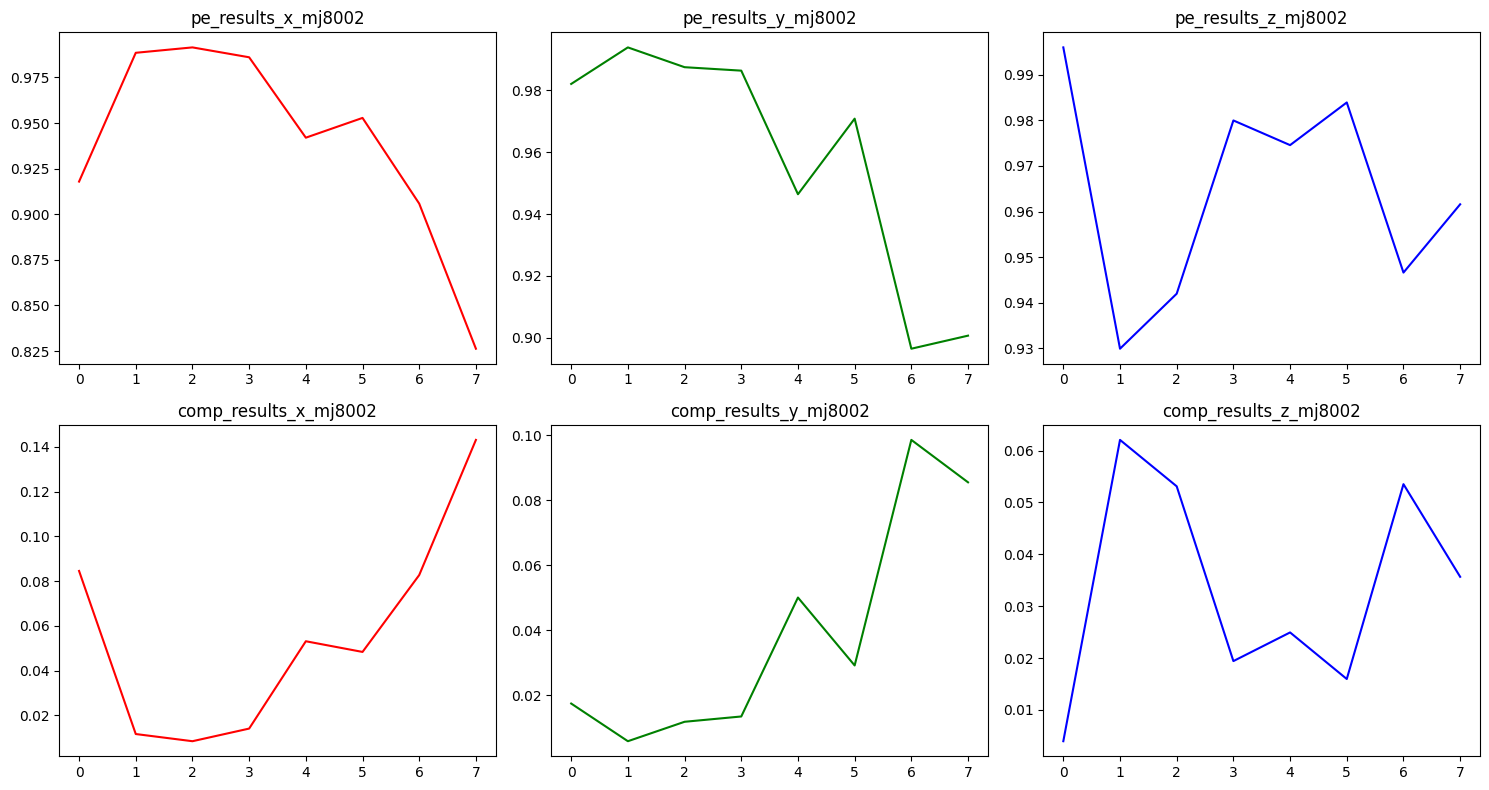

In [289]:
#Plotting the permutation entropy and complexity
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_mj8002[0:15], ax=axes[0, 0],color='r')
sns.lineplot(data=pe_results_y_mj8002[0:15], ax=axes[0, 1],color='g')
sns.lineplot(data=pe_results_z_mj8002[0:15], ax=axes[0, 2],color='b')

# Plot comp_results
sns.lineplot(data=comp_results_x_mj8002[0:15], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_mj8002[0:15], ax=axes[1, 1],color='g')
sns.lineplot(data=comp_results_z_mj8002[0:15], ax=axes[1, 2],color='b')

# Set titles
axes[0, 0].set_title('pe_results_x_mj8002')
axes[0, 1].set_title('pe_results_y_mj8002')
axes[0, 2].set_title('pe_results_z_mj8002')
axes[1, 0].set_title('comp_results_x_mj8002')
axes[1, 1].set_title('comp_results_y_mj8002')
axes[1, 2].set_title('comp_results_z_mj8002')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.917888      0.084550     0.040976                     0
1    0.988498      0.011611     0.055848                     0
2    0.991455      0.008398     0.059885                     0
3    0.986038      0.014048     0.066343                     0
4    0.941960      0.053104     0.080089                     1
5    0.952795      0.048329     0.101030                     1
6    0.905814      0.082710     0.122134                     1
7    0.826272      0.143156     0.217373                     1
   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.982092      0.017516     0.040976                     0
1    0.993914      0.005933     0.055848                     0
2    0.987509      0.011908     0.059885                     0
3    0.986392      0.013538     0.066343                     0
4    0.946404      0.050109     0.080089                     1
5    0.970859      0.029228     0.101030               

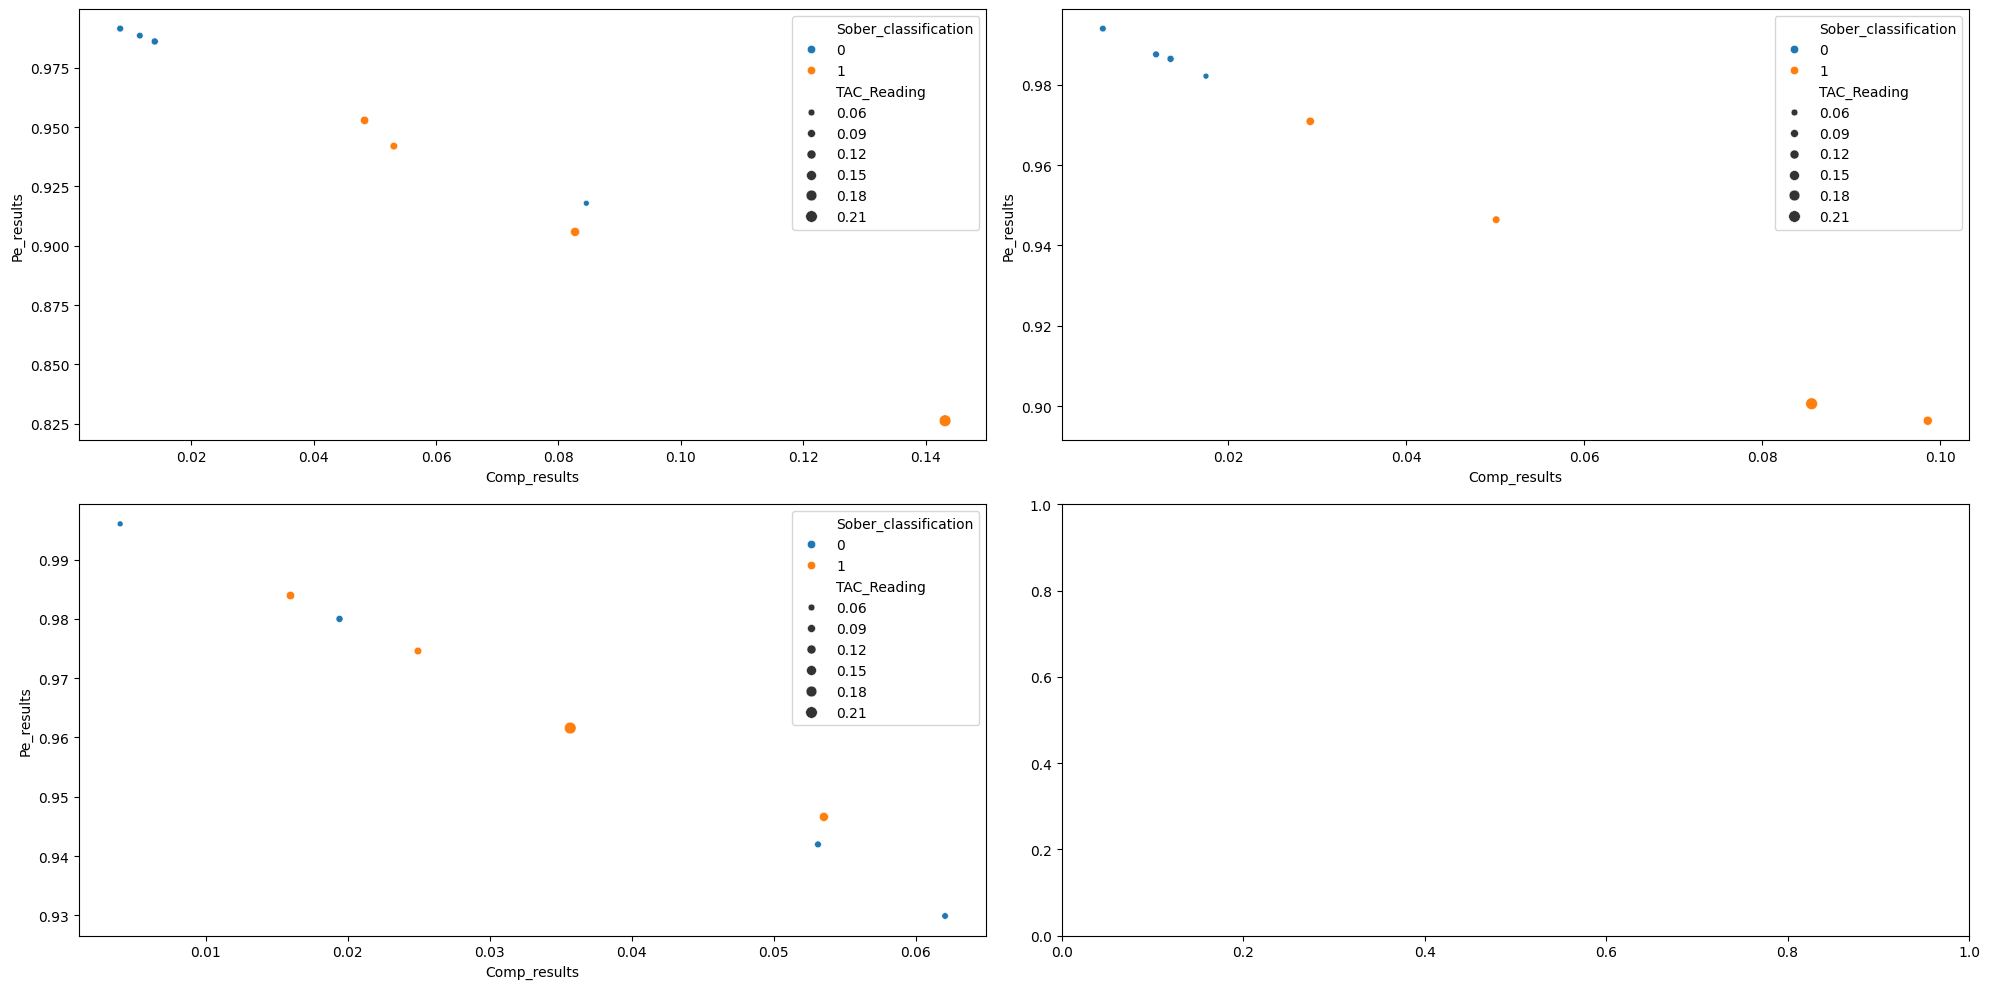

In [290]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_MJ8002= ['0.040976','0.055848','0.059885','0.066343','0.080089','0.101030 ','0.122134','0.217373']

# Create DataFrame using lists
mj8002_x =  pd.DataFrame({'Pe_results': pe_results_x_mj8002, 'Comp_results': comp_results_x_mj8002,'TAC_Reading':list_MJ8002})
mj8002_y =  pd.DataFrame({'Pe_results': pe_results_y_mj8002, 'Comp_results': comp_results_y_mj8002,'TAC_Reading':list_MJ8002})
mj8002_z =  pd.DataFrame({'Pe_results': pe_results_z_mj8002, 'Comp_results': comp_results_z_mj8002,'TAC_Reading':list_MJ8002})
#Conerting data type to float
mj8002_x['TAC_Reading'] = mj8002_x['TAC_Reading'].astype(float)
mj8002_y['TAC_Reading'] = mj8002_y['TAC_Reading'].astype(float)
mj8002_z['TAC_Reading'] = mj8002_z['TAC_Reading'].astype(float)

mj8002_x['Sober_classification'] = mj8002_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
mj8002_y['Sober_classification'] = mj8002_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
mj8002_z['Sober_classification'] = mj8002_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(mj8002_x)
print(mj8002_y)
print(mj8002_z)

#Scatter Plot

fig,axes = plt.subplots(2, 2, figsize=(20, 10))

sns.scatterplot(data=mj8002_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=mj8002_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=mj8002_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# **PC6771**

## X axis Pid PC6771

In [291]:
#Sorting the data in ascending order of TAC Reading
sort_PC6771 = merged_PC6771_df.sort_values(by=['TAC_Reading'])
sort_PC6771

time     pid         x         y         z   timestamp  \
761  1493803980984  PC6771 -0.000042 -0.000055 -0.000170  1493803980   
738  1493803980409  PC6771 -0.000013 -0.000052 -0.000112  1493803980   
737  1493803980385  PC6771 -0.000165 -0.000052 -0.000475  1493803980   
736  1493803980360  PC6771  0.000178 -0.000058  0.000538  1493803980   
735  1493803980335  PC6771  0.000010 -0.000097  0.000022  1493803980   
..             ...     ...       ...       ...       ...         ...   
136  1493747634421  PC6771  0.008120 -0.002602 -0.000028  1493747634   
137  1493747634447  PC6771  0.010365  0.000602 -0.004288  1493747634   
138  1493747634471  PC6771  0.008710  0.002237 -0.005938  1493747634   
140  1493747634521  PC6771  0.001650  0.003795  0.000245  1493747634   
122  1493747634072  PC6771 -0.002158  0.000575  0.000530  1493747634   

     TAC_Reading  
761    -0.004448  
738    -0.004448  
737    -0.004448  
736    -0.004448  
735    -0.004448  
..           ...  
136     0.089984  
137     0.089984  
138     0.089984  
140     0.089984  
122     0.089984  

[762 rows x 7 columns]

In [292]:
# Using dataframe sort_PC6771: additional classification to check if 'TAC_Reading' value is >0.08 or not
#Sober = 0 , Intoxicated (Not Sober) = 1

sort_PC6771['Sober_classification'] = sort_PC6771['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_PC6771

time     pid         x         y         z   timestamp  \
761  1493803980984  PC6771 -0.000042 -0.000055 -0.000170  1493803980   
738  1493803980409  PC6771 -0.000013 -0.000052 -0.000112  1493803980   
737  1493803980385  PC6771 -0.000165 -0.000052 -0.000475  1493803980   
736  1493803980360  PC6771  0.000178 -0.000058  0.000538  1493803980   
735  1493803980335  PC6771  0.000010 -0.000097  0.000022  1493803980   
..             ...     ...       ...       ...       ...         ...   
136  1493747634421  PC6771  0.008120 -0.002602 -0.000028  1493747634   
137  1493747634447  PC6771  0.010365  0.000602 -0.004288  1493747634   
138  1493747634471  PC6771  0.008710  0.002237 -0.005938  1493747634   
140  1493747634521  PC6771  0.001650  0.003795  0.000245  1493747634   
122  1493747634072  PC6771 -0.002158  0.000575  0.000530  1493747634   

     TAC_Reading  Sober_classification  
761    -0.004448                     0  
738    -0.004448                     0  
737    -0.004448                     0  
736    -0.004448                     0  
735    -0.004448                     0  
..           ...                   ...  
136     0.089984                     1  
137     0.089984                     1  
138     0.089984                     1  
140     0.089984                     1  
122     0.089984                     1  

[762 rows x 8 columns]

In [293]:
#Resetting the index values after sorting
sort_PC6771.reset_index(drop=True)

time     pid         x         y         z   timestamp  \
0    1493803980984  PC6771 -0.000042 -0.000055 -0.000170  1493803980   
1    1493803980409  PC6771 -0.000013 -0.000052 -0.000112  1493803980   
2    1493803980385  PC6771 -0.000165 -0.000052 -0.000475  1493803980   
3    1493803980360  PC6771  0.000178 -0.000058  0.000538  1493803980   
4    1493803980335  PC6771  0.000010 -0.000097  0.000022  1493803980   
..             ...     ...       ...       ...       ...         ...   
757  1493747634421  PC6771  0.008120 -0.002602 -0.000028  1493747634   
758  1493747634447  PC6771  0.010365  0.000602 -0.004288  1493747634   
759  1493747634471  PC6771  0.008710  0.002237 -0.005938  1493747634   
760  1493747634521  PC6771  0.001650  0.003795  0.000245  1493747634   
761  1493747634072  PC6771 -0.002158  0.000575  0.000530  1493747634   

     TAC_Reading  Sober_classification  
0      -0.004448                     0  
1      -0.004448                     0  
2      -0.004448                     0  
3      -0.004448                     0  
4      -0.004448                     0  
..           ...                   ...  
757     0.089984                     1  
758     0.089984                     1  
759     0.089984                     1  
760     0.089984                     1  
761     0.089984                     1  

[762 rows x 8 columns]

In [294]:
#Counting the number of TAC Reading in each segment
count_PC6771=sort_PC6771['TAC_Reading'].value_counts()
count_PC6771

TAC_Reading
 0.007856    41
 0.006217    41
 0.008597    40
 0.077807    40
 0.074726    40
 0.069712    40
 0.041986    40
 0.017769    40
 0.009243    40
 0.009064    40
-0.004448    40
 0.000882    40
 0.007215    40
 0.007066    40
 0.006242    40
 0.005229    40
 0.005171    40
 0.004970    40
 0.089984    40
Name: count, dtype: int64

In [295]:
#Calculating the permutation entropy and complexity
TAC_Reading_PC67771 = pd.Series([41,41,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40],name='count')
pe_results_x_pc6771= []
comp_results_x_pc6771=[]
i=0
for segment_value in TAC_Reading_PC67771:
  num_segs=len(sort_PC6771['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_PC67771[i-1]
  end_index = start_index + (segment_value)
  segment = sort_PC6771['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_x_pc6771.append(pe)
  comp_results_x_pc6771.append(comp)
  i+=1
print(pe_results_x_pc6771)
print(comp_results_x_pc6771)

[0.9355603554848959, 0.9983471528450095, 0.9388676357337804, 0.9914550895366188, 0.9459340321379603, 0.9820923909706727, 0.9914550895366188, 0.9775277211118096, 0.9735816640424042, 0.907359866754183, 0.9347445247841132, 0.9588726708838128, 0.8873833515146428, 0.9507337414066669, 0.905153120223003, 0.9531930555127586, 0.9372758663557235, 0.9875090324672132, 0.9383628774032449]
[0.06539552626272781, 0.0016296090880024156, 0.060621077591271395, 0.008397768877605242, 0.051696309547652905, 0.017515590606529255, 0.008397768877605726, 0.021813652161350488, 0.025218904530258577, 0.091742770329407, 0.0630722023881215, 0.03942734616427099, 0.10730159832028163, 0.04858015004691587, 0.08611490819461448, 0.04204066166432908, 0.05927157386690241, 0.011907627122557636, 0.05665031103465785]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Y axis Pid PC6771

In [296]:
#Calculating the permutation entropy and complexity
pe_results_y_pc6771= []
comp_results_y_pc6771=[]
i=0
for segment_value in TAC_Reading_PC67771:
  num_segs=len(sort_PC6771['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_PC67771[i-1]
  end_index = start_index + (segment_value)
  segment = sort_PC6771['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_y_pc6771.append(pe)
  comp_results_y_pc6771.append(comp)
  i+=1
print(pe_results_y_pc6771)
print(comp_results_y_pc6771)

[0.990673144821932, 0.9748910465149035, 0.9893497337838473, 0.9799870352179012, 0.9839330922873067, 0.9640419115961962, 0.9939144036427102, 0.9482303342997268, 0.9745703937213608, 0.9914550895366187, 0.9899683465733048, 0.9893497337838472, 0.9177392294637552, 0.9914550895366187, 0.9386905818535188, 0.970859376061799, 0.9960197593954816, 0.9914550895366187, 0.9137234109362771]
[0.009703919457822828, 0.023966138711890402, 0.010338040321521238, 0.019417615265194914, 0.015965351963811325, 0.03334331611047681, 0.00593285091994129, 0.05234559817344477, 0.024940115253463933, 0.008397768877605967, 0.009461402396527584, 0.01033804032152148, 0.08379062549432804, 0.008397768877605967, 0.05997034751894685, 0.029228299463340178, 0.00397411284652309, 0.008397768877605967, 0.07409626539872806]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Z axis Pid PC6771

In [297]:
#Calculating the permutation entropy and complexity
pe_results_z_pc6771= []
comp_results_z_pc6771=[]
i=0
for segment_value in TAC_Reading_PC67771:
  num_segs=len(sort_PC6771['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_PC67771[i-1]
  end_index = start_index + (segment_value)
  segment = sort_PC6771['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_z_pc6771.append(pe)
  comp_results_z_pc6771.append(comp)
  i+=1
print(pe_results_z_pc6771)
print(comp_results_z_pc6771)

[0.9538344698954355, 0.9841741455080318, 0.9654427345652585, 0.964454004886302, 0.9829443626083503, 0.9939144036427102, 0.9839330922873067, 0.9665297456127798, 0.9322852106780218, 0.9633736502402236, 0.9839330922873067, 0.9860384480400781, 0.908760689723245, 0.9652780420593098, 0.9411188520850968, 0.9868904196777557, 0.9845517050767641, 0.9860384480400781, 0.963337378812487]
[0.04784147133829831, 0.015916136607836615, 0.03464232642417998, 0.0349080892852991, 0.016256324899270196, 0.005932850919940804, 0.015965351963811325, 0.03191058160815995, 0.0652378753686149, 0.033276054673442676, 0.015965351963811325, 0.014047963107715064, 0.0930615454471386, 0.03381308006600918, 0.051253038365452266, 0.012780524083383751, 0.015097119514571749, 0.014047963107715064, 0.03647340227689505]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Permutation Entropy and Complexity plots

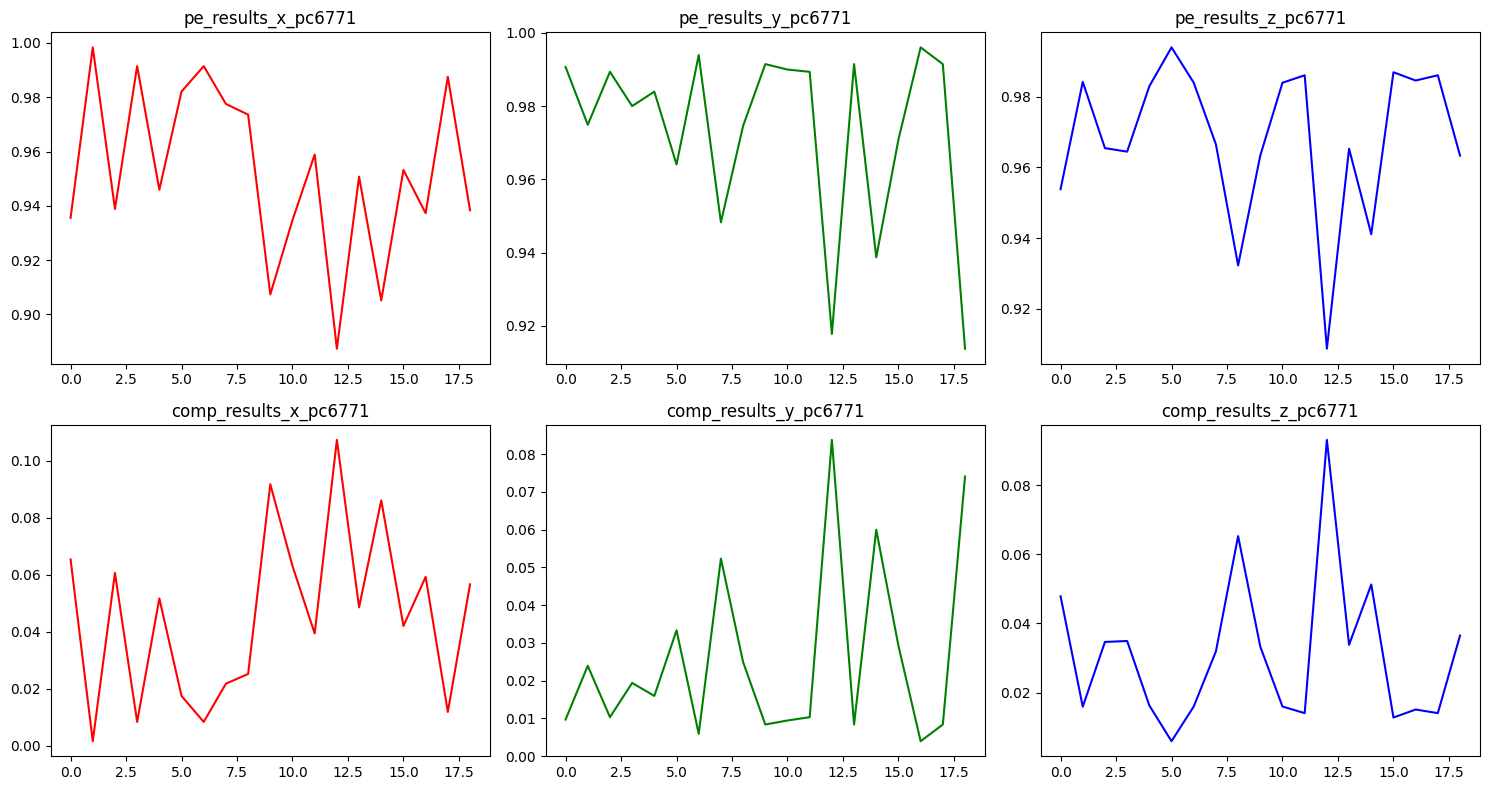

In [298]:
#Plotting the permutation entropy and complexity
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_pc6771[0:20], ax=axes[0, 0],color='r')
sns.lineplot(data=pe_results_y_pc6771[0:20], ax=axes[0, 1],color='g')
sns.lineplot(data=pe_results_z_pc6771[0:20], ax=axes[0, 2],color='b')

# Plot comp_results
sns.lineplot(data=comp_results_x_pc6771[0:20], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_pc6771[0:20], ax=axes[1, 1],color='g')
sns.lineplot(data=comp_results_z_pc6771[0:20], ax=axes[1, 2],color='b')

# Set titles
axes[0, 0].set_title('pe_results_x_pc6771')
axes[0, 1].set_title('pe_results_y_pc6771')
axes[0, 2].set_title('pe_results_z_pc6771')
axes[1, 0].set_title('comp_results_x_pc6771')
axes[1, 1].set_title('comp_results_y_pc6771')
axes[1, 2].set_title('comp_results_z_pc6771')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [299]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_PC6771= [' 0.007856',' 0.006217 ',' 0.008597',' 0.077807',' 0.074726',' 0.069712',' 0.041986',' 0.017769',' 0.009243',' 0.009064','-0.004448',' 0.000882',' 0.007215',' 0.007066',' 0.006242',' 0.005229 ',' 0.005171',' 0.004970',' 0.089984 ']

# Create DataFrame using lists
pc6771_x =  pd.DataFrame({'Pe_results': pe_results_x_pc6771, 'Comp_results': comp_results_x_pc6771,'TAC_Reading':list_PC6771})
pc6771_y =  pd.DataFrame({'Pe_results': pe_results_y_pc6771, 'Comp_results': comp_results_y_pc6771,'TAC_Reading':list_PC6771})
pc6771_z =  pd.DataFrame({'Pe_results': pe_results_z_pc6771, 'Comp_results': comp_results_z_pc6771,'TAC_Reading':list_PC6771})
#Conerting data type to float
pc6771_x['TAC_Reading'] = pc6771_x['TAC_Reading'].astype(float)
pc6771_y['TAC_Reading'] = pc6771_y['TAC_Reading'].astype(float)
pc6771_z['TAC_Reading'] = pc6771_z['TAC_Reading'].astype(float)

pc6771_x['Sober_classification'] = pc6771_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
pc6771_y['Sober_classification'] = pc6771_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
pc6771_z['Sober_classification'] = pc6771_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(pc6771_x)
print(pc6771_y)
print(bk7610_z)

#Scatter Plot
fig,axes = plt.subplots(2, 2, figsize=(20, 10))

sns.scatterplot(data=pc6771_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=pc6771_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=pc6771_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

    Pe_results  Comp_results  TAC_Reading  Sober_classification
0     0.935560      0.065396     0.007856                     0
1     0.998347      0.001630     0.006217                     0
2     0.938868      0.060621     0.008597                     0
3     0.991455      0.008398     0.077807                     0
4     0.945934      0.051696     0.074726                     0
5     0.982092      0.017516     0.069712                     0
6     0.991455      0.008398     0.041986                     0
7     0.977528      0.021814     0.017769                     0
8     0.973582      0.025219     0.009243                     0
9     0.907360      0.091743     0.009064                     0
10    0.934745      0.063072    -0.004448                     0
11    0.958873      0.039427     0.000882                     0
12    0.887383      0.107302     0.007215                     0
13    0.950734      0.048580     0.007066                     0
14    0.905153      0.086115     0.00624


# **SA0297**


## X axis Pid SA0297

In [300]:
#Sorting the data in ascending order of TAC Reading
sort_SA0297 = merged_SA0297_df.sort_values(by=['TAC_Reading'])
sort_SA0297

time     pid         x         y         z   timestamp  \
395  1493806094960  SA0297 -0.000000 -0.000017 -0.000150  1493806094   
394  1493806094915  SA0297 -0.000030 -0.000017 -0.000100  1493806094   
374  1493806094009  SA0297 -0.000038  0.000000 -0.000110  1493806094   
375  1493806094055  SA0297 -0.000025  0.000005 -0.000120  1493806094   
376  1493806094099  SA0297 -0.000030 -0.000017 -0.000153  1493806094   
..             ...     ...       ...       ...       ...         ...   
26   1493747291185  SA0297 -0.000050 -0.000038 -0.000122  1493747291   
25   1493747291140  SA0297  0.000050 -0.000005 -0.000130  1493747291   
22   1493747291005  SA0297 -0.000040  0.000038 -0.000132  1493747291   
24   1493747291095  SA0297  0.000048  0.000030 -0.000050  1493747291   
32   1493747291455  SA0297 -0.000005 -0.000005 -0.000155  1493747291   

     TAC_Reading  
395    -0.021275  
394    -0.021275  
374    -0.021275  
375    -0.021275  
376    -0.021275  
..           ...  
26      0.182644  
25      0.182644  
22      0.182644  
24      0.182644  
32      0.182644  

[396 rows x 7 columns]

In [301]:
# Using dataframe sort_SA0297: additional classification to check if 'TAC_Reading' value is >0.08 or not
#Sober = 0 , Intoxicated (Not Sober) = 1

sort_SA0297['Sober_classification'] = sort_SA0297['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_SA0297

time     pid         x         y         z   timestamp  \
395  1493806094960  SA0297 -0.000000 -0.000017 -0.000150  1493806094   
394  1493806094915  SA0297 -0.000030 -0.000017 -0.000100  1493806094   
374  1493806094009  SA0297 -0.000038  0.000000 -0.000110  1493806094   
375  1493806094055  SA0297 -0.000025  0.000005 -0.000120  1493806094   
376  1493806094099  SA0297 -0.000030 -0.000017 -0.000153  1493806094   
..             ...     ...       ...       ...       ...         ...   
26   1493747291185  SA0297 -0.000050 -0.000038 -0.000122  1493747291   
25   1493747291140  SA0297  0.000050 -0.000005 -0.000130  1493747291   
22   1493747291005  SA0297 -0.000040  0.000038 -0.000132  1493747291   
24   1493747291095  SA0297  0.000048  0.000030 -0.000050  1493747291   
32   1493747291455  SA0297 -0.000005 -0.000005 -0.000155  1493747291   

     TAC_Reading  Sober_classification  
395    -0.021275                     0  
394    -0.021275                     0  
374    -0.021275                     0  
375    -0.021275                     0  
376    -0.021275                     0  
..           ...                   ...  
26      0.182644                     1  
25      0.182644                     1  
22      0.182644                     1  
24      0.182644                     1  
32      0.182644                     1  

[396 rows x 8 columns]

In [302]:
#Resetting the index values after sorting
sort_SA0297.reset_index(drop=True)

time     pid         x         y         z   timestamp  \
0    1493806094960  SA0297 -0.000000 -0.000017 -0.000150  1493806094   
1    1493806094915  SA0297 -0.000030 -0.000017 -0.000100  1493806094   
2    1493806094009  SA0297 -0.000038  0.000000 -0.000110  1493806094   
3    1493806094055  SA0297 -0.000025  0.000005 -0.000120  1493806094   
4    1493806094099  SA0297 -0.000030 -0.000017 -0.000153  1493806094   
..             ...     ...       ...       ...       ...         ...   
391  1493747291185  SA0297 -0.000050 -0.000038 -0.000122  1493747291   
392  1493747291140  SA0297  0.000050 -0.000005 -0.000130  1493747291   
393  1493747291005  SA0297 -0.000040  0.000038 -0.000132  1493747291   
394  1493747291095  SA0297  0.000048  0.000030 -0.000050  1493747291   
395  1493747291455  SA0297 -0.000005 -0.000005 -0.000155  1493747291   

     TAC_Reading  Sober_classification  
0      -0.021275                     0  
1      -0.021275                     0  
2      -0.021275                     0  
3      -0.021275                     0  
4      -0.021275                     0  
..           ...                   ...  
391     0.182644                     1  
392     0.182644                     1  
393     0.182644                     1  
394     0.182644                     1  
395     0.182644                     1  

[396 rows x 8 columns]

In [303]:
#Counting the number of TAC Reading in each segment
count_SA0297=sort_SA0297['TAC_Reading'].value_counts()
count_SA0297

TAC_Reading
 0.182644    23
 0.065172    23
-0.004768    22
 0.114999    22
 0.106077    22
 0.079004    22
 0.065889    22
 0.062414    22
 0.032672    22
-0.021275    22
 0.019586    22
 0.010822    22
 0.010223    22
 0.008145    22
 0.005265    22
 0.004950    22
 0.032527    22
 0.006509    20
Name: count, dtype: int64

In [304]:
#Calculating the permutation entropy and complexity
TAC_Reading_SA0297 = pd.Series([23,23,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,20],name='count')
pe_results_x_sa0297= []
comp_results_x_sa0297=[]
i=0
for segment_value in TAC_Reading_SA0297:
  num_segs=len(sort_SA0297['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_SA0297[i-1]
  end_index = start_index + (segment_value)
  segment = sort_SA0297['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_x_sa0297.append(pe)
  comp_results_x_sa0297.append(comp)
  i+=1
print(pe_results_x_sa0297)
print(comp_results_x_sa0297)

[0.9277902462594632, 0.9942854629567635, 0.9850972089384687, 0.9850972089384687, 0.9780462753853015, 0.9026073758112833, 0.9615130960445009, 0.9539625121297578, 0.8979346790097092, 0.9685640295976682, 0.9469115785765904, 0.9539625121297578, 0.9318104107471041, 0.8931251300236499, 0.9318104107471042, 0.9539625121297578, 0.9385516216060535, 0.9175744981783097]
[0.07029723025569778, 0.005621518403213633, 0.015030744043126711, 0.015030744043126711, 0.021165443929259956, 0.08854062073581817, 0.036542369734032146, 0.04774885791347486, 0.09105442669009668, 0.030628576469405915, 0.05343950609551556, 0.04774885791347486, 0.06604907904463853, 0.09087879404466226, 0.0660490790446383, 0.04774885791347486, 0.05314746468825863, 0.08100033988920399]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Y axis Pid SA0297

In [305]:
#Calculating the permutation entropy and complexity
pe_results_y_sa0297= []
comp_results_y_sa0297=[]
i=0
for segment_value in TAC_Reading_SA0297:
  num_segs=len(sort_SA0297['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_SA0297[i-1]
  end_index = start_index + (segment_value)
  segment = sort_SA0297['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_y_sa0297.append(pe)
  comp_results_y_sa0297.append(comp)
  i+=1
print(pe_results_y_sa0297)
print(comp_results_y_sa0297)

[0.939856775397578, 0.9331416005850376, 0.9539625121297578, 0.9003158088038198, 0.9318104107471041, 0.9520308502568676, 0.9318104107471041, 0.9843006345716333, 0.9780462753853014, 0.9520308502568676, 0.9539625121297578, 0.8979346790097092, 0.9780462753853014, 0.9615130960445009, 0.9393609946618473, 0.9412926565347374, 0.9393609946618472, 0.9443342351289138]
[0.06123453813908227, 0.06661879370124683, 0.04774885791347486, 0.09379313552451389, 0.06604907904463853, 0.04568529338305897, 0.06604907904463853, 0.014822806018445624, 0.021165443929260196, 0.04568529338305897, 0.04774885791347486, 0.09105442669009668, 0.021165443929260196, 0.036542369734032146, 0.05526675564471487, 0.05732509763678015, 0.055266755644715095, 0.05480034665605653]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Z axis Pid SA0297

In [306]:
#Calculating the permutation entropy and complexity
pe_results_z_sa0297= []
comp_results_z_sa0297=[]
i=0
for segment_value in TAC_Reading_SA0297:
  num_segs=len(sort_SA0297['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_SA0297[i-1]
  end_index = start_index + (segment_value)
  segment = sort_SA0297['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_z_sa0297.append(pe)
  comp_results_z_sa0297.append(comp)
  i+=1
print(pe_results_z_sa0297)
print(comp_results_z_sa0297)

[0.9875702881442231, 0.9277902462594633, 0.9780462753853014, 0.8836428842360167, 0.828424424171762, 0.9318104107471041, 0.9520308502568676, 0.9850972089384689, 0.9756149631508356, 0.961513096044501, 0.9049856125628767, 0.9077266474915605, 0.9558941740026478, 0.9685640295976682, 0.9374293327889572, 0.9794359242226802, 0.9653764197902811, 0.9443342351289138]
[0.011744896370690676, 0.07029723025569802, 0.021165443929260196, 0.09873457974582482, 0.1449274963679685, 0.06604907904463853, 0.04568529338305897, 0.015030744043126472, 0.024624779427705412, 0.03654236973403192, 0.08599344009962727, 0.09013287719958758, 0.04059671399338938, 0.030628576469405915, 0.06226191280583364, 0.017945448402067802, 0.03136290960013658, 0.05480034665605653]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Permutation Entropy and Complexity plots

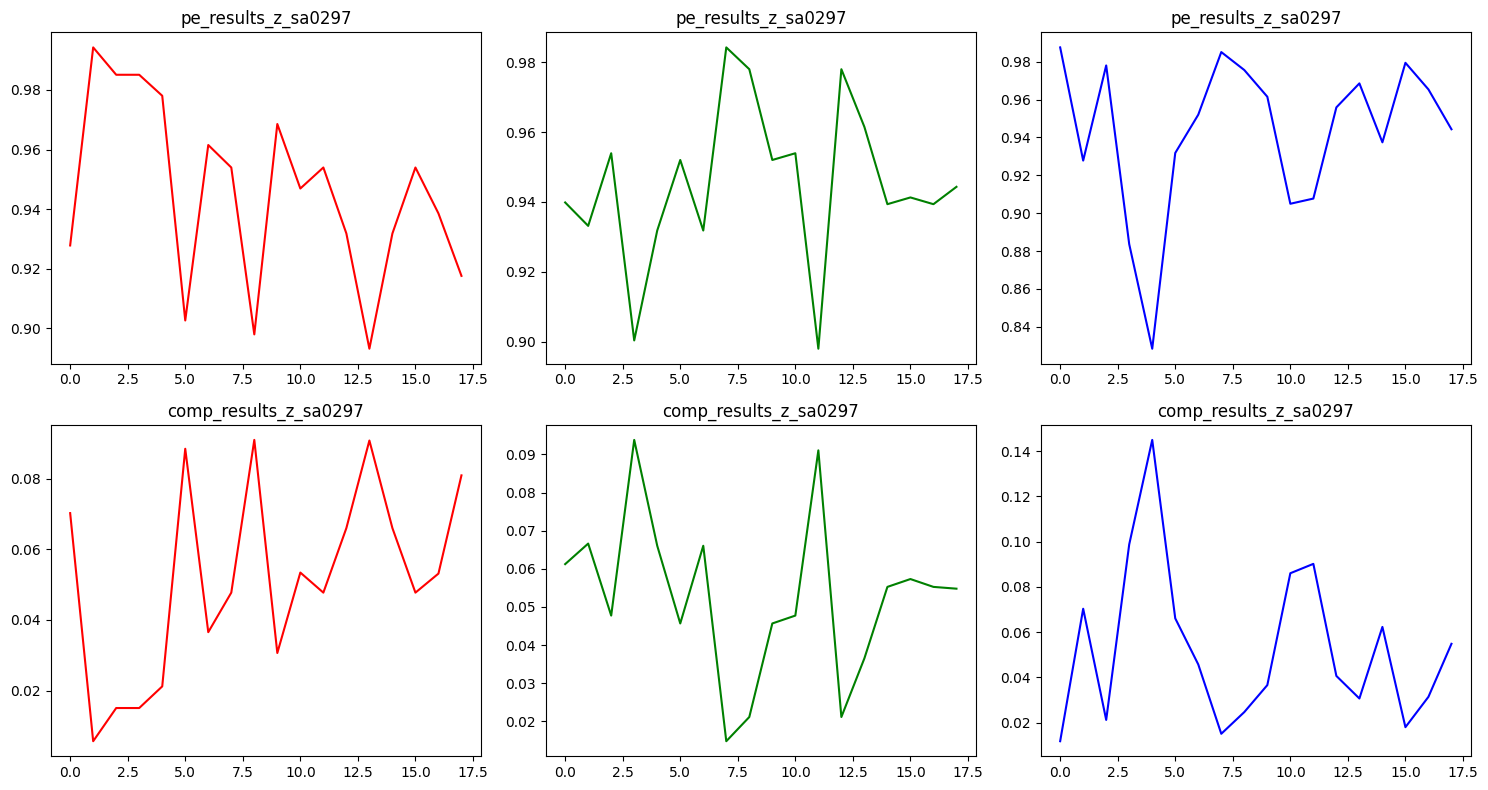

In [307]:
#Plotting the permutation entropy and complexity graphs
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_sa0297[0:20], ax=axes[0, 0],color='r')
sns.lineplot(data=pe_results_y_sa0297[0:20], ax=axes[0, 1],color='g')
sns.lineplot(data=pe_results_z_sa0297[0:20], ax=axes[0, 2],color='b')

# Plot comp_results
sns.lineplot(data=comp_results_x_sa0297[0:20], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_sa0297[0:20], ax=axes[1, 1],color='g')
sns.lineplot(data=comp_results_z_sa0297[0:20], ax=axes[1, 2],color='b')

# Set titles
axes[0, 0].set_title('pe_results_z_sa0297')
axes[0, 1].set_title('pe_results_z_sa0297')
axes[0, 2].set_title('pe_results_z_sa0297')
axes[1, 0].set_title('comp_results_z_sa0297')
axes[1, 1].set_title('comp_results_z_sa0297')
axes[1, 2].set_title('comp_results_z_sa0297')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

    Pe_results  Comp_results  TAC_Reading  Sober_classification
0     0.927790      0.070297     0.182644                     1
1     0.994285      0.005622     0.065172                     0
2     0.985097      0.015031    -0.004768                     0
3     0.985097      0.015031     0.114999                     1
4     0.978046      0.021165     0.106077                     1
5     0.902607      0.088541     0.079004                     0
6     0.961513      0.036542     0.065889                     0
7     0.953963      0.047749     0.062414                     0
8     0.897935      0.091054     0.032672                     0
9     0.968564      0.030629    -0.021275                     0
10    0.946912      0.053440     0.019586                     0
11    0.953963      0.047749     0.010822                     0
12    0.931810      0.066049     0.010223                     0
13    0.893125      0.090879     0.008145                     0
14    0.931810      0.066049     0.00526

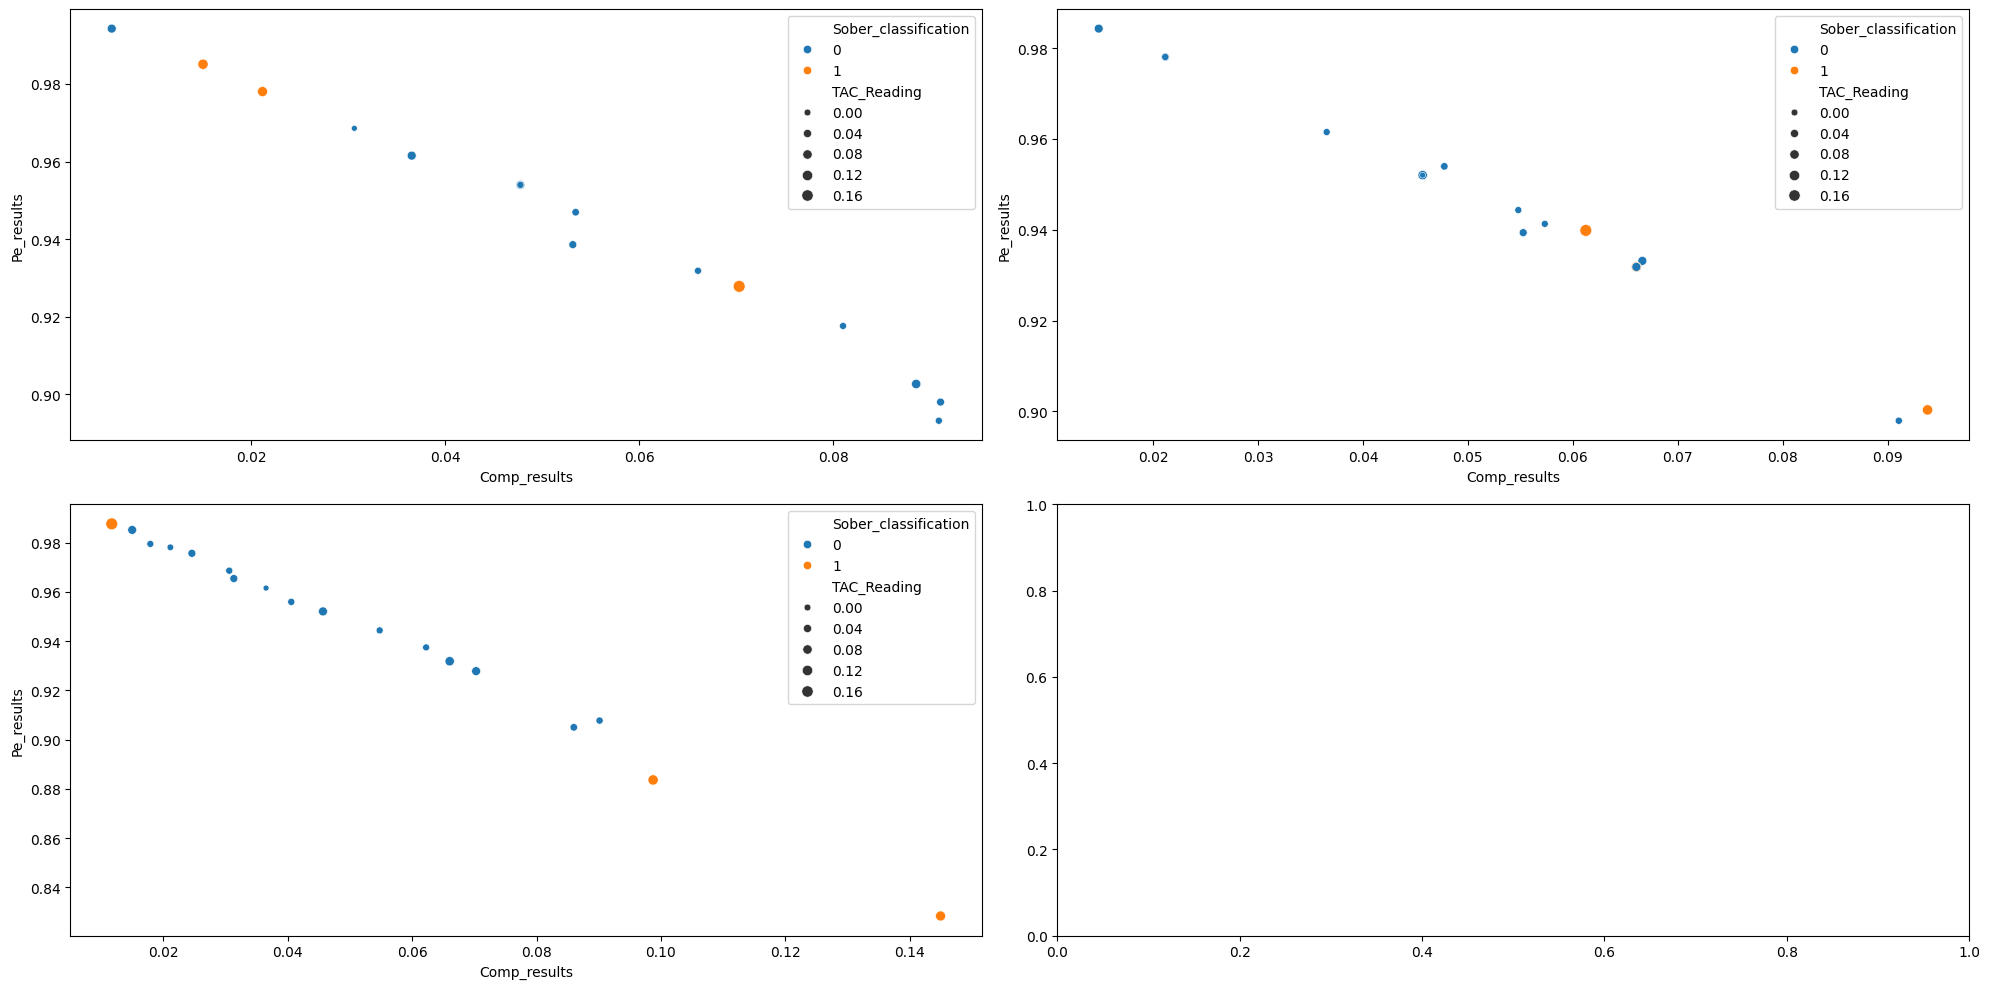

In [308]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_SA0297= ['0.182644','0.065172','-0.004768','0.114999','0.106077','0.079004',' 0.065889','0.062414',' 0.032672','-0.021275 ',' 0.019586',' 0.010822',' 0.010223',' 0.008145',' 0.005265',' 0.004950',' 0.032527',' 0.006509']

# Create DataFrame using lists
sa0297_x =  pd.DataFrame({'Pe_results': pe_results_x_sa0297, 'Comp_results': comp_results_x_sa0297,'TAC_Reading':list_SA0297})
sa0297_y =  pd.DataFrame({'Pe_results': pe_results_y_sa0297, 'Comp_results': comp_results_y_sa0297,'TAC_Reading':list_SA0297})
sa0297_z =  pd.DataFrame({'Pe_results': pe_results_z_sa0297, 'Comp_results': comp_results_z_sa0297,'TAC_Reading':list_SA0297})
#Conerting data type to float
sa0297_x['TAC_Reading'] = sa0297_x['TAC_Reading'].astype(float)
sa0297_y['TAC_Reading'] = sa0297_y['TAC_Reading'].astype(float)
sa0297_z['TAC_Reading'] = sa0297_z['TAC_Reading'].astype(float)

sa0297_x['Sober_classification'] = sa0297_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sa0297_y['Sober_classification'] = sa0297_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sa0297_z['Sober_classification'] = sa0297_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(sa0297_x)
print(sa0297_y)
print(sa0297_z)

#Scatter Plot
fig,axes = plt.subplots(2, 2, figsize=(20, 10))

sns.scatterplot(data=sa0297_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=sa0297_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=sa0297_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# **SA3097**

## X axis Pid SF3079

In [309]:
#Sorting the data in ascending order of TAC Reading
sort_SF3079 = merged_SF3079_df.sort_values(by=['TAC_Reading'])
sort_SF3079

time     pid         x         y         z   timestamp  \
229  1493775799789  SF3079 -0.000145  0.000022  0.000013  1493775799   
219  1493775799516  SF3079 -0.000115 -0.000050 -0.000060  1493775799   
220  1493775799544  SF3079  0.000010  0.000097  0.000000  1493775799   
221  1493775799571  SF3079 -0.000040  0.000070 -0.000007  1493775799   
222  1493775799603  SF3079 -0.000100  0.000160  0.000013  1493775799   
..             ...     ...       ...       ...       ...         ...   
24   1493741116615  SF3079  0.000050  0.000073 -0.000020  1493741116   
23   1493741116590  SF3079 -0.000040  0.000007 -0.000060  1493741116   
22   1493741116566  SF3079  0.000030  0.000030  0.000048  1493741116   
20   1493741116526  SF3079  0.000013  0.000035 -0.000015  1493741116   
0    1493741116016  SF3079 -0.000010 -0.000060 -0.000065  1493741116   

     TAC_Reading  
229     0.083469  
219     0.083469  
220     0.083469  
221     0.083469  
222     0.083469  
..           ...  
24      0.171436  
23      0.171436  
22      0.171436  
20      0.171436  
0       0.171436  

[356 rows x 7 columns]

In [310]:
# Using dataframe sort_SF3079: additional classification to check if 'TAC_Reading' value is >0.08 or not
#Sober = 0 , Intoxicated (Not Sober) = 1

sort_SF3079['Sober_classification'] = sort_SF3079['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sort_SF3079

time     pid         x         y         z   timestamp  \
229  1493775799789  SF3079 -0.000145  0.000022  0.000013  1493775799   
219  1493775799516  SF3079 -0.000115 -0.000050 -0.000060  1493775799   
220  1493775799544  SF3079  0.000010  0.000097  0.000000  1493775799   
221  1493775799571  SF3079 -0.000040  0.000070 -0.000007  1493775799   
222  1493775799603  SF3079 -0.000100  0.000160  0.000013  1493775799   
..             ...     ...       ...       ...       ...         ...   
24   1493741116615  SF3079  0.000050  0.000073 -0.000020  1493741116   
23   1493741116590  SF3079 -0.000040  0.000007 -0.000060  1493741116   
22   1493741116566  SF3079  0.000030  0.000030  0.000048  1493741116   
20   1493741116526  SF3079  0.000013  0.000035 -0.000015  1493741116   
0    1493741116016  SF3079 -0.000010 -0.000060 -0.000065  1493741116   

     TAC_Reading  Sober_classification  
229     0.083469                     1  
219     0.083469                     1  
220     0.083469                     1  
221     0.083469                     1  
222     0.083469                     1  
..           ...                   ...  
24      0.171436                     1  
23      0.171436                     1  
22      0.171436                     1  
20      0.171436                     1  
0       0.171436                     1  

[356 rows x 8 columns]

In [311]:
#Resetting the index values after sorting
sort_SF3079.reset_index(drop=True)

time     pid         x         y         z   timestamp  \
0    1493775799789  SF3079 -0.000145  0.000022  0.000013  1493775799   
1    1493775799516  SF3079 -0.000115 -0.000050 -0.000060  1493775799   
2    1493775799544  SF3079  0.000010  0.000097  0.000000  1493775799   
3    1493775799571  SF3079 -0.000040  0.000070 -0.000007  1493775799   
4    1493775799603  SF3079 -0.000100  0.000160  0.000013  1493775799   
..             ...     ...       ...       ...       ...         ...   
351  1493741116615  SF3079  0.000050  0.000073 -0.000020  1493741116   
352  1493741116590  SF3079 -0.000040  0.000007 -0.000060  1493741116   
353  1493741116566  SF3079  0.000030  0.000030  0.000048  1493741116   
354  1493741116526  SF3079  0.000013  0.000035 -0.000015  1493741116   
355  1493741116016  SF3079 -0.000010 -0.000060 -0.000065  1493741116   

     TAC_Reading  Sober_classification  
0       0.083469                     1  
1       0.083469                     1  
2       0.083469                     1  
3       0.083469                     1  
4       0.083469                     1  
..           ...                   ...  
351     0.171436                     1  
352     0.171436                     1  
353     0.171436                     1  
354     0.171436                     1  
355     0.171436                     1  

[356 rows x 8 columns]

In [312]:
#Counting the number of TAC Reading in each segment
count_SF3079=sort_SF3079['TAC_Reading'].value_counts()
count_SF3079

TAC_Reading
0.101965    40
0.104253    40
0.107148    40
0.130305    40
0.171436    40
0.083469    39
0.095807    39
0.135561    39
0.159026    39
Name: count, dtype: int64

In [313]:
#Calculating the permutation entropy and complexity
TAC_Reading_SF3079 = pd.Series([40,40,40,40,40,39,39,39,39],name='count')
pe_results_x_sf3079= []
comp_results_x_sf3079=[]
i=0
for segment_value in TAC_Reading_SF3079:
  num_segs=len(sort_SF3079['x'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_SF3079[i-1]
  end_index = start_index + (segment_value)
  segment = sort_SF3079['x'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_x_sf3079.append(pe)
  comp_results_x_sf3079.append(comp)
  i+=1
print(pe_results_x_sf3079)
print(comp_results_x_sf3079)

[0.9745703937213608, 0.9899683465733048, 0.9594772417373335, 0.9939144036427102, 0.9419600406038849, 0.9645532386579083, 0.9708903361469576, 0.8202857033156866, 0.9719344776998712]
[0.024940115253464408, 0.009461402396527584, 0.037484041313710637, 0.00593285091994129, 0.05310366509309665, 0.03423277549556411, 0.027540419673697553, 0.1446236367369351, 0.027139558281002462]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Y axis Pid SF3079

In [314]:
#Calculating the permutation entropy and complexity
pe_results_y_sf3079= []
comp_results_y_sf3079=[]
i=0
for segment_value in TAC_Reading_SF3079:
  num_segs=len(sort_SF3079['y'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_SF3079[i-1]
  end_index = start_index + (segment_value)
  segment = sort_SF3079['y'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_y_sf3079.append(pe)
  comp_results_y_sf3079.append(comp)
  i+=1
print(pe_results_y_sf3079)
print(comp_results_y_sf3079)

[0.8886629895327828, 0.9419600406038848, 0.9710944154716428, 0.9232787364728414, 0.9114829777038501, 0.9557115544611606, 0.9692395519902083, 0.8982826972921762, 0.9918012987001761]
[0.09543226029778343, 0.05310366509309687, 0.02771063689562163, 0.07313901422954307, 0.0895099317342859, 0.044237052452558275, 0.02867101182947473, 0.0878845509985841, 0.007964820385426098]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Z axis Pid SF3097

In [315]:
#Calculating the permutation entropy and complexity
pe_results_z_sf3079= []
comp_results_z_sf3079=[]
i=0
for segment_value in TAC_Reading_SF3079:
  num_segs=len(sort_SF3079['z'])//segment_value
  if (i==0):
    start_index=0
  else:
    start_index +=TAC_Reading_SF3079[i-1]
  end_index = start_index + (segment_value)
  segment = sort_SF3079['z'][start_index:end_index]
  op= ordinal_patterns(segment, 3, 1)
  pe = p_entropy(op)
  comp = complexity(op)
  pe_results_z_sf3079.append(pe)
  comp_results_z_sf3079.append(comp)
  i+=1
print(pe_results_z_sf3079)
print(comp_results_z_sf3079)

[0.925616865628011, 0.9447543560500088, 0.9794683843586323, 0.9914550895366187, 0.9328323814477826, 0.9431308030018363, 0.9862382614875129, 0.9459266663332686, 0.9990151200695889]
[0.07198224097549036, 0.054935626447809846, 0.01908297068285706, 0.008397768877605967, 0.062189275356012076, 0.05146681083973658, 0.013699810936188814, 0.05193316510145347, 0.0009546208410792721]


<ipython-input-200-944f380d48bf>:43: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])
<ipython-input-200-944f380d48bf>:34: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  counts = np.zeros(np.math.factorial(m))


## Permutation Entropy and Complexity plots

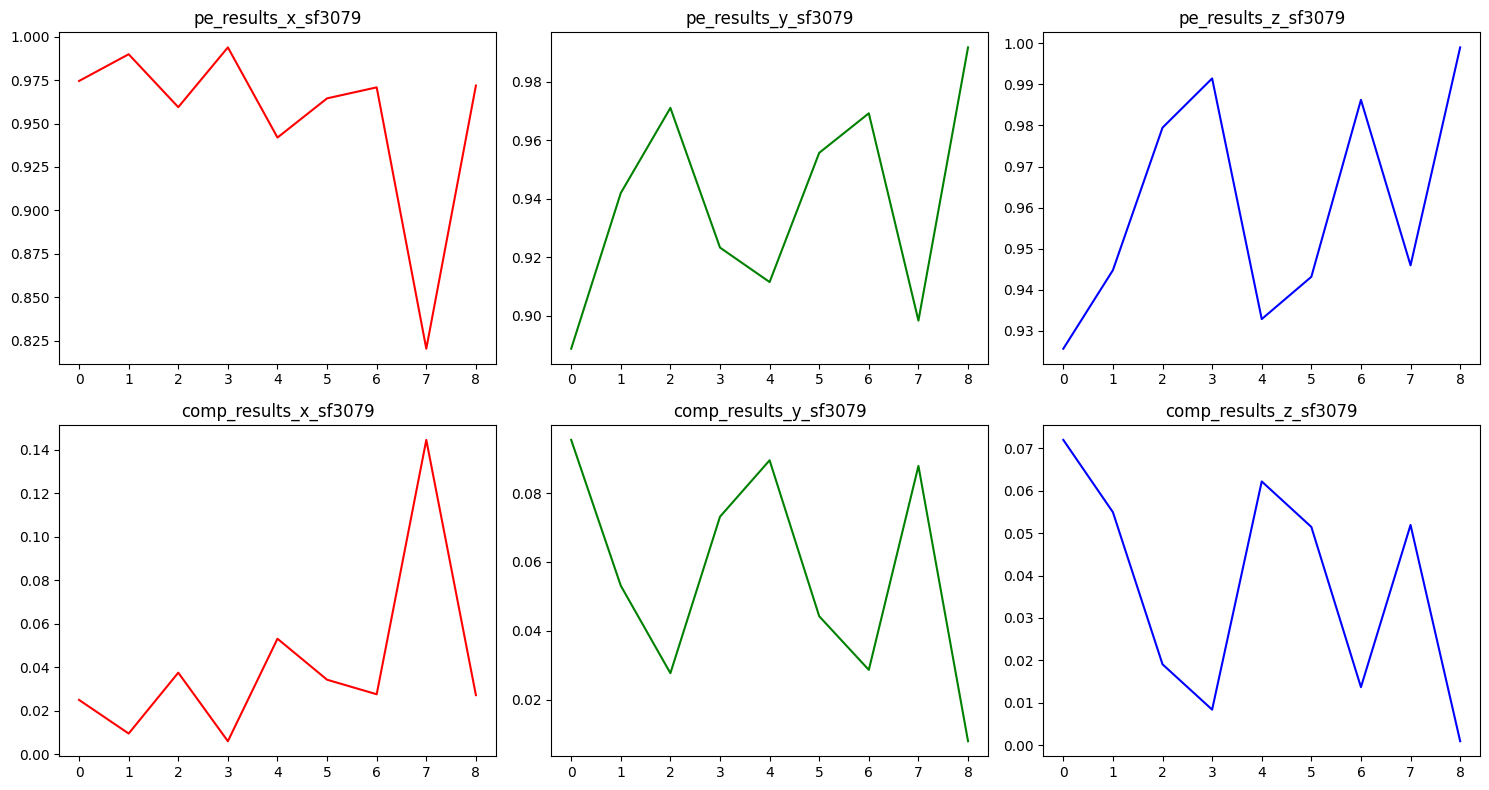

In [316]:
#Plotting the permutation entropy and complexity graphs
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot pe_results
sns.lineplot(data=pe_results_x_sf3079[0:20], ax=axes[0, 0],color='r')
sns.lineplot(data=pe_results_y_sf3079[0:20], ax=axes[0, 1],color='g')
sns.lineplot(data=pe_results_z_sf3079[0:20], ax=axes[0, 2],color='b')

# Plot comp_results
sns.lineplot(data=comp_results_x_sf3079[0:20], ax=axes[1, 0],color='r')
sns.lineplot(data=comp_results_y_sf3079[0:20], ax=axes[1, 1],color='g')
sns.lineplot(data=comp_results_z_sf3079[0:20], ax=axes[1, 2],color='b')

# Set titles
axes[0, 0].set_title('pe_results_x_sf3079')
axes[0, 1].set_title('pe_results_y_sf3079')
axes[0, 2].set_title('pe_results_z_sf3079')
axes[1, 0].set_title('comp_results_x_sf3079')
axes[1, 1].set_title('comp_results_y_sf3079')
axes[1, 2].set_title('comp_results_z_sf3079')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [318]:
#Plotting scatter plot against permutation entropy and complexity based on sober classification
list_SF3079= ['0.101965','0.104253','0.107148','0.130305','0.171436','0.083469','0.095807','0.135561','0.159026']

# Create DataFrame using lists
sf3079_x =  pd.DataFrame({'Pe_results': pe_results_x_sf3079, 'Comp_results': comp_results_x_sf3079,'TAC_Reading':list_SF3079})
sf3079_y =  pd.DataFrame({'Pe_results': pe_results_y_sf3079, 'Comp_results': comp_results_y_sf3079,'TAC_Reading':list_SF3079})
sf3079_z =  pd.DataFrame({'Pe_results': pe_results_z_sf3079, 'Comp_results': comp_results_z_sf3079,'TAC_Reading':list_SF3079})
#Conerting data type to float
sf3079_x['TAC_Reading'] = sf3079_x['TAC_Reading'].astype(float)
sf3079_y['TAC_Reading'] = sf3079_y['TAC_Reading'].astype(float)
sf3079_z['TAC_Reading'] = sf3079_z['TAC_Reading'].astype(float)

sf3079_x['Sober_classification'] = sf3079_x['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sf3079_y['Sober_classification'] = sf3079_y['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)
sf3079_z['Sober_classification'] = sf3079_z['TAC_Reading'].apply(lambda x: 1 if x > 0.08 else 0)

# Display the DataFrame
print(sf3079_x)
print(sf3079_y)
print(sf3079_z)

#Scatter Plot

fig,axes = plt.subplots(2, 2, figsize=(20, 10))

sns.scatterplot(data=sf3079_x, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 0])
sns.scatterplot(data=sf3079_y, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[0, 1])
sns.scatterplot(data=sf3079_z, x='Comp_results', y='Pe_results', hue='Sober_classification', size='TAC_Reading',ax=axes[1, 0])


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.974570      0.024940     0.101965                     1
1    0.989968      0.009461     0.104253                     1
2    0.959477      0.037484     0.107148                     1
3    0.993914      0.005933     0.130305                     1
4    0.941960      0.053104     0.171436                     1
5    0.964553      0.034233     0.083469                     1
6    0.970890      0.027540     0.095807                     1
7    0.820286      0.144624     0.135561                     1
8    0.971934      0.027140     0.159026                     1
   Pe_results  Comp_results  TAC_Reading  Sober_classification
0    0.888663      0.095432     0.101965                     1
1    0.941960      0.053104     0.104253                     1
2    0.971094      0.027711     0.107148                     1
3    0.923279      0.073139     0.130305                     1
4    0.911483      0.089510     0.171436               

#***Results & Conclusion***

From the above evaulation and classification of all 13 PIDs based on their behaviour during period of intoxication, the below points can be noted.
1. The evaluation has to be further continued using a regression model or machine learning model to classify accurately.
2. There might be need of more data required for better performance of analysis.
3. It can be noted that there are some sujects with high level of intoxication and some completely sober
4. The segmentation of the time series analysis helped to better understand the data and calculate the permutation entropy and complexity values
5. Many subjects had higher permutation entropy and mirror values of complexity which may tend to lean toward suggesting they are intoxicated

Challenges :
1. Initially to handling the data and merging acceleration and TAC values based on Timestamps took rigorous understanding of data.
2. Segmentation of the TAC values to obtain the different time intervals of behaviour/movement was challenging.